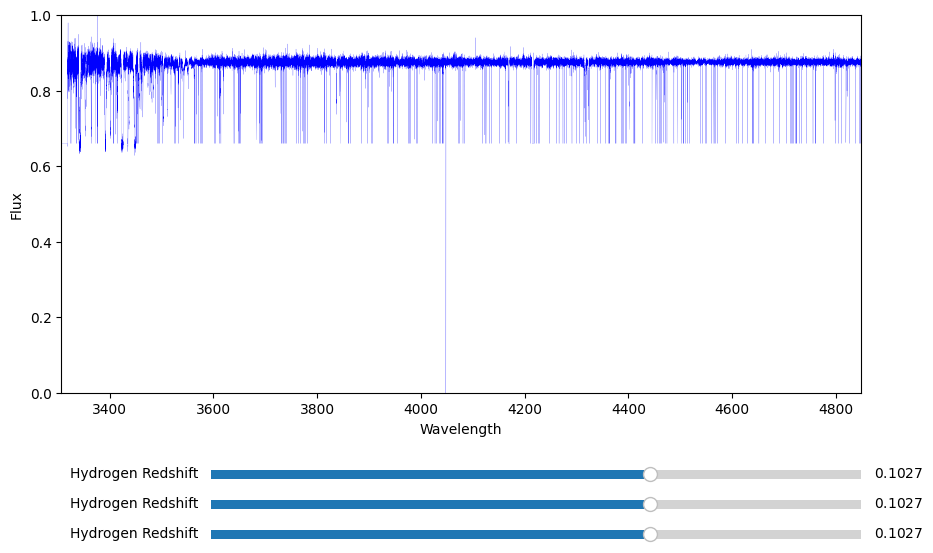

In [3]:
import pandas as pd
from astropy.io import fits

atoms=[]
transisitions=[]

with open('/Users/jakereinheimer/Desktop/Fakhri/atom_db.dat','r') as f:
    content=f.readlines()

    content=content[9:]

    for row in content:

        if row[0]=="!":
            break

        atom=row[:row.find(";")]

        atoms.append(atom)

        new_line=row[row.find(";")+1:]

        while new_line[0]==" ":
            new_line=new_line[1:]

        transisition=new_line[:new_line.find(" "):]

        transisitions.append(float(transisition))

df=pd.DataFrame({
    "Atomic Transisitions":atoms,
    "Emission Line":transisitions
})

def get_data(file):
    with fits.open(file) as hdul:
        #header = hdul[0].header
        #print(header)
        #hdul.info()  # This will print information about all the extensions in your FITS file

       # print(help(hdul))

        #print(hdul[0].data)

        # Assuming your spectral data is in the first extension
        spectral_data = hdul[0].data  # Change the index if your data is in a different extension

        return spectral_data
    
def normalize(data):

    # Min-Max scaling
    min_val = np.min(data)
    max_val = np.max(data)

    scaled_data = (data - min_val) / (max_val - min_val)

    return scaled_data

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Assuming get_data and normalize functions are defined
# Define your transitions and atoms if not already done
transitions = [1215.67, 1025.72, 972.54]  # Example transition wavelengths for Lyman series
atoms = ['Hydrogen', 'Hydrogen', 'Hydrogen']  # Corresponding atoms

test_file='/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J000520+052410/Sargent_Oct_12_13_14_1999/'
lower_lim=3307
upper_lim=4849

redshift=0.1027

data=get_data(test_file+'J000520+052410_f.fits')
wavelength = np.linspace(lower_lim,upper_lim,len(data))
error=get_data(test_file+'J000520+052410_e.fits')

normalized_data = normalize(data)
normalized_error = normalize(error)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(left=0.1, bottom=0.25)

# Initial plot of the spectrum
line, = ax.plot(wavelength, normalized_data, 'b', label='Observed Spectrum', linewidth=.1)

# Create a dictionary to hold the line objects
transition_lines = {}
for i, atom in enumerate(atoms):
    redshifted_wavelength = transitions[i] * (1 + redshift)
    transition_lines[atom] = ax.axvline(redshifted_wavelength, linestyle='--', color='red', linewidth=0.5)

ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.set_ylim(0, 1)
ax.set_xlim(lower_lim, upper_lim)

# Create sliders
axcolor = 'lightgoldenrodyellow'
ax_sliders = [plt.axes([0.25, 0.1 - 0.05 * i, 0.65, 0.03], facecolor=axcolor) for i in range(len(atoms))]
sliders = [Slider(ax_slider, label=f'{atom} Redshift', valmin=-0.1, valmax=0.2, valinit=redshift) for ax_slider, atom in zip(ax_sliders, atoms)]

# Update function
def update(val):
    for slider, atom in zip(sliders, atoms):
        z = slider.val
        redshifted_wavelength = transitions[atoms.index(atom)] * (1 + z)
        transition_lines[atom].set_xdata(redshifted_wavelength)

    fig.canvas.draw_idle()

# Connect sliders to update function
for slider in sliders:
    slider.on_changed(update)

plt.show()


In [162]:
import pandas as pd

# Load the new data file uploaded by the user
new_file_path = '/Users/jakereinheimer/Desktop/Fakhri/VPFit/logging/new_atom_db.dat'
new_data = pd.read_csv(new_file_path, delimiter=" ", header=None, usecols=[0, 1, 2, 3])
new_data.columns = ['Transition', 'Wavelength', 'Oscillator Strength', 'Tau']

# Convert 'Wavelength' to numeric, forcing errors to NaN
new_data['Wavelength'] = pd.to_numeric(new_data['Wavelength'], errors='coerce')

# Drop rows where 'Wavelength' could not be converted to a numeric type
new_data = new_data.dropna(subset=['Wavelength'])

# Filter out rows with Oscillator Strength below 0.02
new_data = new_data[new_data['Oscillator Strength'] >= 0.02]

# Function to filter rows based on the wavelength condition
def filter_wavelength(group):
    group = group.sort_values('Wavelength')
    diff = group['Wavelength'].diff().abs()
    return group[(diff > 1) | (diff.isna())]

# Apply the filter function on groups formed by the 'Transition' column
filtered_data = new_data.groupby('Transition').apply(filter_wavelength).reset_index(drop=True)

# Output the filtered data to a new .dat file
output_file_path = '/Users/jakereinheimer/Desktop/Fakhri/VPFit/logging/filtered_atom_db.dat'
filtered_data.to_csv(output_file_path, sep=' ', index=False, header=None)

print(f"Filtered data has been saved to: {output_file_path}")


Filtered data has been saved to: /Users/jakereinheimer/Desktop/Fakhri/VPFit/logging/filtered_atom_db.dat


/var/folders/14/t9yl8b4s7fjd8jtqgt9jn8fr0000gn/T/ipykernel_97779/641462257.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data = new_data.groupby('Transition').apply(filter_wavelength).reset_index(drop=True)


In [168]:
# Attempt to load the data again, ignoring extra columns

file_path="/Users/jakereinheimer/Desktop/Fakhri/VPFit/logging/new_atom_db.dat"
data = pd.read_csv(file_path, delimiter=" ", header=None, usecols=range(4))
data.columns = ['Transition', 'Wavelength', 'Strength', 'Tau']

# Filter the dataframe for Strength >= 0.02
filtered_data = data[data['Strength'] >= 0.02]
filtered_data.head()

filtered_data['Wavelength'] = pd.to_numeric(filtered_data['Wavelength'], errors='coerce')

# Save the resulting dataframe to a new .dat file
output_path = "/Users/jakereinheimer/Desktop/Fakhri/VPFit/logging/filtered.dat"

filtered_data.to_csv(output_path, sep=',', index=False)


# Group by Transition and aggregate by custom function to check for wavelength closeness and max strength
def filter_by_wavelength_and_strength(group):
    # Sort group by Wavelength and Strength
    group = group.sort_values(['Wavelength', 'Strength'], ascending=[True, False])
    # Remove rows with Wavelength within 1 Angstrom of a row with higher Strength
    filtered_group = group.groupby((group['Wavelength'].diff().abs() > 1).cumsum()).first().reset_index(drop=True)
    return filtered_group

# Apply the custom function on each group
result_data = filtered_data.groupby('Transition').apply(filter_by_wavelength_and_strength).reset_index(drop=True)
result_data.head()

# Convert Wavelength column to float
filtered_data['Wavelength'] = pd.to_numeric(filtered_data['Wavelength'], errors='coerce')

# Reapply the filter and grouping
result_data = filtered_data.groupby('Transition').apply(filter_by_wavelength_and_strength).reset_index(drop=True)
result_data.head()

# Save the resulting dataframe to a new .dat file
output_path = "/Users/jakereinheimer/Desktop/Fakhri/VPFit/logging/result.dat"

result_data.to_csv(output_path, sep='\t', index=False)
output_path




/var/folders/14/t9yl8b4s7fjd8jtqgt9jn8fr0000gn/T/ipykernel_97779/1734701301.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Wavelength'] = pd.to_numeric(filtered_data['Wavelength'], errors='coerce')
/var/folders/14/t9yl8b4s7fjd8jtqgt9jn8fr0000gn/T/ipykernel_97779/1734701301.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_data = filtered_data.groupby('Transition').apply(filter_by_wavelength_and_strength).reset_index(drop=True)

'/Users/jakereinheimer/Desktop/Fakhri/VPFit/logging/result.dat'

In [36]:
from astropy.io import fits

# Open the FITS file
with fits.open('/Users/jakereinheimer/Desktop/Fakhri/VPFit/test/Searched_Quasars_SDSS_DR7_107.fits',ignore_missing_simple=True) as hdul:
    print(hdul)
    data = hdul[1].data  # Assuming the primary HDU contains the image
    print(data)
    print(len(data))
    print(len(data[0]))
    #wavelength = data['wavelength']  # This column name might vary
    #flux = data['flux']
    #flux_err = data['flux_err']  # Check the actual column name for errors

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ff0e98643d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff0aa074c40>]
[(0, 2.72280000e-02,  0.515341, 685, 467, 52203, 1.823826)
 (0, 3.39000000e-02,  0.276301, 685, 470, 52203, 1.836383)
 (1, 3.86040000e-02, 15.298477, 751, 354, 52251, 1.197476) ...
 (0, 3.59994452e+02, -1.207033, 685, 227, 52203, 1.776881)
 (0, 3.59994688e+02,  0.562592, 685, 461, 52203, 1.693126)
 (1, 3.59996092e+02, -9.162233, 650, 448, 52143, 1.287561)]
84533
7


In [172]:
def read_atomDB():
        
        atom_loc='/Users/jakereinheimer/Desktop/Fakhri/VPFit/filtered_atom_db.dat'

        AtomDB = pd.read_csv(atom_loc, sep=',', engine='python', header=None, names=['Transition', 'Wavelength', 'Strength', 'Tau'])

        return AtomDB

atom=read_atomDB()
print(atom.head())

  Transition  Wavelength  Strength      Tau
0         HI   1215.6701   0.41640  6.265E8
1         HI   1025.7223   0.07912  1.897E8
2         HI    972.5368   0.02900  8.127E7
3        HI2   6564.6230   0.69580  6.465E7
4        HI2   4862.6880   0.12180  2.062E7


In [175]:
from astropy.io import fits

# Path to the FITS file
file_path = '/Users/jakereinheimer/Desktop/Fakhri/test_data/test/Trimmed_SDSS_DR7_107.fits'

# Open the FITS file
with fits.open(file_path, ignore_missing_simple=True) as hdul:
    print("List of HDUs:")
    print(hdul.info())  # Summarize the HDUs in this FITS file, showing index, HDU type (e.g., Image HDU or Binary Table), etc.

    # Loop through each HDU and display header and data information
    for i, hdu in enumerate(hdul):
        print(f"\n\n--- HDU {i} Info ---")
        print("Header:")
        print(repr(hdu.header))  # Display the header for the current HDU

        # Depending on the HDU type, the data content can be an image or a table
        if isinstance(hdu, fits.ImageHDU) or isinstance(hdu, fits.PrimaryHDU):
            try:
                print("Data: Image or array with shape", hdu.data.shape)
            except:
                print("no data length")
        elif isinstance(hdu, fits.BinTableHDU) or isinstance(hdu, fits.TableHDU):
            print("Data: Table with columns", hdu.columns.names)

            # Optionally, you can uncomment the next line to print the data in the table
            #print(hdu.data)

        '''
        # If there are specific columns you know you're interested in, like 'wavelength', 'flux', 'flux_err'
        if 'wavelength' in hdu.columns.names:
            print("Wavelength data:", hdu.data['wavelength'])
        if 'flux' in hdu.columns.names:
            print("Flux data:", hdu.data['flux'])
        if 'flux_err' in hdu.columns.names:
            print("Flux Error data:", hdu.data['flux_err'])
        '''

List of HDUs:
Filename: /Users/jakereinheimer/Desktop/Fakhri/test_data/test/Trimmed_SDSS_DR7_107.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    127   35752R x 55C   [D, D, J, J, J, E, E, J, E, E, E, J, E, E, E, E, B, B, B, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
None


--- HDU 0 Info ---
Header:
SIMPLE  =                    T /Dummy Created by MWRFITS v1.8                   
BITPIX  =                    8 /Dummy primary header created by MWRFITS         
NAXIS   =                    0 /No data is associated with this header          
EXTEND  =                    T /Extensions may (will!) be present               
no data length


--- HDU 1 Info ---
Header:
XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.8            
BITPIX  =                    8 /Required value                              

In [173]:
from astropy.io import fits

# Path to the FITS file
file_path = '/Users/jakereinheimer/Desktop/Fakhri/test_data/test/QSObased_Expanded_SDSS_DR7_107.fits'

# Open the FITS file
with fits.open(file_path, ignore_missing_simple=True) as hdul:
    print("List of HDUs:")
    print(hdul.info())  # Summarize the HDUs in this FITS file, showing index, HDU type (e.g., Image HDU or Binary Table), etc.

    # Loop through each HDU and display header and data information
    for i, hdu in enumerate(hdul):
        print(f"\n\n--- HDU {i} Info ---")
        print("Header:")
        print(repr(hdu.header))  # Display the header for the current HDU

        # Depending on the HDU type, the data content can be an image or a table
        if isinstance(hdu, fits.ImageHDU) or isinstance(hdu, fits.PrimaryHDU):
            try:
                print("Data: Image or array with shape", hdu.data.shape)
            except:
                print("no data length")
        elif isinstance(hdu, fits.BinTableHDU) or isinstance(hdu, fits.TableHDU):
            print("Data: Table with columns", hdu.columns.names)

            # Optionally, you can uncomment the next line to print the data in the table
            #print(hdu.data)

        '''
        # If there are specific columns you know you're interested in, like 'wavelength', 'flux', 'flux_err'
        if 'wavelength' in hdu.columns.names:
            print("Wavelength data:", hdu.data['wavelength'])
        if 'flux' in hdu.columns.names:
            print("Flux data:", hdu.data['flux'])
        if 'flux_err' in hdu.columns.names:
            print("Flux Error data:", hdu.data['flux_err'])
        '''

List of HDUs:
Filename: /Users/jakereinheimer/Desktop/Fakhri/test_data/test/QSObased_Expanded_SDSS_DR7_107.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    127   33185R x 55C   [D, D, J, J, J, E, E, J, E, E, E, J, 10E, 10E, 10E, 10E, 10B, 10B, 10B, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E, 10E]   
None


--- HDU 0 Info ---
Header:
SIMPLE  =                    T /Dummy Created by MWRFITS v1.8                   
BITPIX  =                    8 /Dummy primary header created by MWRFITS         
NAXIS   =                    0 /No data is associated with this header          
EXTEND  =                    T /Extensions may (will!) be present               
no data length


--- HDU 1 Info ---
Header:
XTENSION= 'BINTABLE'           /Binary table written by MWRFI

In [143]:
import pandas as pd
from astropy.io import fits
import numpy as np
import shutil
import os

def fits_to_dataframe(fits_file_path):
    # Open the FITS file
    with fits.open(fits_file_path) as hdul:
        # Assuming that the data of interest is in the first BinTableHDU
        data = hdul[1].data
    
    # Convert FITS data to a Pandas DataFrame ensuring little-endian data types
    df = pd.DataFrame()
    for column in data.columns.names:
        if data[column].dtype.byteorder == '>':
            df[column] = data[column].byteswap().newbyteorder()
        else:
            df[column] = data[column]

    # Convert specified columns to string type and ensure 4 digits
    columns_to_format = ['PLATE', 'MJD', 'FIBER']  # Specify the column names that should be formatted
    for col in columns_to_format:
        df[col] = df[col].astype(int).apply(lambda x: f'{x:04}')

    return df


df = fits_to_dataframe('/Users/jakereinheimer/Desktop/Fakhri/test_data/test/Searched_Quasars_SDSS_DR7_107.fits')
df

destination=f"/Users/jakereinheimer/Desktop/Fakhri/data/SDSS7/"
# Using iterrows
for index, row in df.iterrows():

    found_loc = f"/Users/jakereinheimer/Desktop/Fakhri/sdss_dr7/spectro/ss_tar_26/{int(row['PLATE']):04}/spSpec/spSpec-{int(row['MJD']):05}-{int(row['PLATE']):04}-{int(row['FIBER']):03}.fit"

    if os.path.exists(found_loc):
        #continue

        dest_loc=destination+f"{int(row['PLATE']):04}-{int(row['FIBER']):03}"

        os.mkdir(dest_loc)

        shutil.copy(found_loc,dest_loc+"/data.fit")


In [183]:
df=fits_to_dataframe('/Users/jakereinheimer/Desktop/Fakhri/test_data/test/Trimmed_SDSS_DR7_107.fits')
pd.set_option('display.max_columns', None)
print(df.head)
df.to_csv("Line_locs.csv",sep=",")
df

<bound method NDFrame.head of                RA        DEC PLATE FIBER    MJD      ZQSO  ERR_ZQSO  \
0        0.039089  13.938450  0750  0082  52235  2.234200  0.006468   
1        0.039089  13.938450  0750  0082  52235  2.234200  0.006468   
2        0.039271 -10.464426  0650  0199  52143  1.853006  0.003253   
3        0.064497   0.879677  0685  0439  52203  1.857073  0.002114   
4        0.064497   0.879677  0685  0439  52203  1.857073  0.002114   
...           ...        ...   ...   ...    ...       ...       ...   
35747  359.856106   0.481853  0387  0472  51791  2.034704  0.001518   
35748  359.910012  -0.580131  0387  0188  51791  1.207074  0.001102   
35749  359.933898  -0.960619  0387  0134  51791  1.792511  0.002073   
35750  359.933898  -0.960619  0387  0134  51791  1.792511  0.002073   
35751  359.996092  -9.162233  0650  0448  52143  1.287561  0.001462   

       INDEX_QSO  SPEC_SNR_MEDIAN  MED_SDEVIATION_RED  MED_SDEVIATION_BLUE  \
0              3        13.311056      

RA        DEC PLATE FIBER    MJD      ZQSO  ERR_ZQSO  \
0        0.039089  13.938450  0750  0082  52235  2.234200  0.006468   
1        0.039089  13.938450  0750  0082  52235  2.234200  0.006468   
2        0.039271 -10.464426  0650  0199  52143  1.853006  0.003253   
3        0.064497   0.879677  0685  0439  52203  1.857073  0.002114   
4        0.064497   0.879677  0685  0439  52203  1.857073  0.002114   
...           ...        ...   ...   ...    ...       ...       ...   
35747  359.856106   0.481853  0387  0472  51791  2.034704  0.001518   
35748  359.910012  -0.580131  0387  0188  51791  1.207074  0.001102   
35749  359.933898  -0.960619  0387  0134  51791  1.792511  0.002073   
35750  359.933898  -0.960619  0387  0134  51791  1.792511  0.002073   
35751  359.996092  -9.162233  0650  0448  52143  1.287561  0.001462   

       INDEX_QSO  SPEC_SNR_MEDIAN  MED_SDEVIATION_RED  MED_SDEVIATION_BLUE  \
0              3        13.311056            0.035272             0.024731   
1              3        13.311056            0.035272             0.024731   
2              4         9.383075            0.025009             0.046234   
3             11         6.945078            0.042914             0.058074   
4             11         6.945078            0.042914             0.058074   
...          ...              ...                 ...                  ...   
35747     107171        18.784384            0.018357             0.017102   
35748     107179        20.471525            0.015644          -999.000000   
35749     107182         8.341034            0.022194             0.053776   
35750     107182         8.341034            0.022194             0.053776   
35751     107192        15.734499            0.024683          -999.000000   

       NABS      ZABS  ERR_ZABS       VDISP  ERR_VDISP  CRITERION_MGII  \
0         2  0.963585  0.000051  126.228470   0.210247               1   
1         2  1.144889  0.000050  102.411682   0.190966               1   
2         1  1.312953  0.000007   62.896412   0.177782               1   
3         2  1.636650  0.000075   97.961815   0.187971               1   
4         2  1.371505  0.000070   19.156912   0.343497               1   
...     ...       ...       ...         ...        ...             ...   
35747     4  1.380221  0.000200   57.641048   0.179900               1   
35748     1  1.128123  0.000021   69.056198   0.177015               1   
35749     2  1.143483  0.000030   85.551216   0.181106               1   
35750     2  1.470524  0.000018    0.069030   0.000000               1   
35751     1  0.682984  0.000091    0.069030   0.000000               1   

       CRITERION_MGII_FEII  CRITERION_FEII  SIGNAL_MGII_2803  \
0                        1               1          2.051140   
1                        0               0          0.476951   
2                        1               1          2.613599   
3                        1               1          2.164986   
4                        1               1          1.719624   
...                    ...             ...               ...   
35747                    0               0          0.218176   
35748                    1               1          1.989984   
35749                    1               1          2.554672   
35750                    1               0          0.817248   
35751                    1               1          0.402528   

       SIGNAL_MGII_2796  SNR_MGII_2803  SNR_MGII_2796  REW_MGI_2853  \
0              2.646050      16.784904      21.181597  3.124993e-01   
1              0.547000       4.130694       4.688301  3.012452e-01   
2              2.491326      18.972019      13.923535  1.320771e-01   
3              2.550472       8.687255       6.916927  3.665569e-01   
4              1.359060       9.070110       6.843363  1.630939e-01   
...                 ...            ...            ...           ...   
35747          0.366779       2.742273       4.521295  4.199794e-11   

In [124]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# Path to your FITS file
file_path = '/Users/jakereinheimer/Desktop/Fakhri/data/SDSS7/0685/spPlate-0685-52203.fits'

with fits.open(file_path) as hdul:
    data = hdul[0].data[438]  # Data from the primary HDU
    error

    print(data)
    print(len(data))
    print(data[0])

[[10.650012   10.65129    10.652565   ...  8.0953045   8.095288
   8.095272  ]
 [ 0.5797619   0.5798324   0.57990277 ...  1.9608983   1.960895
   1.9608917 ]
 [-0.11743019 -0.11744443 -0.11745863 ...  2.5623047   2.5623002
   2.562296  ]
 ...
 [ 1.4604914   1.460147    1.4598032  ...  2.443851    2.4439049
   2.4439583 ]
 [ 0.41330466  0.4132069   0.41310927 ... 10.837982   10.838218
  10.838454  ]
 [ 4.756108    4.7549872   4.753868   ...  4.1914697   4.1915617
   4.1916537 ]]
640
[10.650012  10.65129   10.652565  ...  8.0953045  8.095288   8.095272 ]


[3800.14352942 3801.1437597  3802.14398999 ... 7649.02966618 7650.02989646
 7651.03012675]


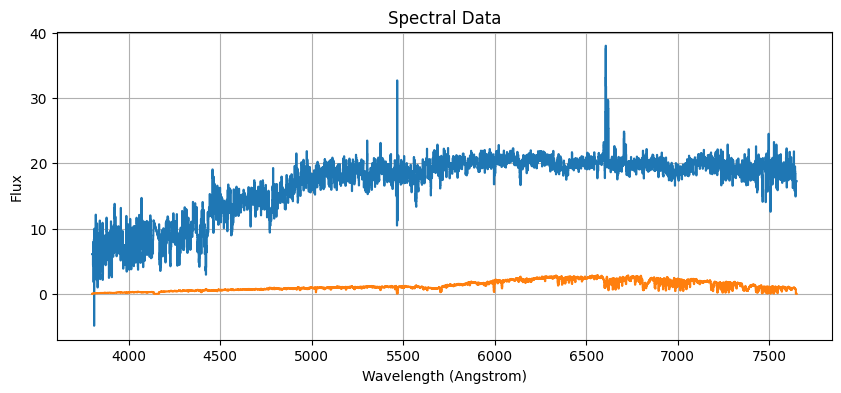

In [129]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# Path to your FITS file
file_path = '/Users/jakereinheimer/Desktop/Fakhri/data/SDSS7/0750/spPlate-0750-52235.fits'

# Open the FITS file
with fits.open(file_path) as hdul:
    data = hdul[0].data  # Data from the primary HDU
    flux=data[82]
    error=hdul[1].data[82]

    header = hdul[0].header

    # Retrieve the necessary header information to calculate the wavelength
    crval1 = header['CRVAL1']  # Starting wavelength
    cdelt1 = header['CD1_1']  # Wavelength increment per pixel
    npixels = header['NAXIS1'] 

    wavelength = 10**crval1 + 10**cdelt1 * np.arange(npixels)

    print(wavelength)


    # Plotting the spectrum
    plt.figure(figsize=(10, 4))
    plt.plot(wavelength, flux, drawstyle='steps-mid')
    plt.plot(wavelength, error, drawstyle='steps-mid')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title('Spectral Data')
    plt.grid(True)
    plt.show()


/Users/jakereinheimer/Desktop/Fakhri/data/SDSS7/0267-051/data.fit
8.049111


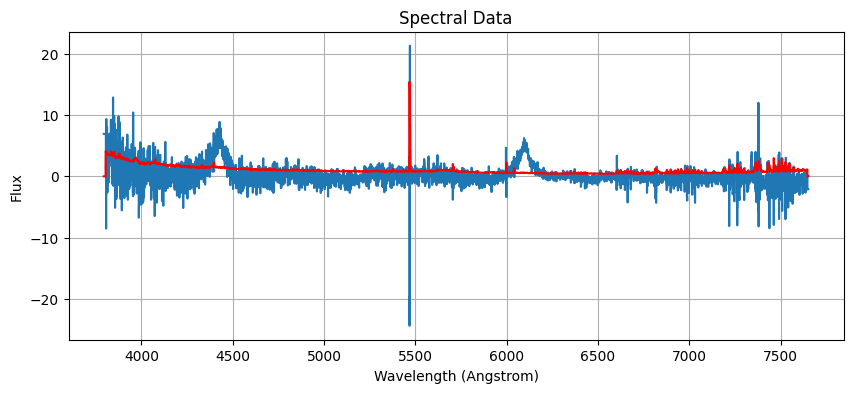

In [150]:
import os

folder="/Users/jakereinheimer/Desktop/Fakhri/data/SDSS7/0267-051"
catalog="SDSS7"
plate="0267"
fiber="051"

file=os.listdir(folder)[0]
file_path=folder+"/"+file
print(file_path)

with fits.open(file_path) as hdul:
    data = hdul[0].data  # Data from the primary HDU
    flux=data[0]
    cont_flux=data[1]
    error=data[2]

    header = hdul[0].header

    # Retrieve the necessary header information to calculate the wavelength
    crval1 = header['CRVAL1']  # Starting wavelength
    cdelt1 = header['CD1_1']  # Wavelength increment per pixel
    npixels = header['NAXIS1'] 
    z=header['Z']

    wavelength = 10**crval1 + 10**cdelt1 * np.arange(npixels)

    inves=data[0]

    print(np.mean(inves))
    
    plt.figure(figsize=(10, 4))
    plt.plot(wavelength, cont_flux, drawstyle='steps-mid')
    plt.plot(wavelength,error,c="red")
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title('Spectral Data')
    plt.grid(True)
    plt.show()


In [88]:
import shutil
import os

source_loc="/Users/jakereinheimer/Desktop/Fakhri/sdss_dr7/spectro/ss_tar_26"

destination_loc="/Users/jakereinheimer/Desktop/Fakhri/data/SDSS7"

objects=os.listdir(source_loc)

for object in objects:
    if "." in object:
        continue

    loc=source_loc+'/'+object

    current_files=os.listdir(loc)

    dest=destination_loc+'/'+object

    os.mkdir(dest)

    for file in current_files:
        if "Plate" in file:
            if ".fits" in file:

                shutil.copy(loc+'/'+file,dest+'/'+file)



In [46]:
from astropy.io import fits

# Open the FITS file
with fits.open(file_path,ignore_missing_simple=True) as hdul:
    print(hdul)
    data = hdul[1].data  # Assuming the primary HDU contains the image
    print(data)
    print(len(data))
    print(len(data[0]))
    #wavelength = data['wavelength']  # This column name might vary
    #flux = data['flux']
    #flux_err = data['flux_err']  # Check the actual column name for errors

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ff0d8dd1d00>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff0b9763880>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff0b9763ac0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff0b9763d00>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff0b9763f40>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff0b94e0520>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff0b9765640>]
[(4613.7935, 11.756836  , 4556.171, 4680.5835, 44.35773  , 19.058699  , 0.5, -9999.,  1.1261221, 0.2111479 , 6.1269016, 20.436144 , 9.37578   , 2., -9999., 1.0551437, 89.092316, 115, 0., 1.3563156e-19, -9999., -9999., '')
 (7511.4233,  0.08422852, 7505.852, 7516.229 ,  2.8262064,  0.08808458, 0.5, -9999., 19.133902 , 0.52319145, 7.1726074, 18.89798  , 0.7463087 , 2., -9999., 3.8348508, 32.76398 ,   4, 0., 1.3563156e-19, -9999., -9999., '')
 (7535.167 ,  0.24291992, 7530.087, 7540.4976,  3.2422767,  0.25295138, 0.5, -9999.,  7.415229

[4029.5266 4030.4119 4955.615  7298.647 ]
[22.4266    23.364895   6.8817425  5.102894 ]


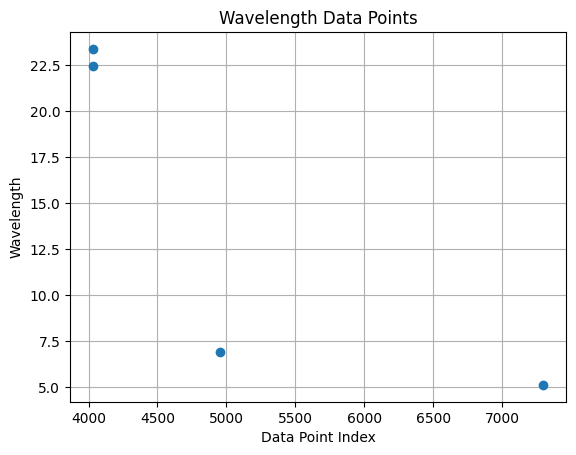

In [57]:
from astropy.io import fits

# Path to your FITS file
file_path = '/Users/jakereinheimer/Desktop/Fakhri/sdss_dr7/spectro/ss_tar_26/0960/spSpec/spSpec-52466-0960-100.fit'

# Open the FITS file
with fits.open(file_path) as hdul:
    # Access the BinTableHDU where wavelength data is stored (assuming it's HDU 1 based on your description)
    wavelength_data = hdul[1].data['wave']  # Replace 'wave' with the correct column name if different
    height_data = hdul[1].data['height']

    # Now 'wavelength_data' holds the wavelength array
    print(wavelength_data)
    print(height_data)

    # If you want to use this data further in an analysis or plot it:
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(wavelength_data,height_data, marker='o', linestyle='none')  # Simple plot to visualize the wavelengths
    plt.xlabel('Data Point Index')
    plt.ylabel('Wavelength')
    plt.title('Wavelength Data Points')
    plt.grid(True)
    plt.show()


0.0
[3.         3.         3.         ... 0.42509124 1.5020962  2.0846307 ]
[[3.         3.         3.         ... 0.42509124 1.50209618 2.08463073]]


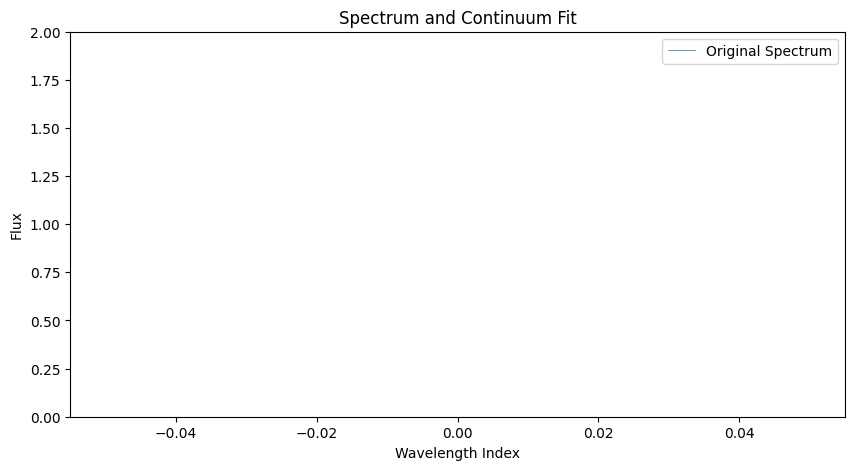

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from astropy.io import fits  # To handle FITS files if your data are in this format

def get_data(file,test=False):

    if test==False:
        with fits.open(file) as hdul:

            spectral_data = hdul[0].data  # Change the index if your data is in a different extension

            return spectral_data
        
    else:
        # Load the FITS file
        file_path = '/Users/jakereinheimer/Desktop/Fakhri/data/test/Norm-J0235-2433Ab_flx.fits'  # Replace with the actual path to your FITS file
        with fits.open(file_path) as hdul:
            # Print information about the FITS file structure (optional, for inspection)
            hdul.info()

            # Access the primary data (assuming it's in the first HDU, usually HDU[0])
            data = hdul[0].data  # This loads the data from the first HDU

        # Convert FITS data to a NumPy array
        data_array = np.array(data)

        # Now, data_array is a NumPy array containing the FITS data
        return data_array
    
spectra = get_data('/Users/jakereinheimer/Desktop/Fakhri/data/test/test_f.fits')
for i,point in enumerate(spectra):
    if point<0:
        spectra[i]=0

    if point>3:
        spectra[i]=3

print(np.min(spectra))
    
def apply_nmf(spectra, n_components=12):
    model = NMF(n_components=n_components, init='random', random_state=0)
    W = model.fit_transform(spectra.reshape(-1, 1))
    H = model.components_
    return W, H

# Decompose the spectral data
W, H = apply_nmf(spectra)

# Reconstruct the spectra
reconstructed_spectra = np.dot(W, H)

# Compute residuals
residuals = spectra - reconstructed_spectra

reconstructed_spectra=reconstructed_spectra.reshape(1,-1)
print(spectra)
print(reconstructed_spectra)

# Plot original and reconstructed spectra for comparison
def plot_spectra(original, reconstructed, index):
    plt.figure(figsize=(10, 5))
    plt.plot(original[index], label='Original Spectrum',linewidth=.5)
    #plt.plot(reconstructed[index], label='Reconstructed Spectrum',linewidth=.5)
    plt.legend()
    plt.xlabel('Wavelength Index')
    plt.ylabel('Flux')
    plt.title('Spectrum and Continuum Fit')
    plt.ylim(0,2)
    plt.show()

# Example: Plot the first spectrum and its reconstruction
plot_spectra(spectra, reconstructed_spectra, 0)



In [27]:
import pickle

from AbsorptionLine import AbsorptionLine

# Assuming you have an instance of AbsorptionLine
abs_line = AbsorptionLine(wavelength=np.array([5000, 5001]), flux=np.array([1.0, 0.9]), errors=[0.1, 0.1])

# Try to pickle and unpickle
pickled_data = pickle.dumps(abs_line)
new_abs_line = pickle.loads(pickled_data)

print(new_abs_line.number_of_zeros_flux)  # Check if the object looks correct


0


In [30]:
from astropy.io import fits

# Open the FITS file
with fits.open('/Users/jakereinheimer/Desktop/Fakhri/VPFit/test/filename.fits',ignore_missing_simple=True) as hdul:
    data = hdul[1].data  # Assuming the primary HDU contains the image
    print(data)
    wavelength = data['wavelength']  # This column name might vary
    flux = data['flux']
    flux_err = data['flux_err']  # Check the actual column name for errors


    Header size is not multiple of 2880: 169
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


OSError: Empty or corrupt FITS file

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import pandas as pd
from astropy.io import fits


#get vpfit atomic transisitions
atoms=[]
transisitions=[]

with open('/Users/jakereinheimer/Desktop/Fakhri/atom_db.dat','r') as f:
    content=f.readlines()

    content=content[9:]

    for row in content:

        if row[0]=="!":
            break

        atom=row[:row.find(";")]

        atoms.append(atom)

        new_line=row[row.find(";")+1:]

        while new_line[0]==" ":
            new_line=new_line[1:]

        transisition=new_line[:new_line.find(" "):]

        transisitions.append(float(transisition))

df=pd.DataFrame({
    "Atomic Transisitions":atoms,
    "Emission Line":transisitions
})

print(len(transisitions))

print(len(atoms))



def get_data(file):
    with fits.open(file) as hdul:
        #header = hdul[0].header
        #print(header)
        #hdul.info()  # This will print information about all the extensions in your FITS file

       # print(help(hdul))

        #print(hdul[0].data)

        # Assuming your spectral data is in the first extension
        spectral_data = hdul[0].data  # Change the index if your data is in a different extension

        return spectral_data

def normalize(data):

    # Min-Max scaling
    min_val = np.min(data)
    max_val = np.max(data)

    scaled_data = (data - min_val) / (max_val - min_val)

    return scaled_data

test_file='/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J000520+052410/Sargent_Oct_12_13_14_1999/'
lower_lim=3307
upper_lim=4849

data=get_data(test_file+'J000520+052410_f.fits')
wavelength = np.linspace(lower_lim,upper_lim,len(data))
error=get_data(test_file+'J000520+052410_e.fits')

normalized_data = normalize(data)
normalized_error = normalize(error)

# Interactive plot function
def plot_spectrum(redshift):
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, normalized_data, label='Observed Spectrum', color='blue', linewidth=0.5)
    plt.ylim(0, 1)
    plt.xlim(3307, 4849)
    for i, atom in enumerate(atoms):
        redshifted_wavelength = transisitions[i] * (1 + redshift)
        plt.axvline(redshifted_wavelength, linestyle='--', color='red', label=f'{atom} (z={redshift:.3f})')
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.title('Interactive Absorption Spectrum')
    plt.xlim(3300,3500)
    #plt.legend()
    plt.show()

# Create sliders and interact function
redshift_slider = FloatSlider(value=0.1027, min=2.5, max=3, step=0.00001, description='Redshift', readout_format='.4f')
interact(plot_spectrum, redshift=redshift_slider)


637
637


interactive(children=(FloatSlider(value=2.5, description='Redshift', max=3.0, min=2.5, readout_format='.4f', s…

<function __main__.plot_spectrum(redshift)>

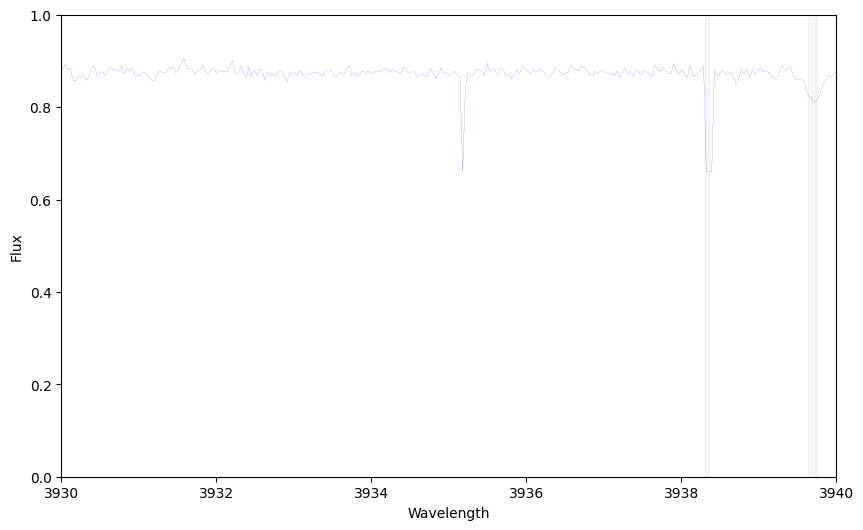

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import pandas as pd
from astropy.io import fits

redshift=2.6


#get vpfit atomic transisitions
atoms=[]
transisitions=[]

with open('/Users/jakereinheimer/Desktop/Fakhri/atom_db.dat','r') as f:
    content=f.readlines()

    content=content[9:]

    for row in content:

        if row[0]=="!":
            break

        atom=row[:row.find(";")]

        atoms.append(atom)

        new_line=row[row.find(";")+1:]

        while new_line[0]==" ":
            new_line=new_line[1:]

        transisition=new_line[:new_line.find(" "):]

        transisitions.append(float(transisition))

df=pd.DataFrame({
    "Atomic Transisitions":atoms,
    "Emission Line":transisitions
})



def get_data(file):
    with fits.open(file) as hdul:
        spectral_data = hdul[0].data  # Change the index if your data is in a different extension
        return spectral_data

def normalize(data):

    # Min-Max scaling
    min_val = np.min(data)
    max_val = np.max(data)

    scaled_data = (data - min_val) / (max_val - min_val)

    return scaled_data

#loat the actual data
test_file='/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J000520+052410/Sargent_Oct_12_13_14_1999/'
lower_lim=3307
upper_lim=4849

data=get_data(test_file+'J000520+052410_f.fits')
wavelength = np.linspace(lower_lim,upper_lim,len(data))
error=get_data(test_file+'J000520+052410_e.fits')

normalized_data = normalize(data)
normalized_error = normalize(error)


# find absorption points
absorptions=[]

deviation=np.std(normalized_data)
mean=np.mean(normalized_data)

flux_change=[]
for i,point in enumerate(normalized_data):
    
    if i==0:
        flux_change.append(0.)
        continue
    
    if i == (len(normalized_data)-1):
        break
    
    flux_change.append(normalized_data[i]-normalized_data[i+1])
    
    if point<=(mean-deviation):
        
        if flux_change[i]==0:
            absorptions.append(wavelength[i])

        
        elif abs(round(flux_change[i-1],1))==round(flux_change[i],1):
            absorptions.append(wavelength[i])
            

plt.figure(figsize=(10, 6))
plt.plot(wavelength, normalized_data, 'b', label='Observed Spectrum',linewidth=.1)

for i,atom in enumerate(atoms):
    redshifted_wavelength = transisitions[i] * (1 + redshift)
    plt.axvline(redshifted_wavelength,linestyle='--', color='red',linewidth=.5)
    
for i,line in enumerate(absorptions):
    plt.axvline(line,linestyle='--', color='black',linewidth=.1)

plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.ylim(0,1)
plt.xlim(lower_lim,upper_lim)
plt.xlim(3930,3940)
#plt.legend()
plt.show()



In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

#loat the actual data
test_file='/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J000520+052410/Sargent_Oct_12_13_14_1999/'
lower_lim=3307
upper_lim=4849

flux=get_data(test_file+'J000520+052410_f.fits')
wavelength = np.linspace(lower_lim,upper_lim,len(data))
error=get_data(test_file+'J000520+052410_e.fits')

normalized_data = normalize(data)
normalized_error = normalize(error)


# We invert the flux to find minima as peaks
inverted_flux = -flux
peaks, _ = find_peaks(inverted_flux, height=-0.8)  # height parameter may need adjustment based on your data

def plot_spectrum(width,start):
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(wavelength, flux, label='Original Data',linewidth=.5)
    plt.scatter(wavelength[peaks], flux[peaks], color='green', s=50, label='Detected Absorptions')
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.title('Absorption Spectrum Analysis')
    plt.xlim(start,start+width)
    plt.legend()
    plt.show()

# Create sliders and interact function
width_slider = FloatSlider(value=20, min=0, max=upper_lim-lower_lim, step=0.00001, description='Width', readout_format='.4f')
start_slider = FloatSlider(value=lower_lim, min=lower_lim, max=upper_lim-10, step=0.00001, description='Left Edge', readout_format='.4f')
interact(plot_spectrum, width=width_slider,start=start_slider)


interactive(children=(FloatSlider(value=20.0, description='Width', max=1542.0, readout_format='.4f', step=1e-0…

<function __main__.plot_spectrum(width, start)>

In [ ]:
#aperature method

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

#loat the actual data
test_file='/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J000520+052410/Sargent_Oct_12_13_14_1999/'
lower_lim=3307
upper_lim=4849

flux=get_data(test_file+'J000520+052410_f.fits')
wavelength = np.linspace(lower_lim,upper_lim,len(data))
error=get_data(test_file+'J000520+052410_e.fits')

std=np.std(normalized_data)
mean=np.mean(normalized_data)

N=1

guess_points=[]
for i,point in enumerate(normalized_data):
    
    D=1-(point/mean)
    sigma_D=((point/mean)**2)*(((error[i]/point)**2)+((np.mean(error)/mean)**2))
    
    w=-
    
    if (point/std)>N:

In [ ]:
#aperature method

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

#loat the actual data
test_file='/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J000520+052410/Sargent_Oct_12_13_14_1999/'
lower_lim=3307
upper_lim=4849

flux=get_data(test_file+'J000520+052410_f.fits')
wavelength = np.linspace(lower_lim,upper_lim,len(data))
error=get_data(test_file+'J000520+052410_e.fits')

std=np.std(normalized_data)
mean=np.mean(normalized_data)

p=5

n = len(flux)
equivalent_widths = np.zeros(n)

# Calculate equivalent width for each pixel in the spectrum
for i in range(p, n-p):
    D = spectrum[i-p:i+p+1]  # Flux decrement in the aperture
    lambda_interval = np.arange(-p, p+1)  # Placeholder for actual wavelength intervals
    equivalent_widths[i] = -np.sum(D * lambda_interval)
    


In [63]:
#aperature method

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks


absorption_lines=[]
class absorption_line:
    
    def __init__(self,start,stop):
        
        self.start=start
        self.stop=stop
        
        self.points_within=[]
        

#loat the actual data
test_file='/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J000520+052410/Sargent_Oct_12_13_14_1999/'
lower_lim=3307
upper_lim=4849

flux=get_data(test_file+'J000520+052410_f.fits')
wavelength = np.linspace(lower_lim,upper_lim,len(data))
dist=abs(wavelength[0]-wavelength[1])
error=get_data(test_file+'J000520+052410_e.fits')

std=np.std(flux)
mean=np.mean(error)

N=5

values=[]
for i,point in enumerate(flux):
    
    if abs(mean-point)>=(N*std):
        
        values.append((wavelength[i],point))
        
    
        
        
        
for i,point in enumerate(values):
    
    start=point
    
    if abs(point[0]-values[i+1][0])>dist:
        

print(values)

        
    
        

[(3319.3994291927156, 1.0072865), (3319.539141070943, 1.056769), (3319.5740690405, 1.0042602), (3319.608997010057, 1.2538503), (3319.643924979614, 0.9837525), (3319.818564827399, 1.0324408), (3319.9582767056263, 1.008342), (3320.0281326447403, 1.4811491), (3320.0630606142972, 1.2048857), (3320.097988583854, 1.0496755), (3320.132916553411, 1.0715328), (3320.202772492525, 1.0621), (3320.307556401196, 1.0149281), (3320.37741234031, 0.9855052), (3320.447268279424, 1.0636162), (3320.482196248981, 1.0150394), (3320.5869801576514, 1.1240764), (3320.6917640663223, 1.2549634), (3320.7266920358793, 0.9872892), (3320.83147594455, 1.0641536), (3320.866403914107, 0.99584466), (3320.901331883664, 1.0143042), (3320.936259853221, 1.0316157), (3320.971187822778, 1.2090976), (3321.006115792335, 1.1500071), (3321.7396031530307, 1.1004211), (3321.7745311225876, 1.1202136), (3321.8094590921446, 0.9821615), (3321.8793150312586, 1.2052629), (3321.9142430008155, 1.0983359), (3321.9840989399295, 1.0324262), (3

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from astropy.io import fits

class AbsorptionLine:
    def __init__(self, start, stop):
        self.start = start
        self.stop = stop
        self.points_within = []  # This will hold tuples of (wavelength, flux)

    def add_point(self, wl, fl):
        self.points_within.append((wl, fl))
        
#loat the actual data
test_file='/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J000520+052410/Sargent_Oct_12_13_14_1999/'
lower_lim=3307
upper_lim=4849

flux=get_data(test_file+'J000520+052410_f.fits')
wavelength = np.linspace(lower_lim,upper_lim,len(data))
error=get_data(test_file+'J000520+052410_e.fits')

std=np.std(flux)
mean=np.mean(flux)

# Detection threshold
N = 1
threshold = mean - (N * std)

# Detect potential absorption features below the threshold
values = [(wl, fl) for wl, fl in zip(wavelength, flux) if fl <= threshold]

# Identify continuous regions forming absorption lines
absorption_lines = []
if values:
    start_idx = 0
    for i in range(1, len(values)):
        # Check if the next point is not contiguous or last point
        if values[i][0] - values[i-1][0] > 1 or i == len(values) - 1:
            stop_idx = i-1 if i == len(values) - 1 else i-1
            new_line = AbsorptionLine(values[start_idx][0], values[stop_idx][0])
            for j in range(start_idx, stop_idx + 1):
                new_line.add_point(*values[j])
            absorption_lines.append(new_line)
            start_idx = i
    # Handle the last point if it's a single-point line
    if start_idx == len(values) - 1:
        new_line = AbsorptionLine(values[start_idx][0], values[start_idx][0])
        new_line.add_point(*values[start_idx])
        absorption_lines.append(new_line)

def plot_spectrum(width,start):
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(wavelength, flux, label='Spectrum')
    for line in absorption_lines:
        plt.axvline(x=line.start, color='r', linestyle='--', label='Line Start')
        plt.axvline(x=line.stop, color='g', linestyle='--', label='Line Stop')
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.title('Absorption Lines Detected')
    plt.xlim(start,start+width)
    #plt.legend()
    plt.show()

# Create sliders and interact function
width_slider = FloatSlider(value=20, min=1, max=upper_lim-lower_lim, step=0.00001, description='Width', readout_format='.4f')
start_slider = FloatSlider(value=lower_lim, min=lower_lim, max=upper_lim-10, step=0.00001, description='Left Edge', readout_format='.4f')
interact(plot_spectrum, width=width_slider,start=start_slider)



for line in absorption_lines:
    plt.plot

'''# Plot the spectrum with marked absorption lines
plt.figure(figsize=(10, 6))
plt.plot(wavelength, flux, label='Spectrum')
for line in absorption_lines:
    plt.axvline(x=line.start, color='r', linestyle='--', label='Line Start')
    plt.axvline(x=line.stop, color='g', linestyle='--', label='Line Stop')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Absorption Lines Detection')
#plt.legend()
plt.show()'''

interactive(children=(FloatSlider(value=20.0, description='Width', max=1542.0, min=1.0, readout_format='.4f', …

[(3307.0, 0.0), (3307.034927969557, 0.0), (3307.069855939114, 0.0), (3307.104783908671, 0.0), (3307.139711878228, 0.0), (3307.174639847785, 0.0), (3307.209567817342, 0.0), (3307.244495786899, 0.0), (3307.2794237564553, 0.0), (3307.3143517260123, 0.0), (3307.3492796955693, 0.0), (3307.3842076651263, 0.0), (3307.4191356346832, 0.0), (3307.45406360424, 0.0), (3307.488991573797, 0.0), (3307.523919543354, 0.0), (3307.558847512911, 0.0), (3307.593775482468, 0.0), (3307.628703452025, 0.0), (3307.663631421582, 0.0), (3307.698559391139, 0.0), (3307.733487360696, 0.0), (3307.768415330253, 0.0), (3307.8033432998095, 0.0), (3307.8382712693665, 0.0), (3307.8731992389235, 0.0), (3307.9081272084804, 0.0), (3307.9430551780374, 0.0), (3307.9779831475944, 0.0), (3308.0129111171514, 0.0), (3308.0478390867083, 0.0), (3308.0827670562653, 0.0), (3308.1176950258223, 0.0), (3308.1526229953793, 0.0), (3308.1875509649362, 0.0), (3308.222478934493, 0.0), (3308.25740690405, 0.0), (3308.292334873607, 0.0), (3308.3

"# Plot the spectrum with marked absorption lines\nplt.figure(figsize=(10, 6))\nplt.plot(wavelength, flux, label='Spectrum')\nfor line in absorption_lines:\n    plt.axvline(x=line.start, color='r', linestyle='--', label='Line Start')\n    plt.axvline(x=line.stop, color='g', linestyle='--', label='Line Stop')\nplt.xlabel('Wavelength')\nplt.ylabel('Flux')\nplt.title('Absorption Lines Detection')\n#plt.legend()\nplt.show()"

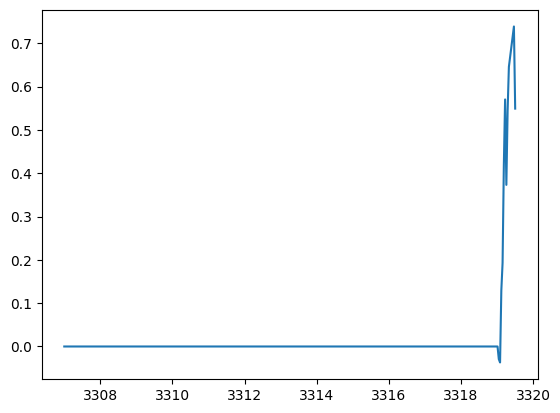

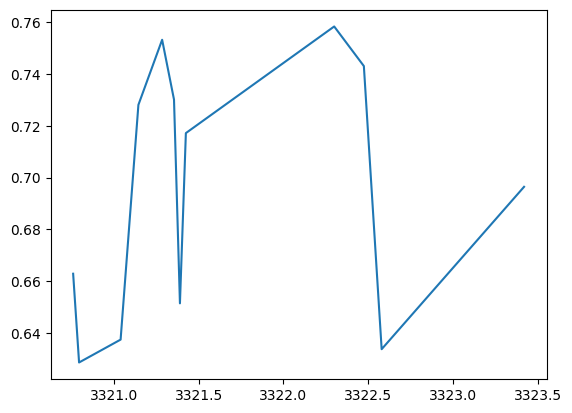

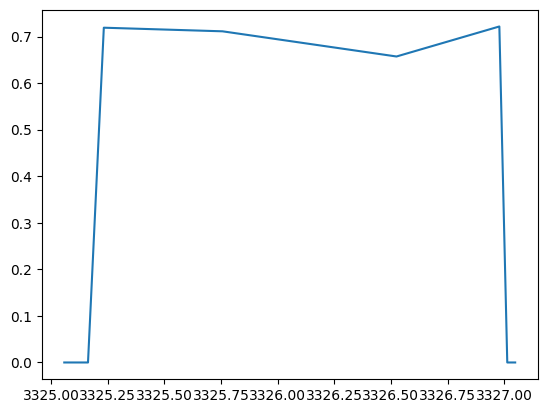

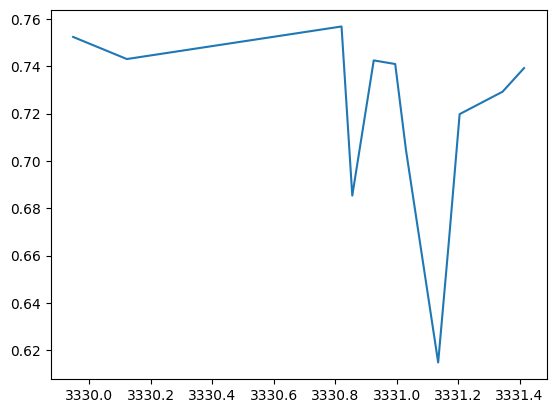

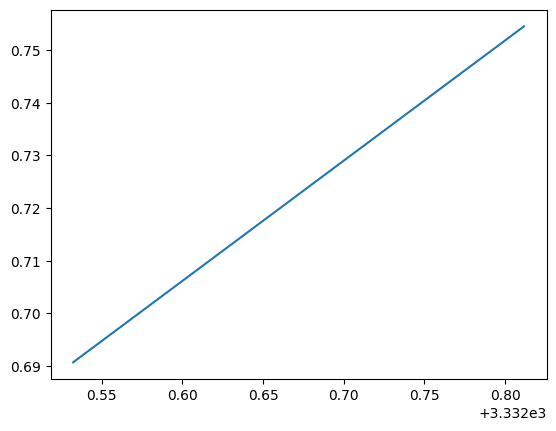

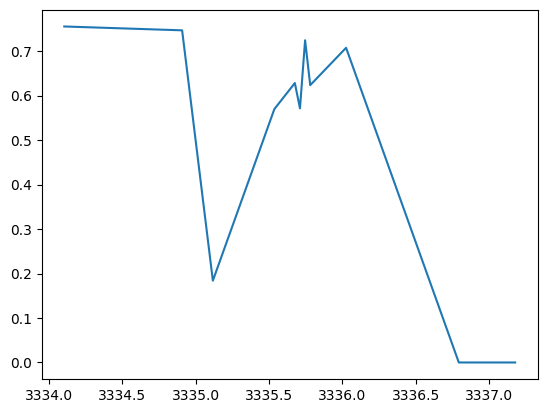

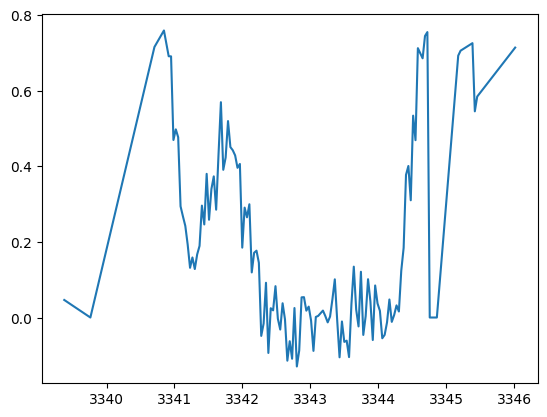

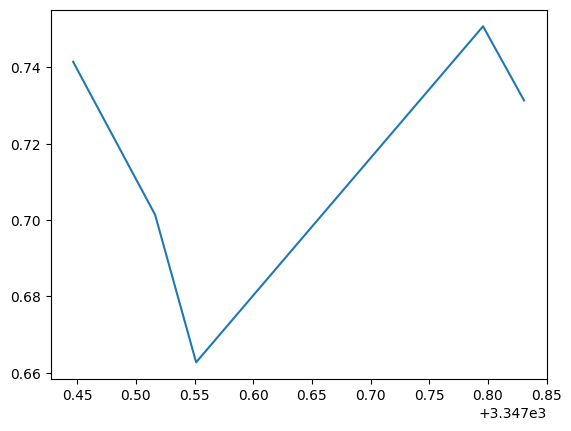

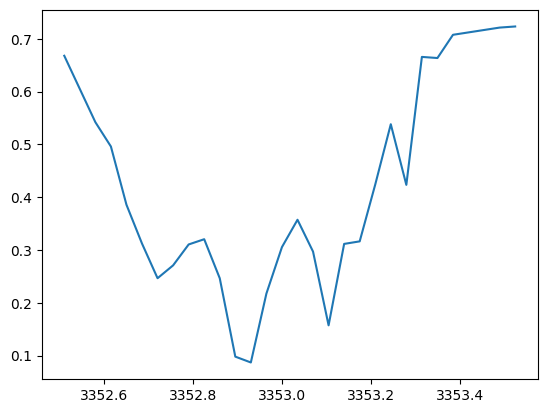

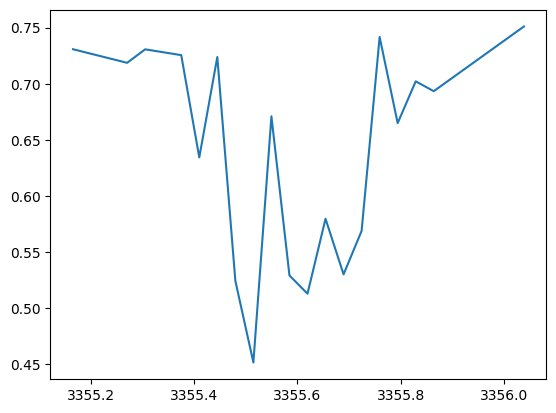

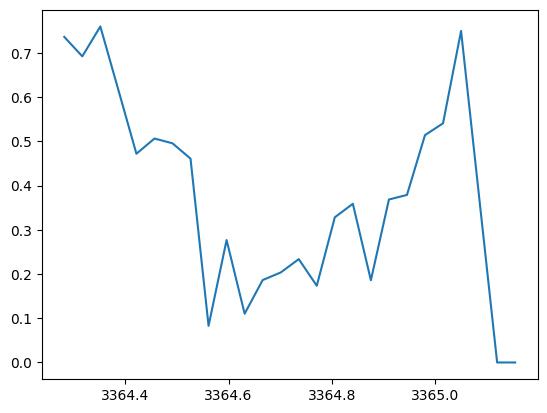

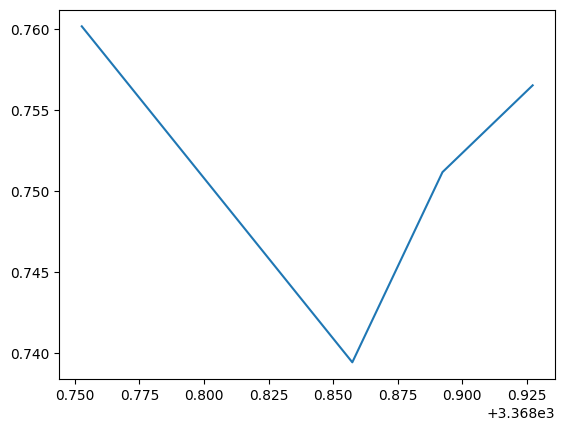

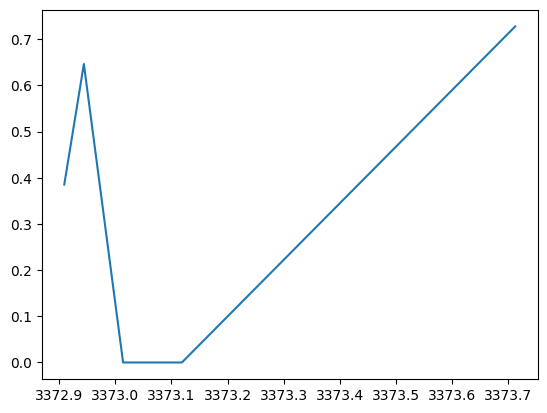

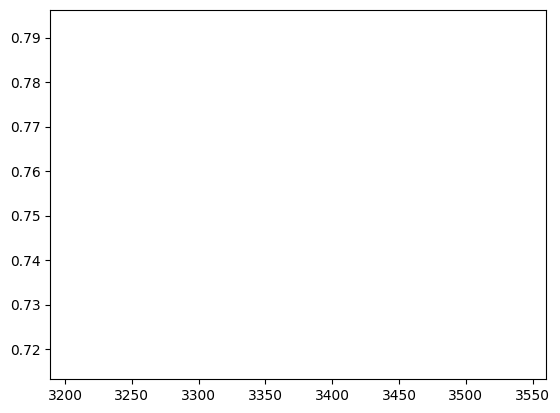

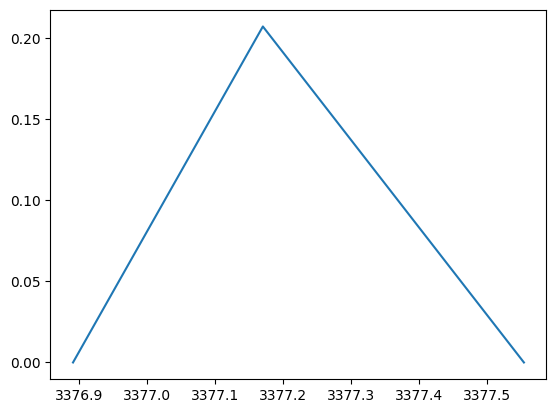

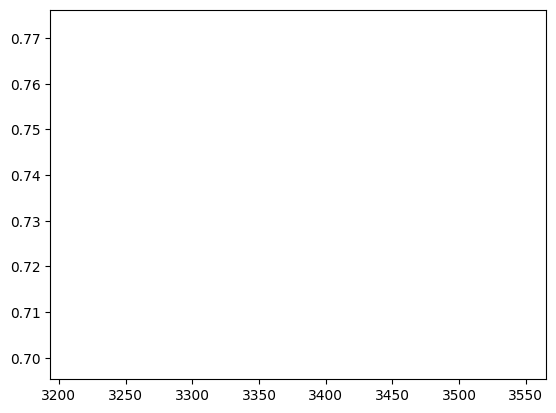

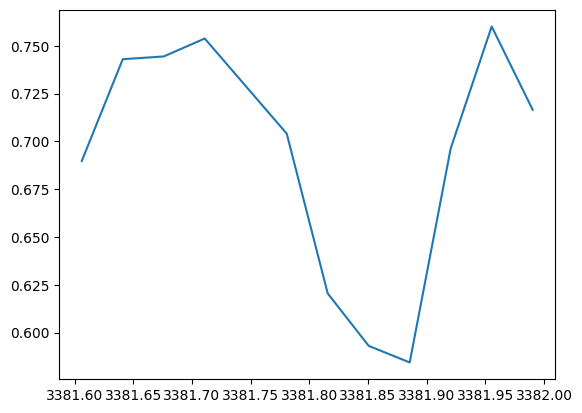

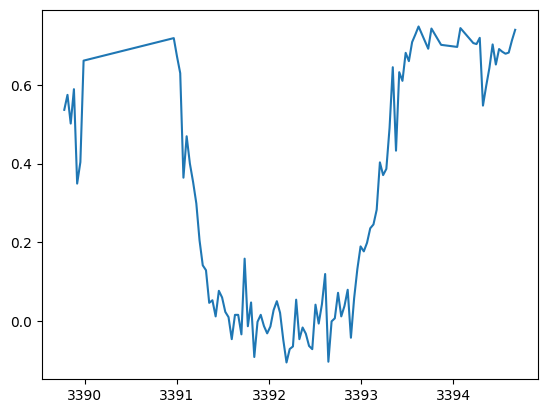

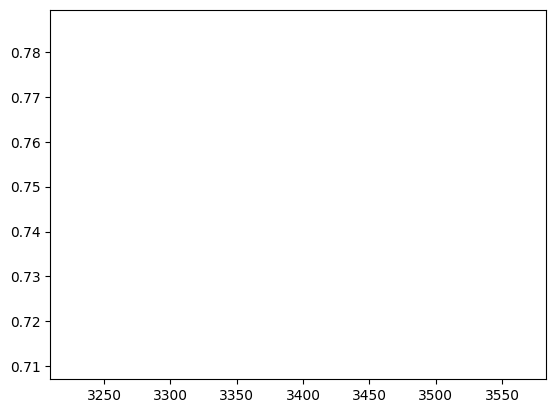

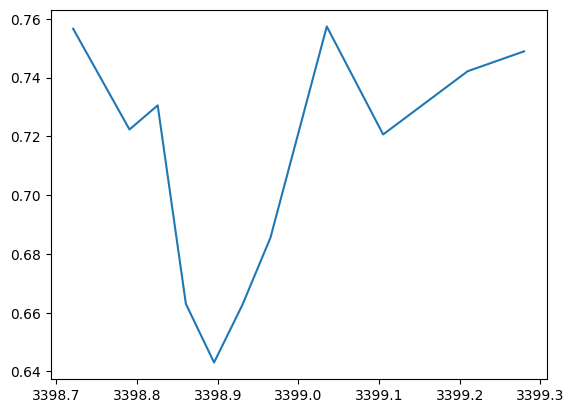

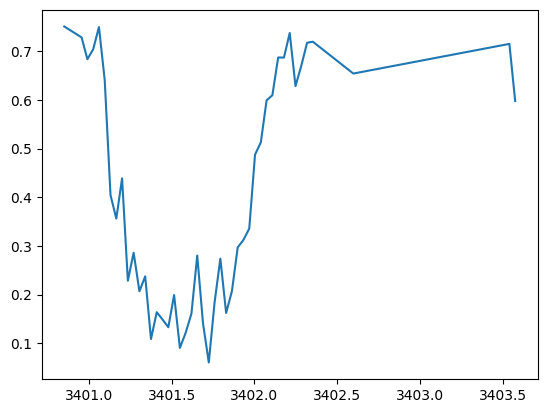

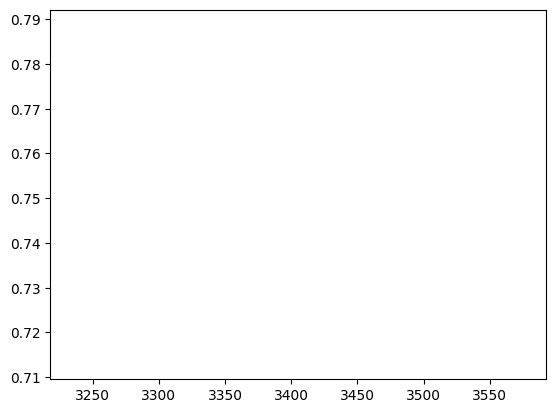

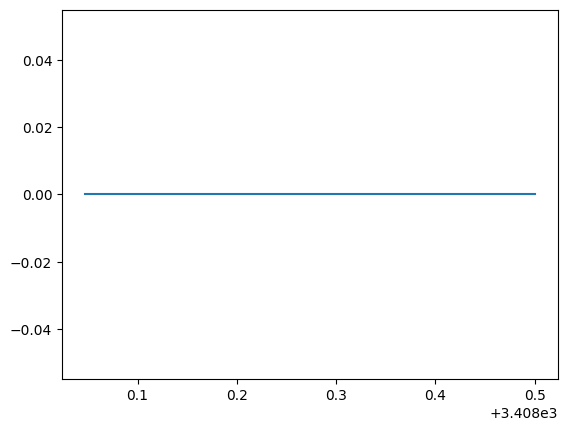

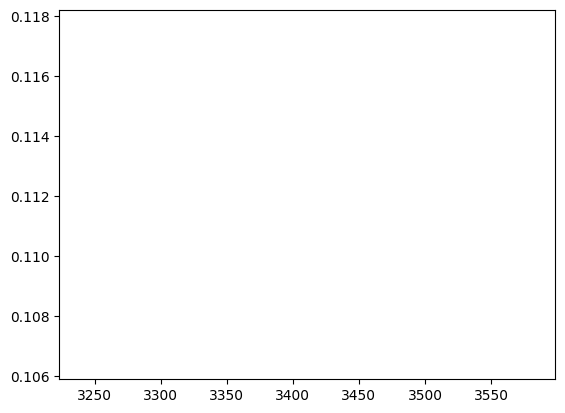

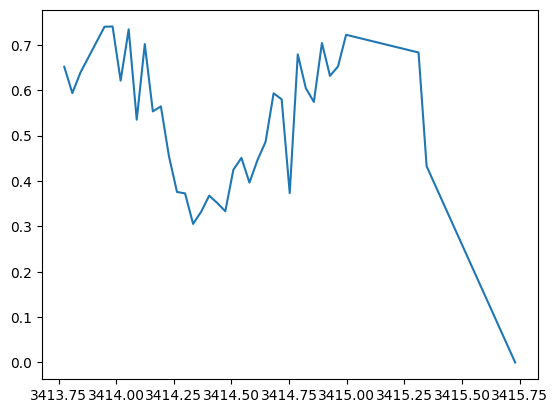

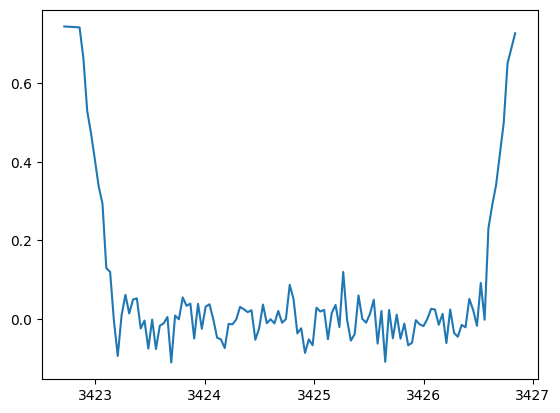

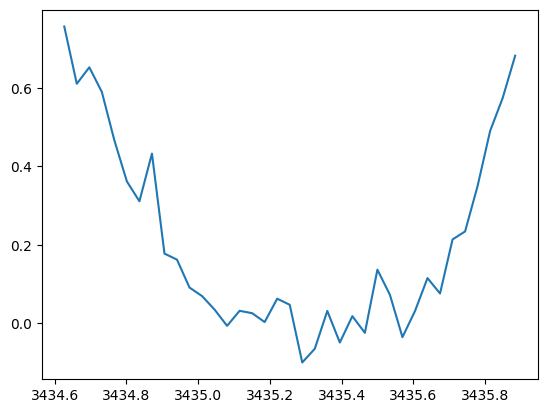

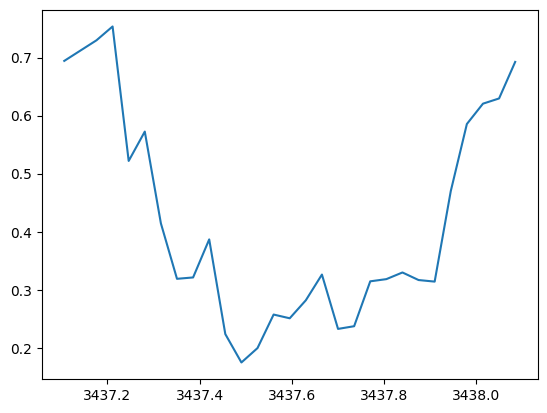

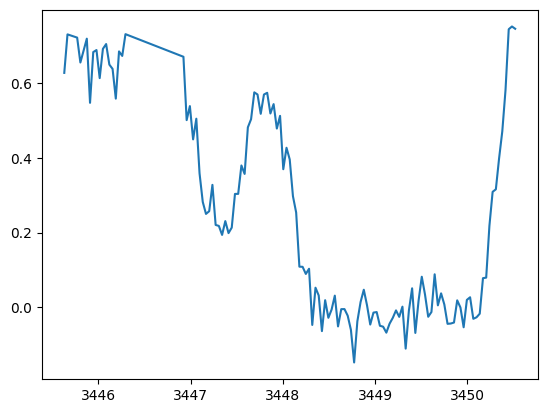

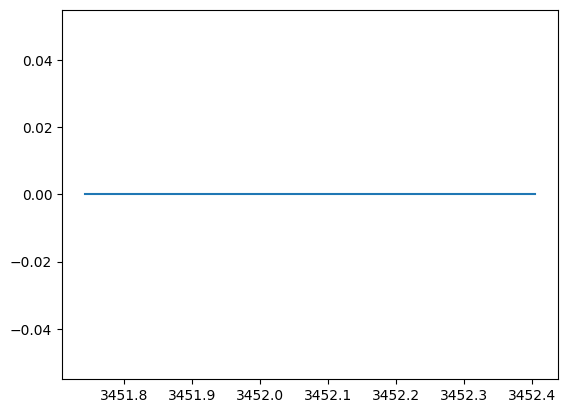

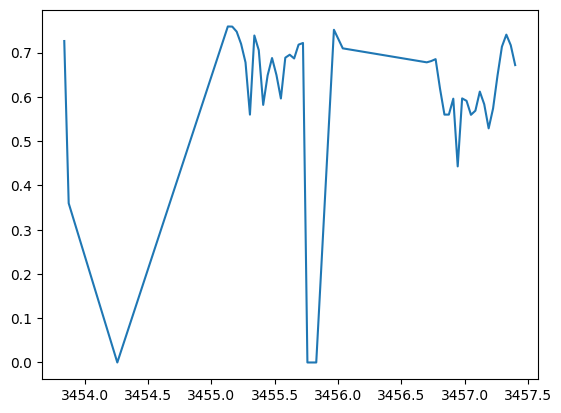

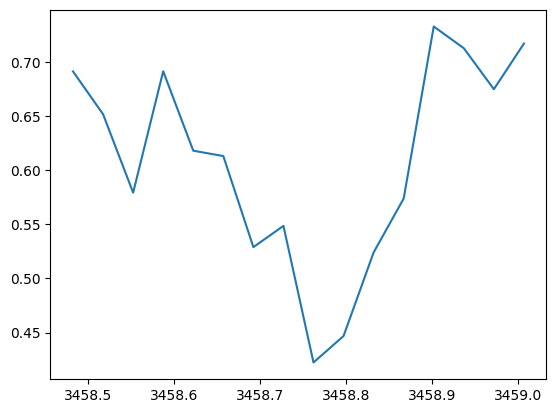

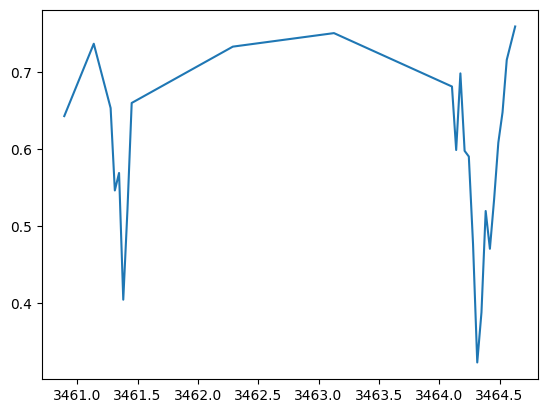

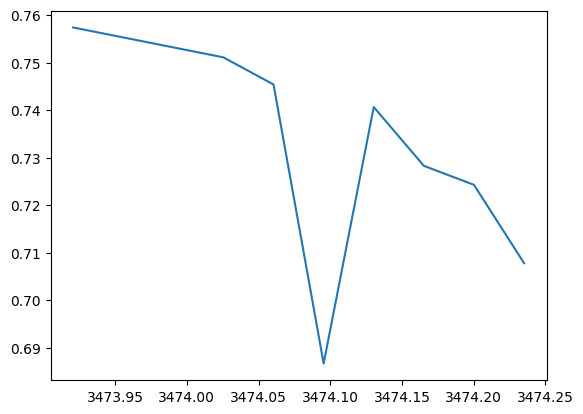

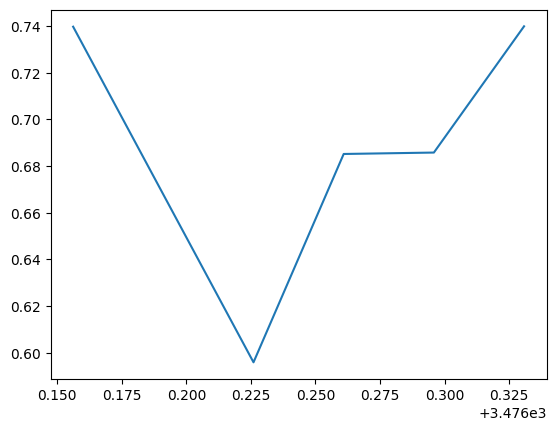

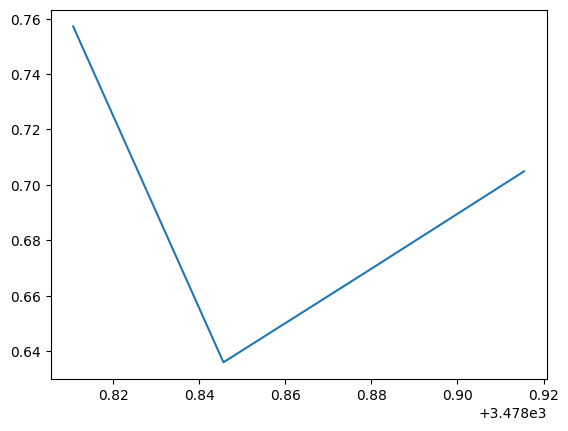

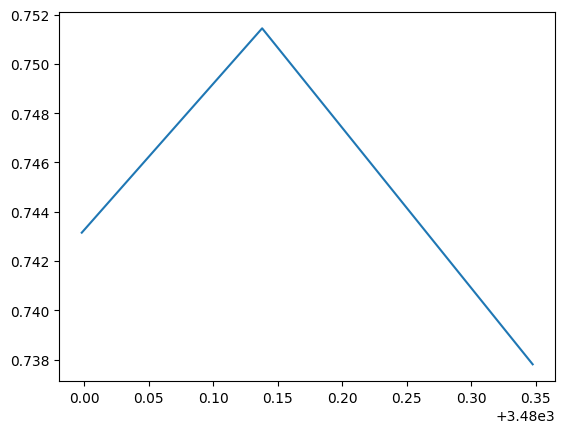

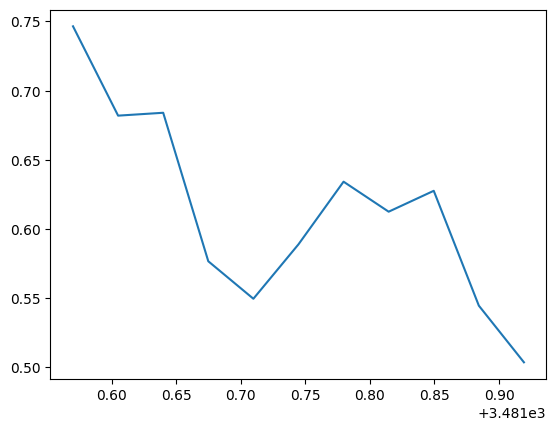

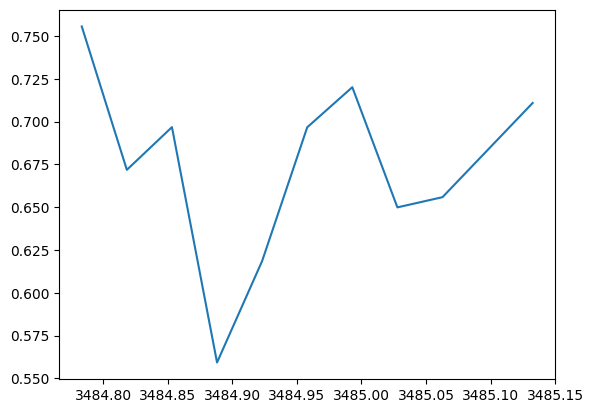

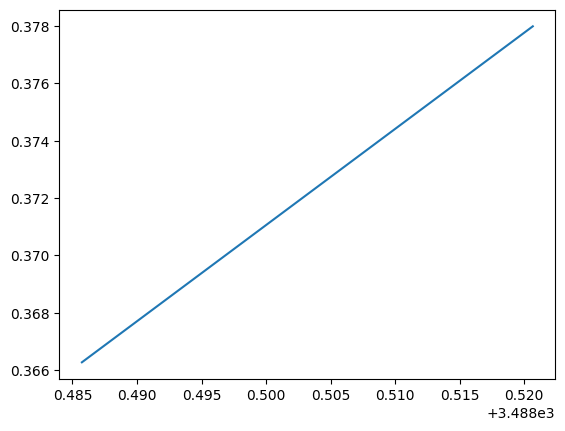

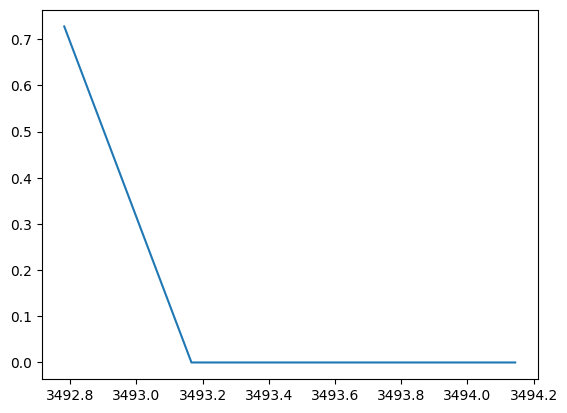

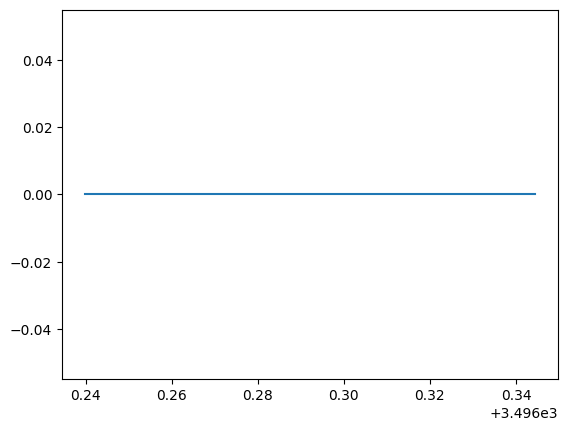

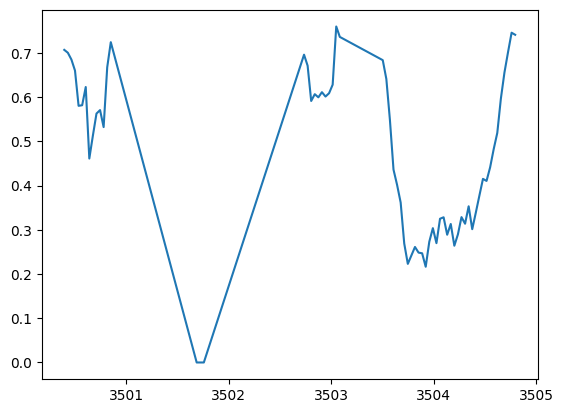

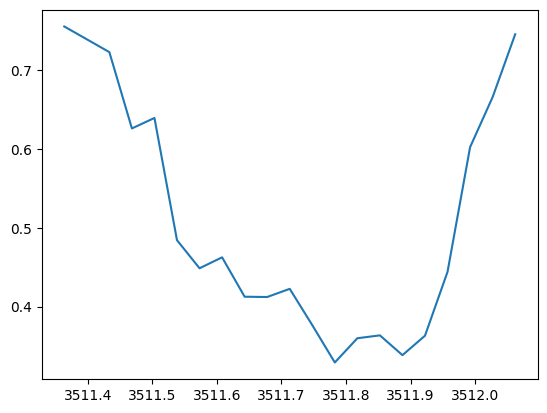

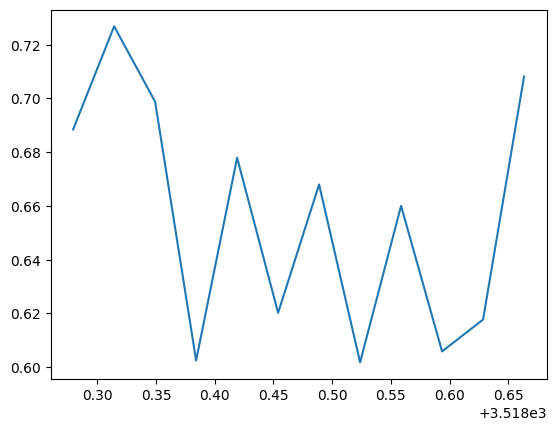

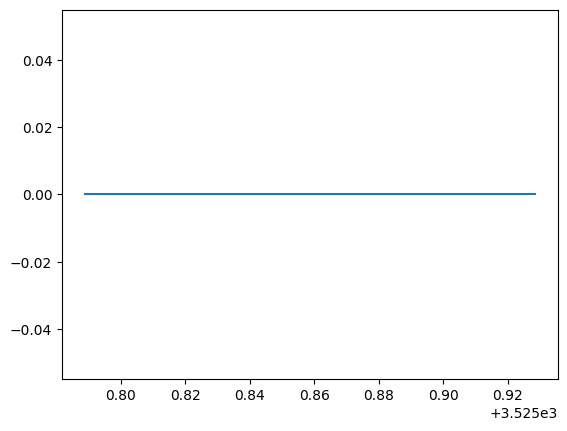

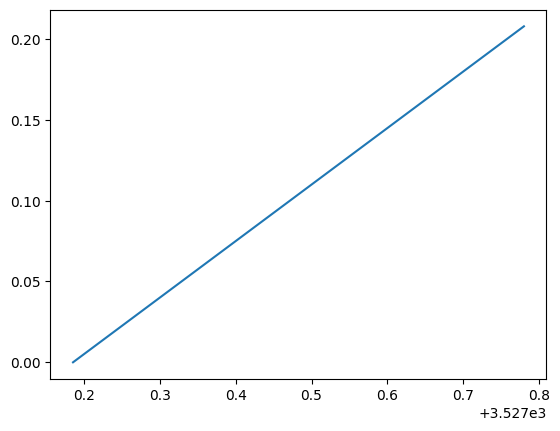

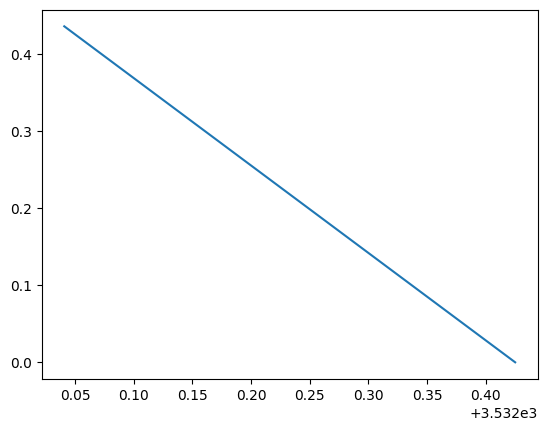

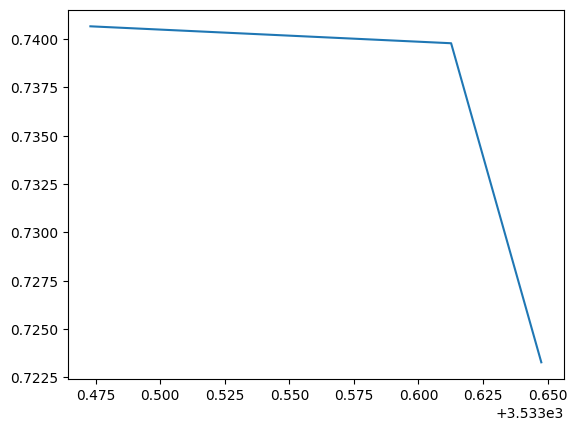

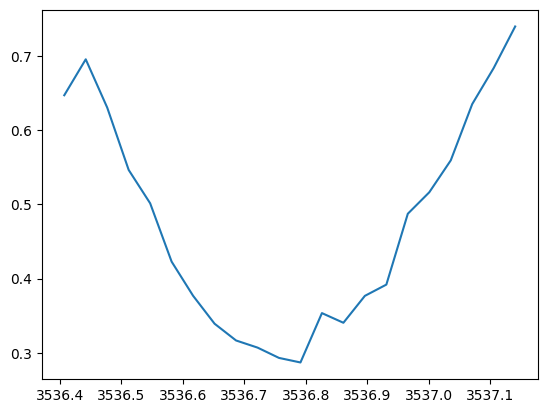

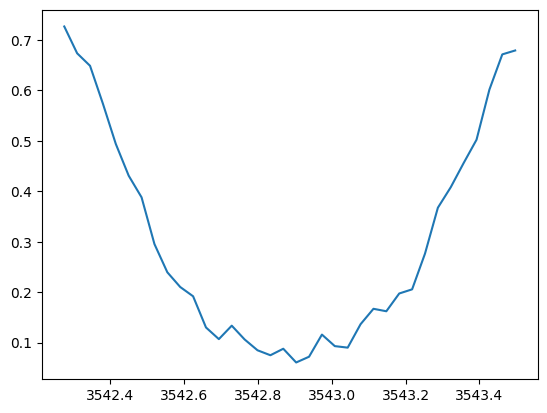

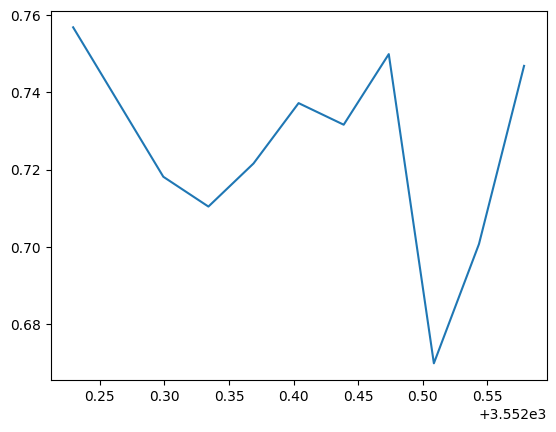

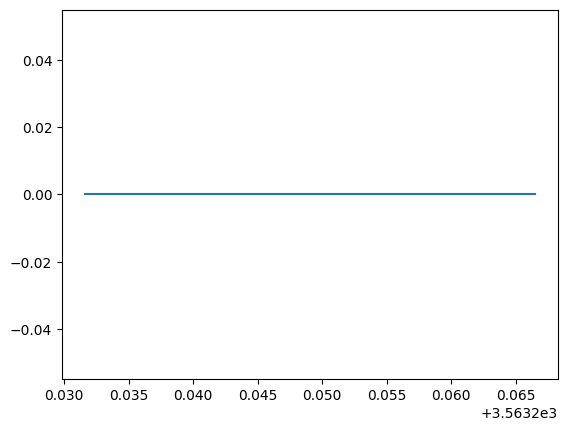

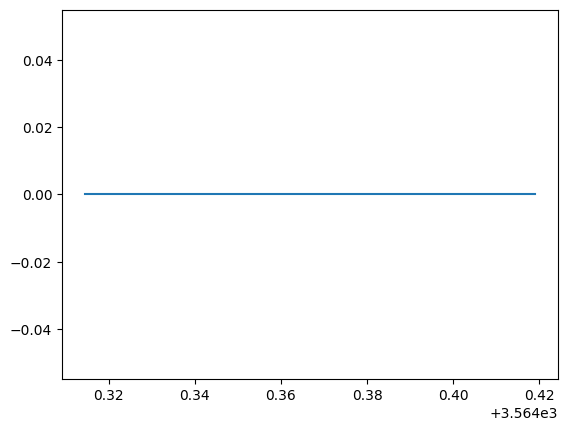

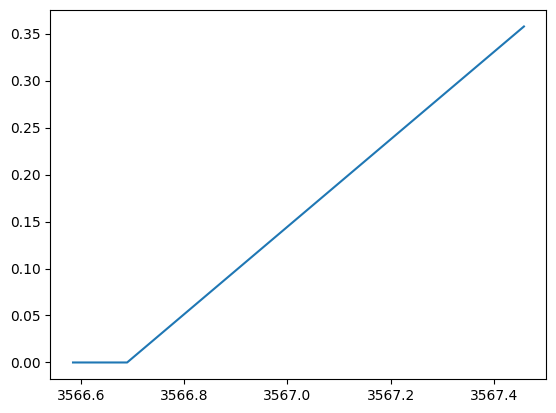

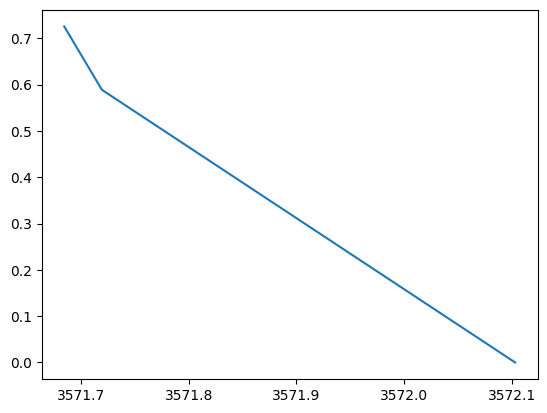

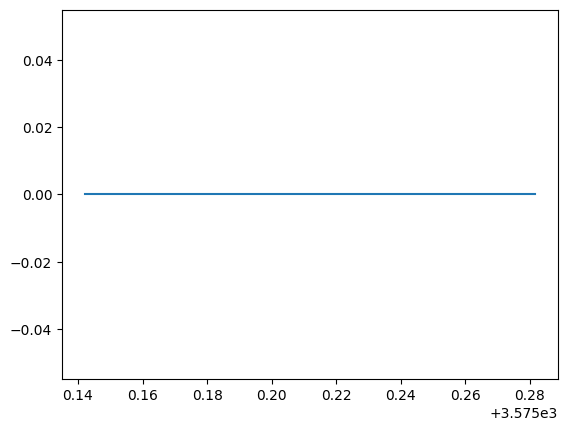

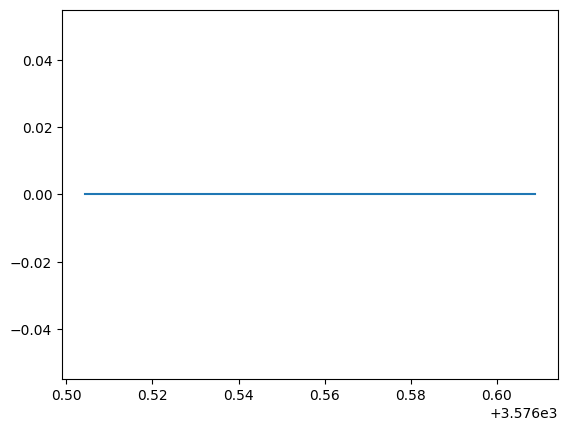

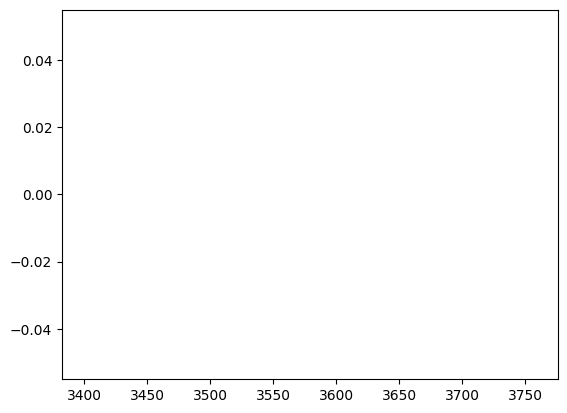

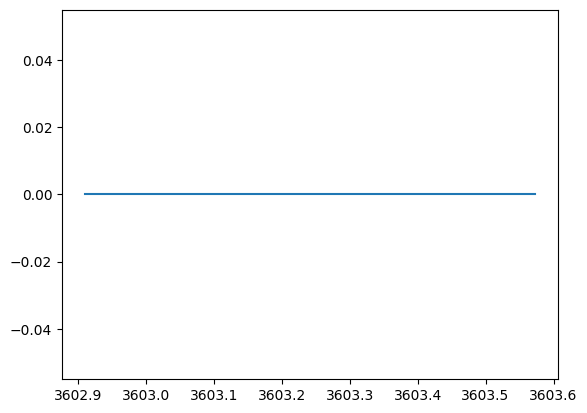

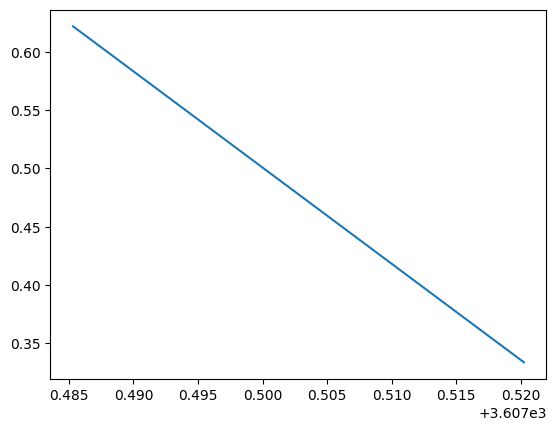

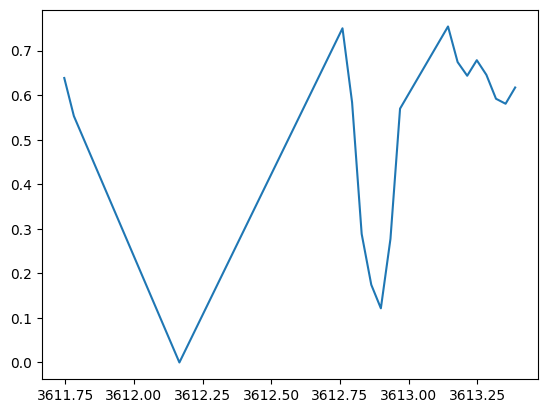

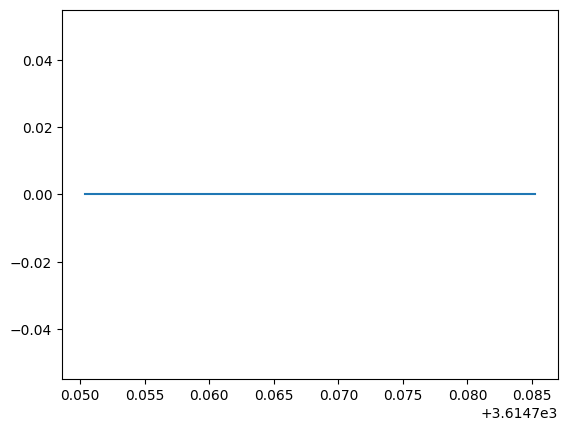

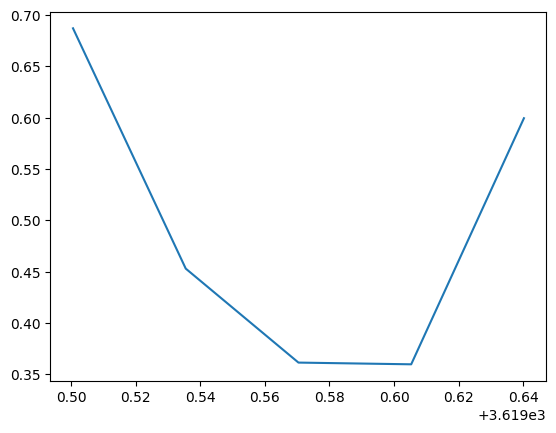

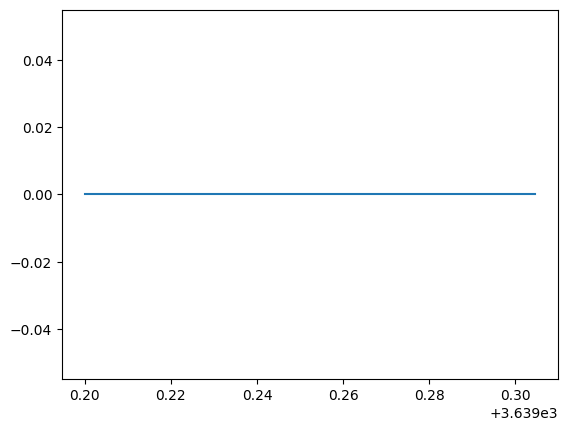

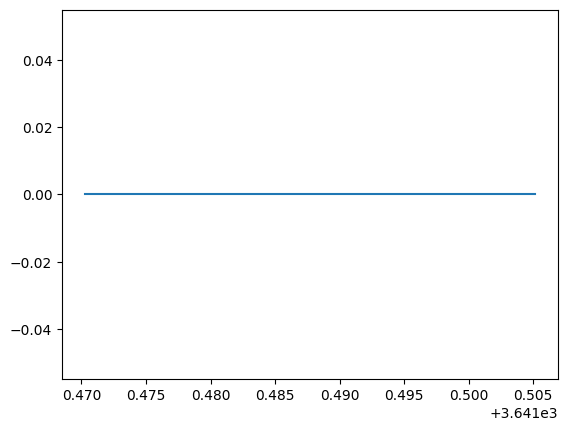

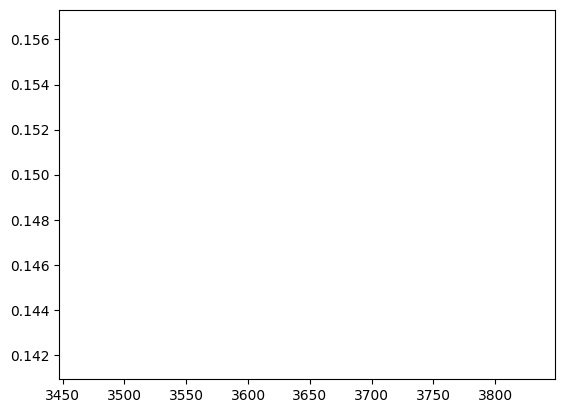

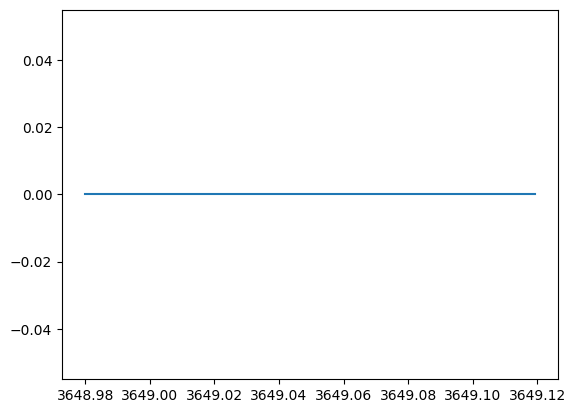

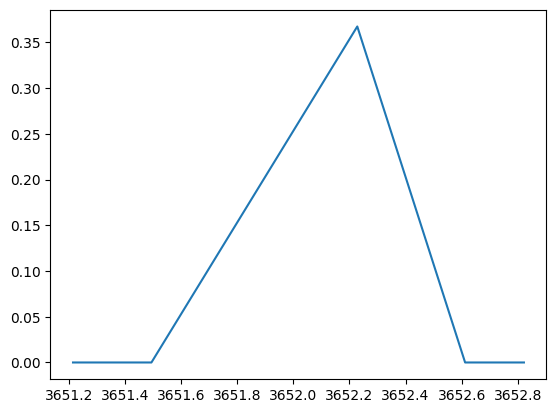

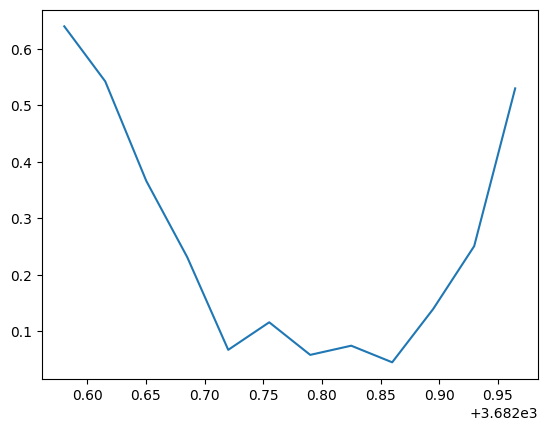

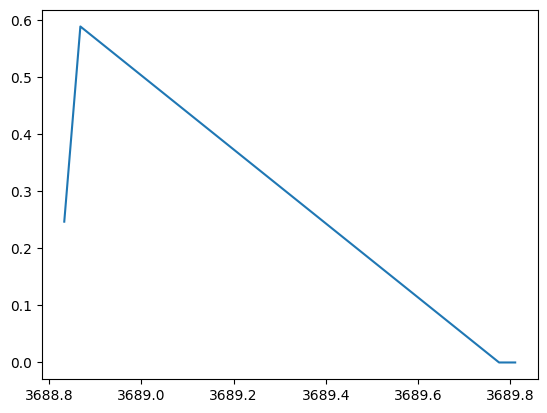

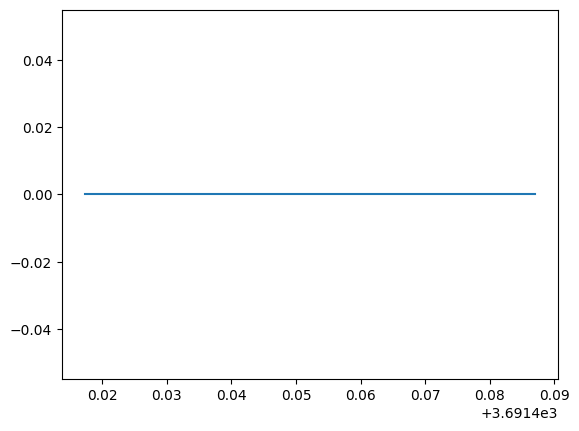

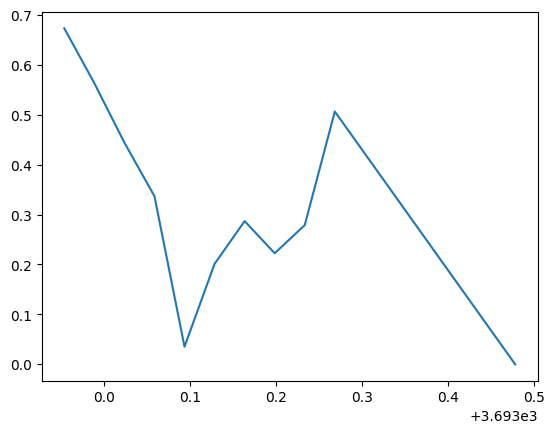

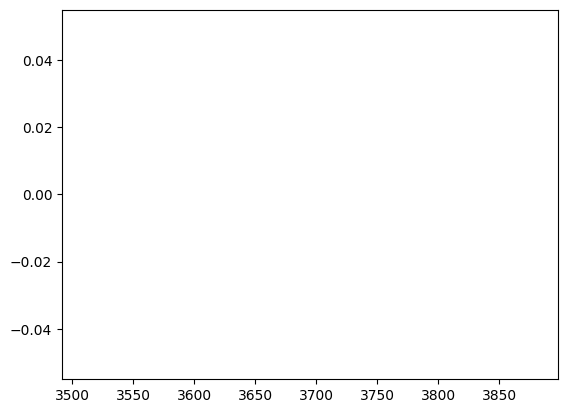

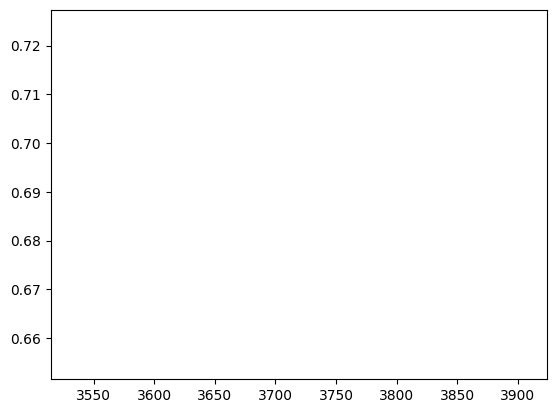

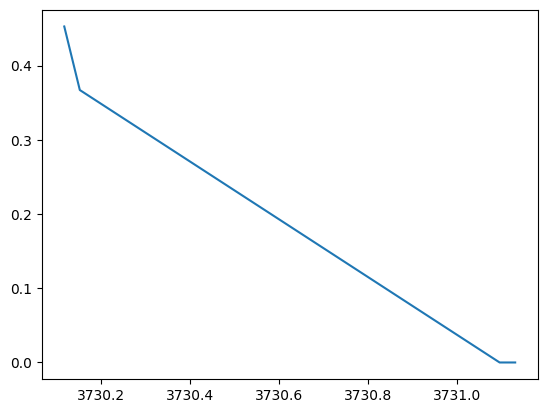

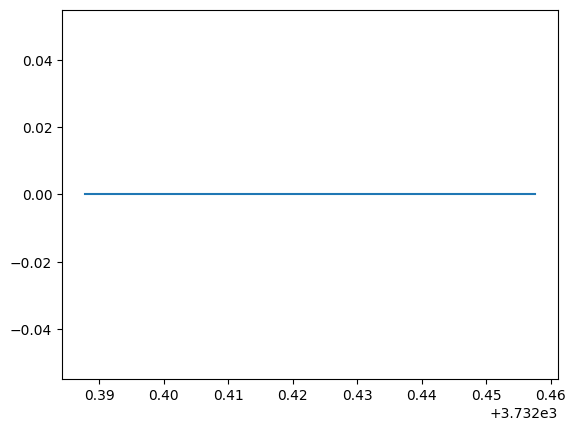

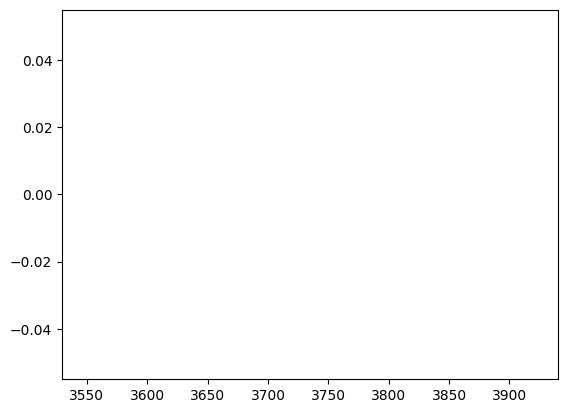

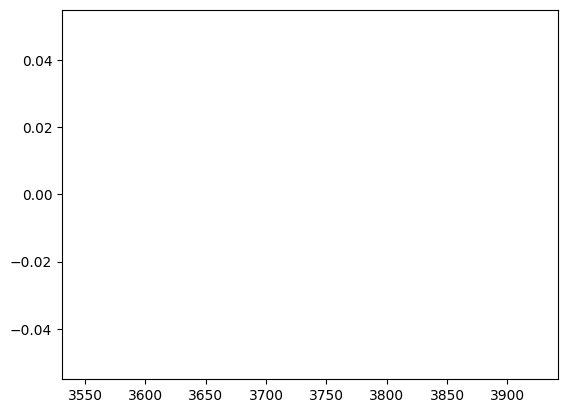

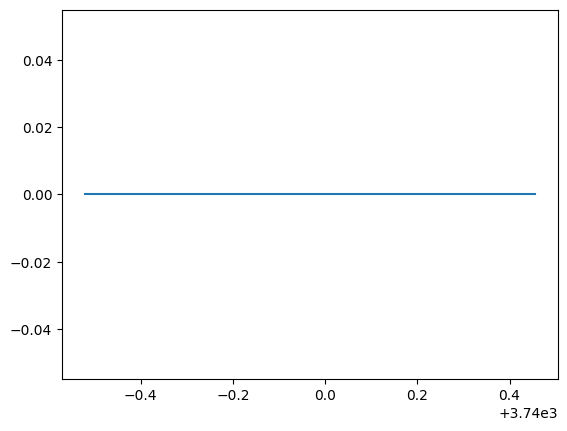

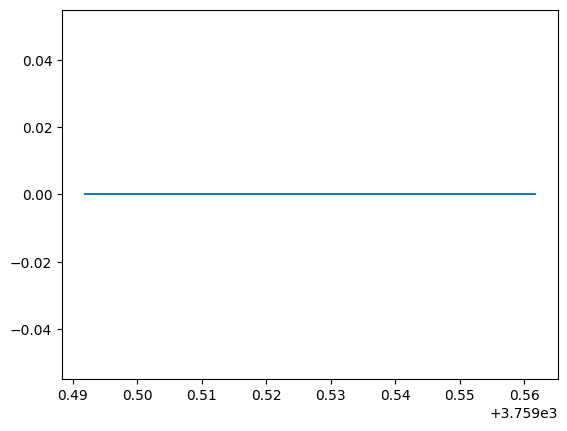

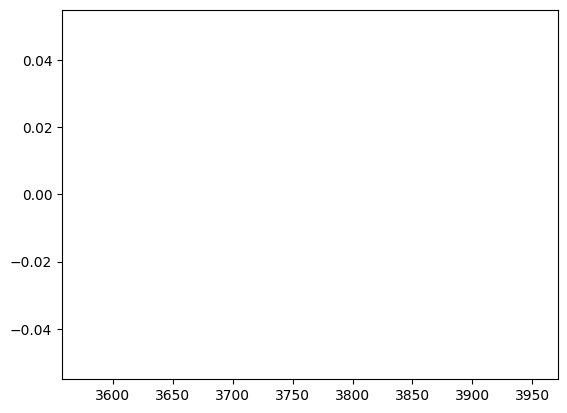

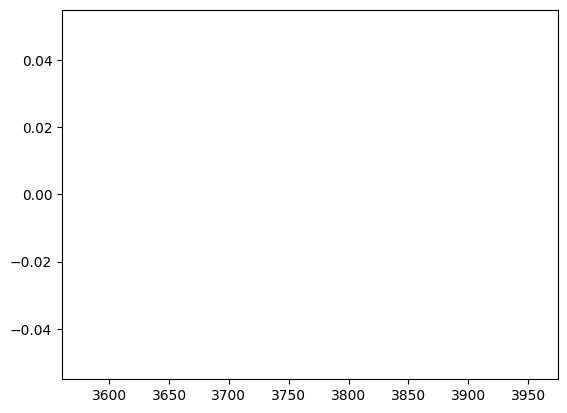

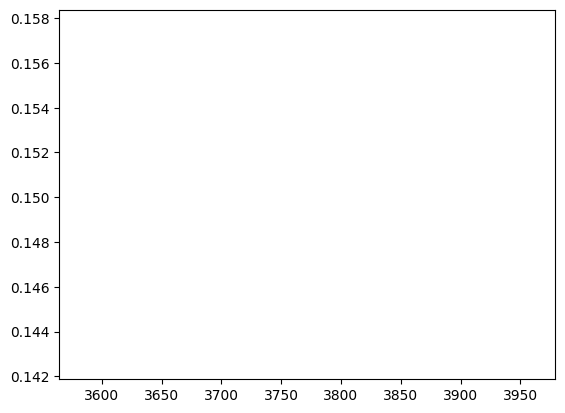

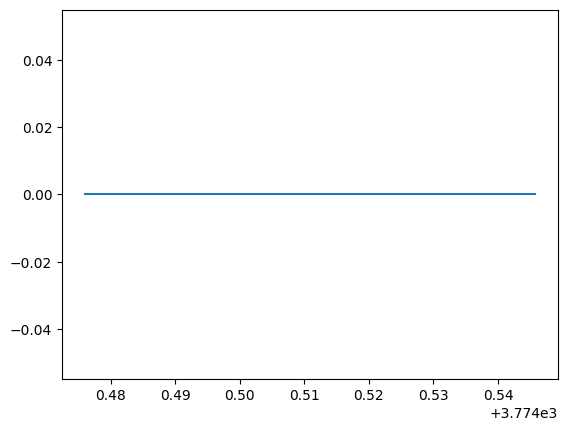

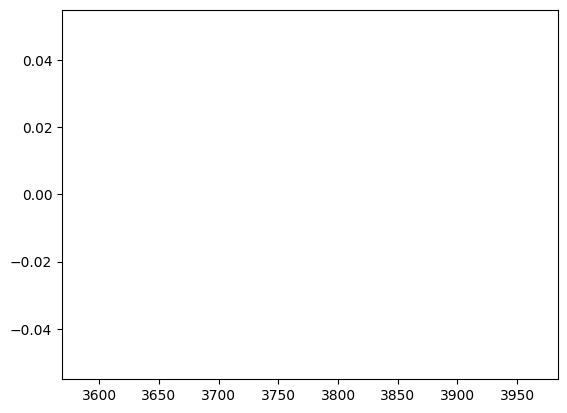

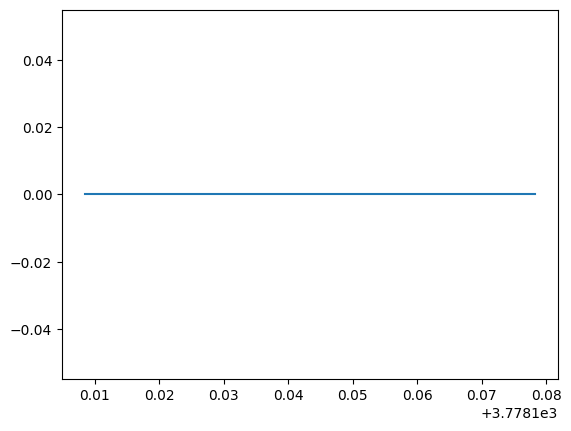

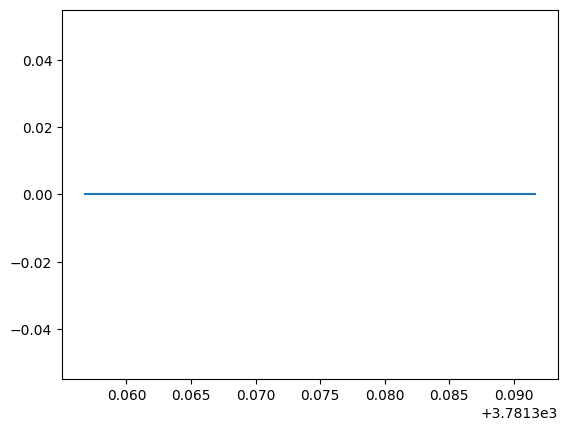

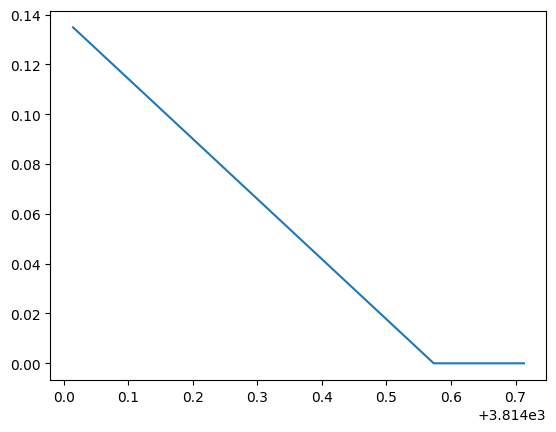

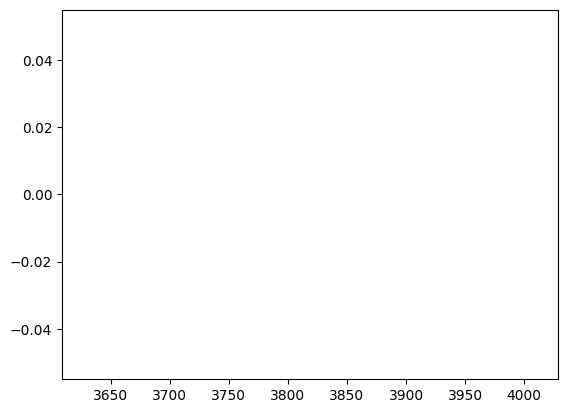

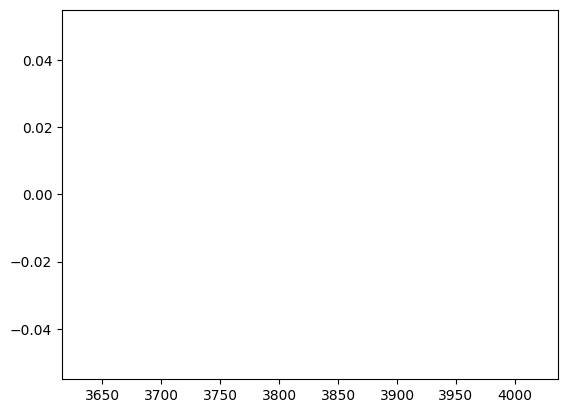

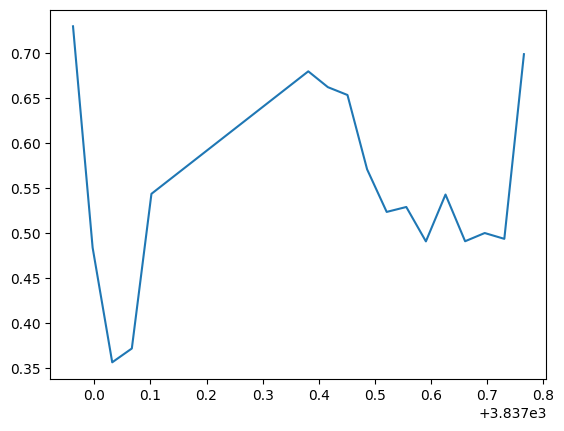

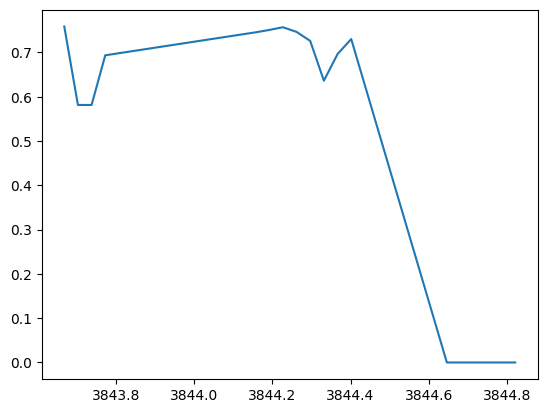

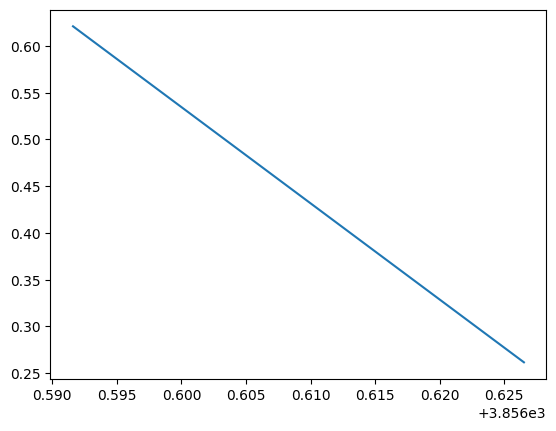

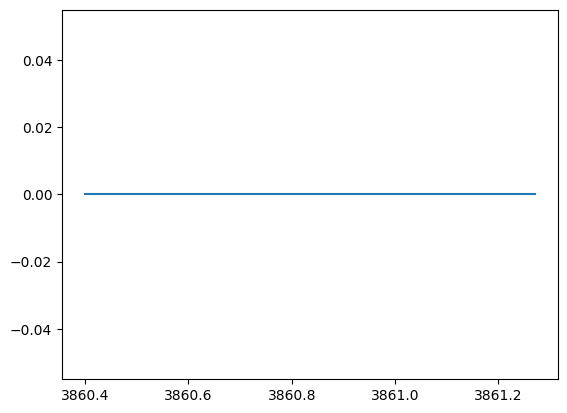

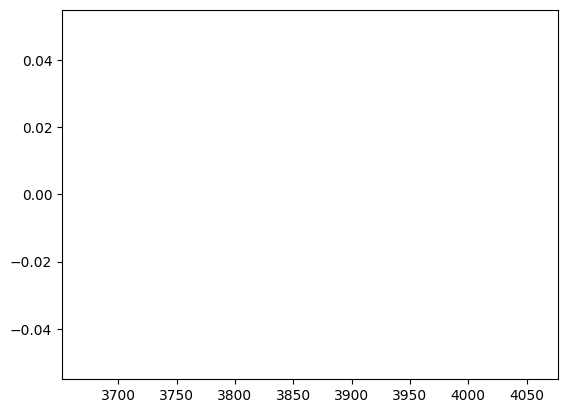

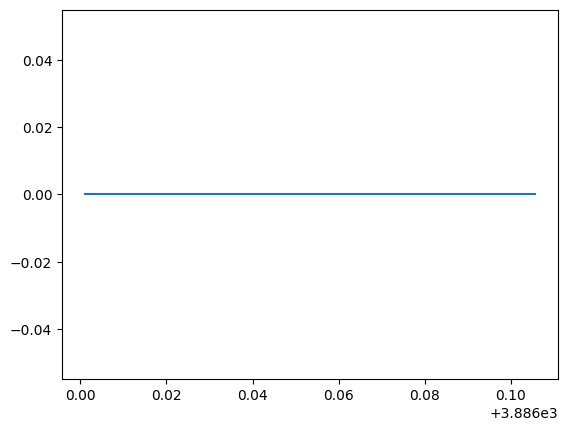

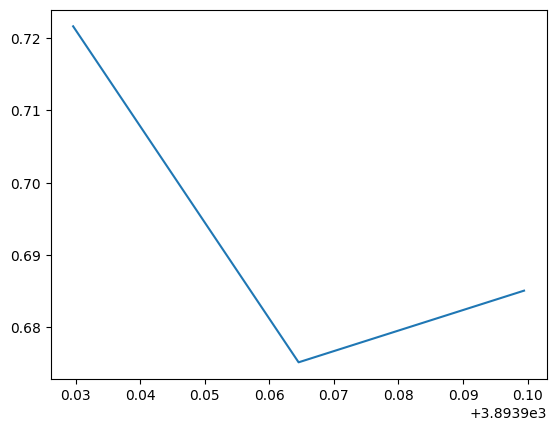

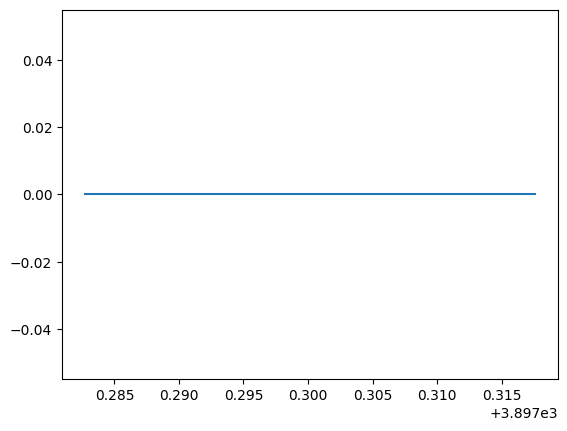

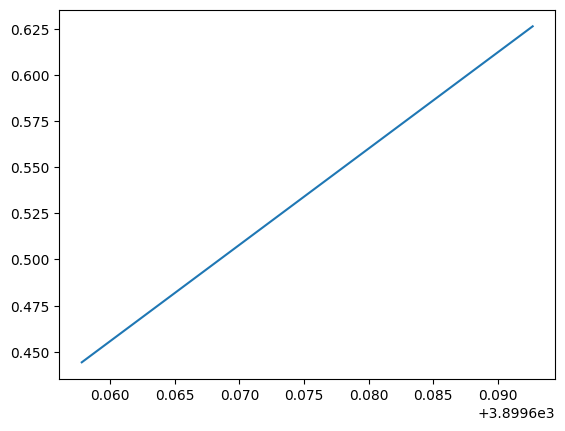

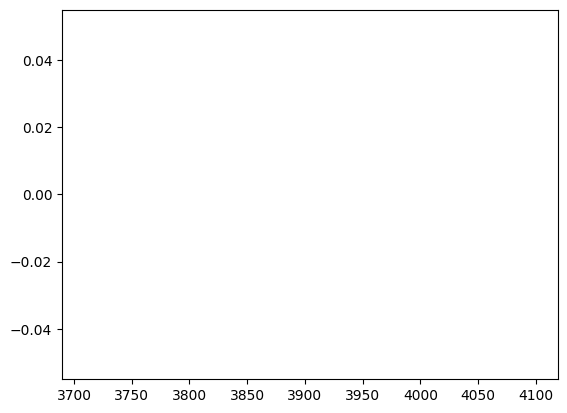

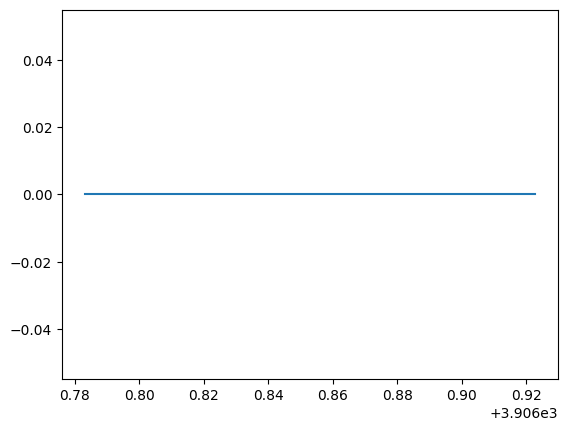

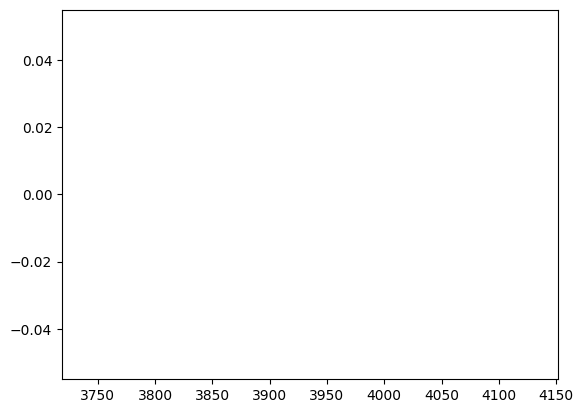

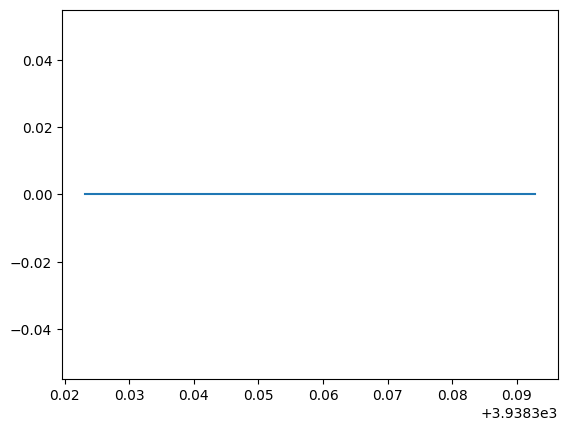

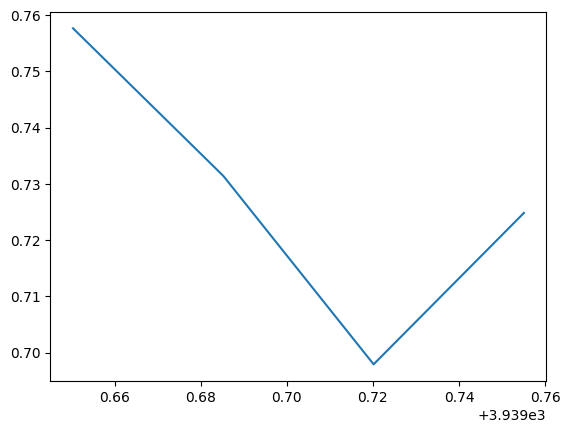

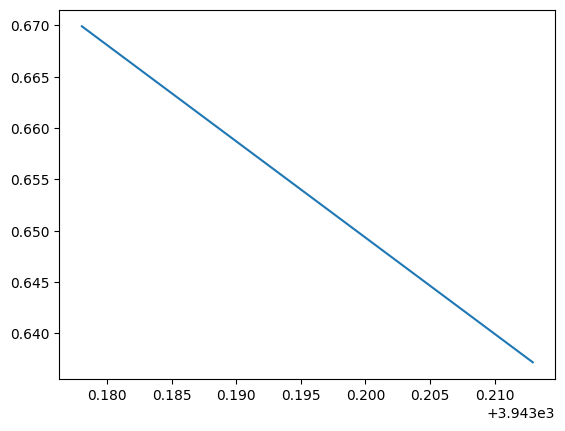

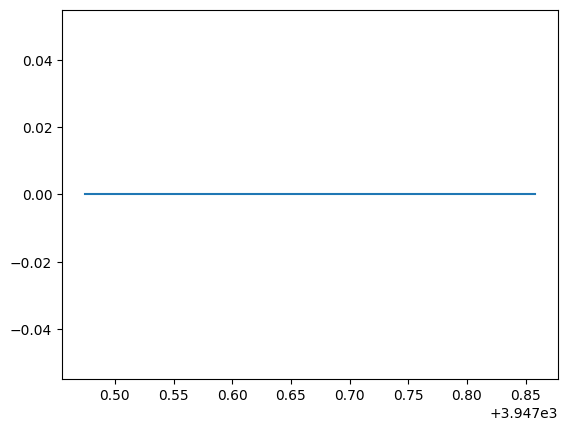

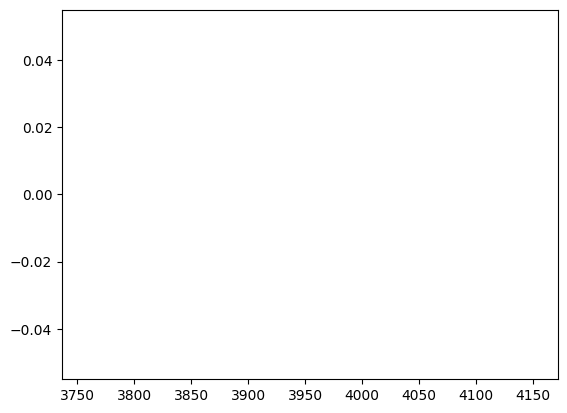

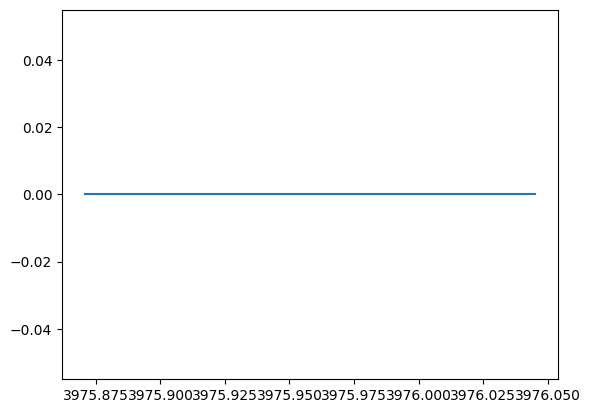

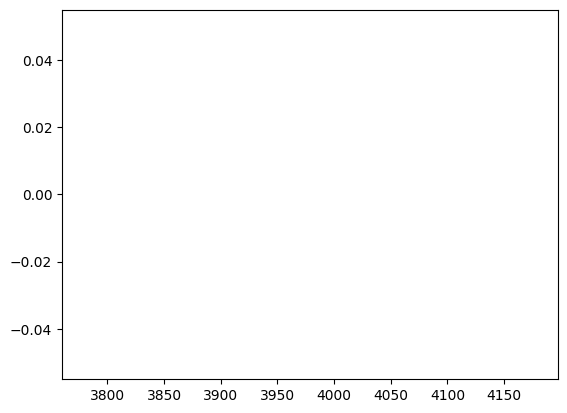

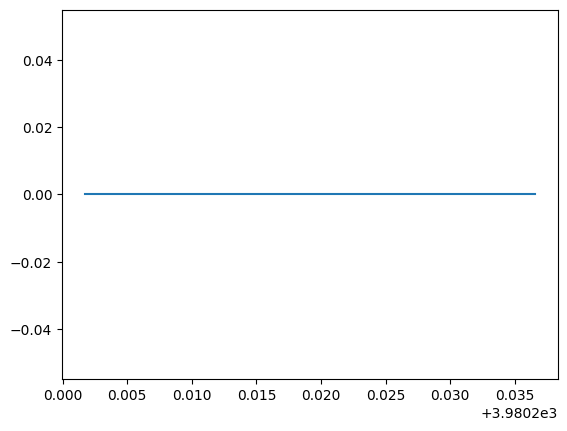

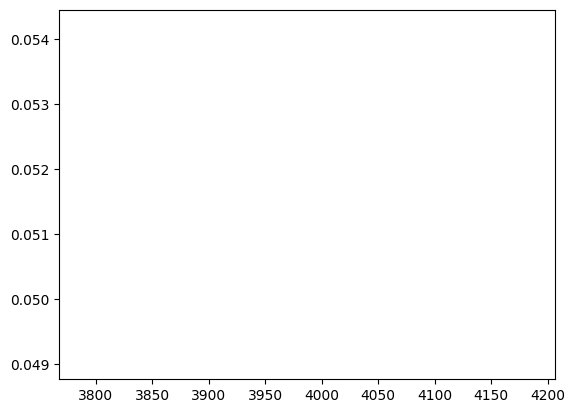

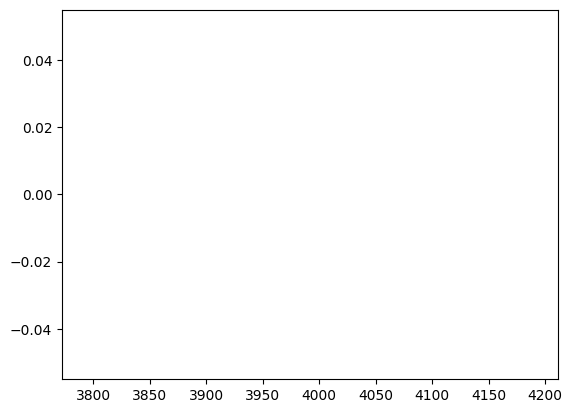

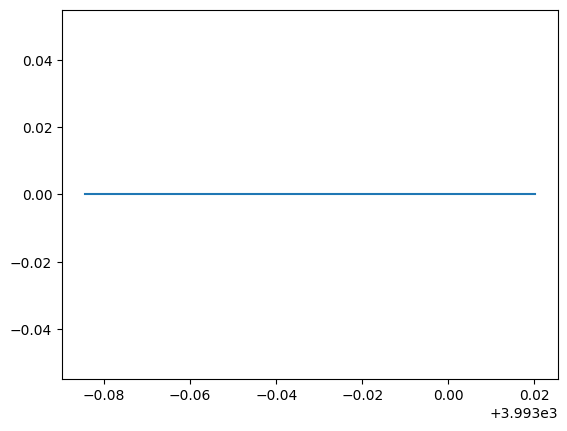

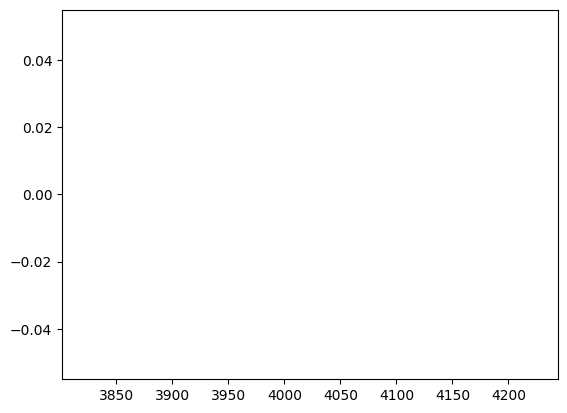

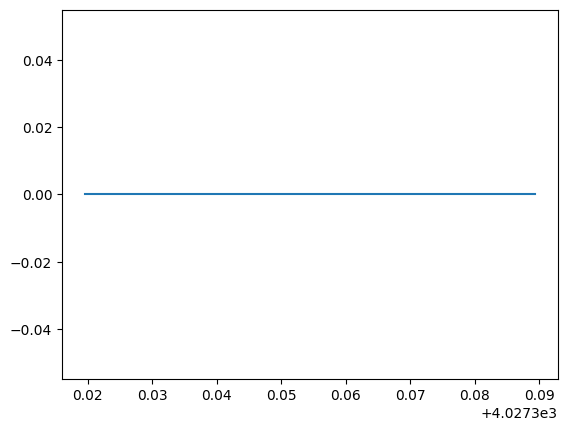

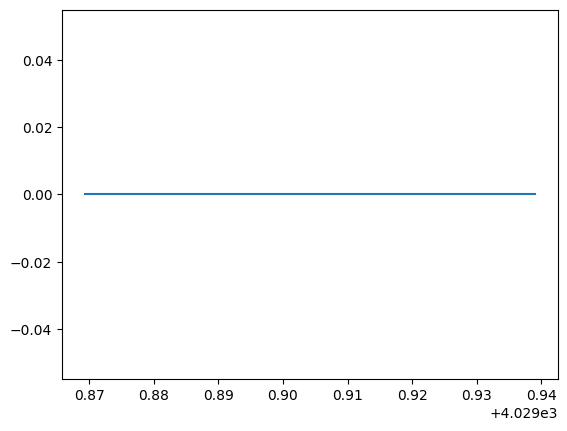

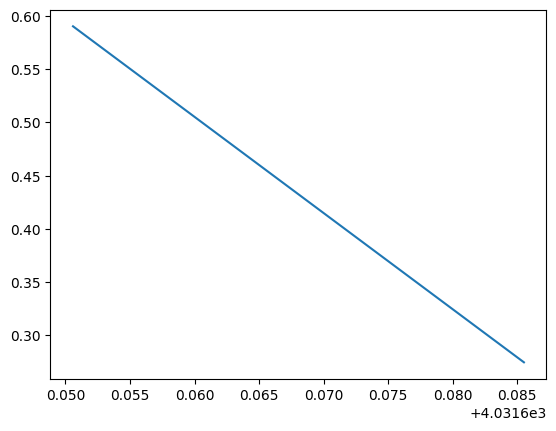

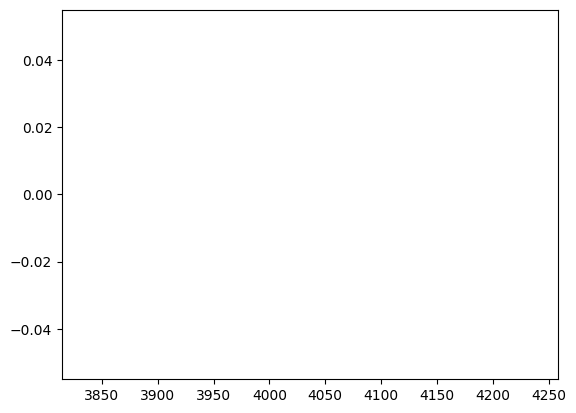

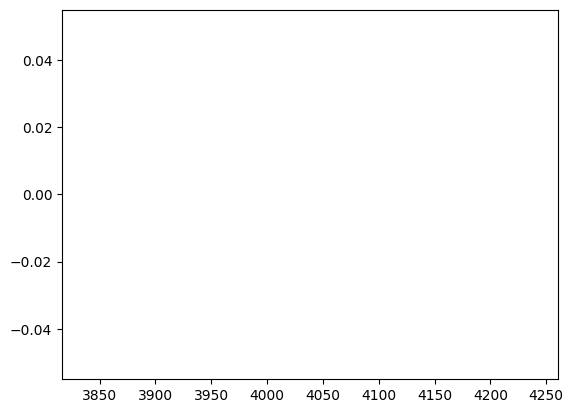

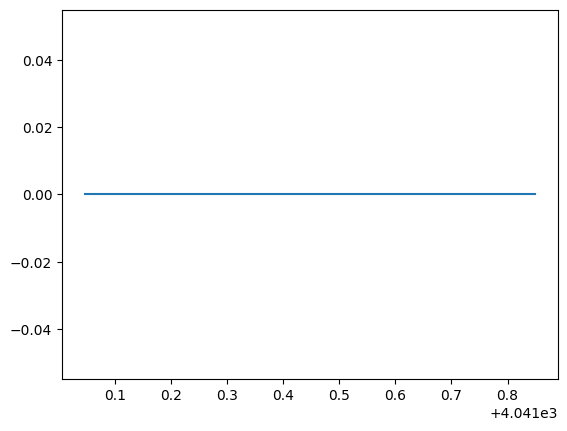

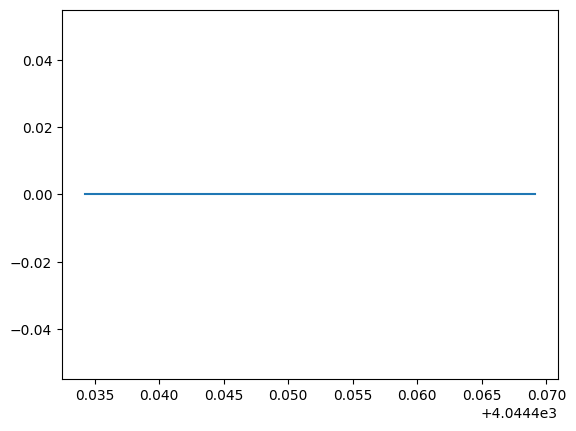

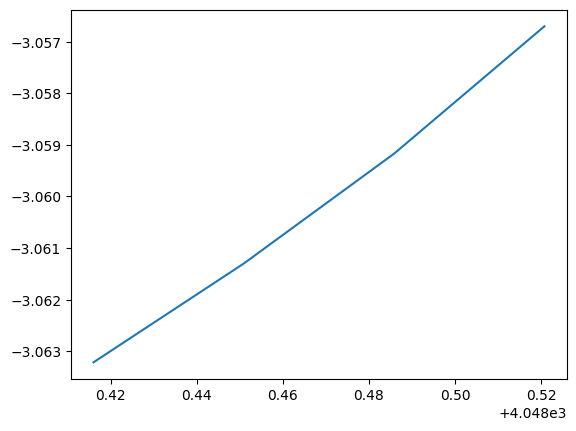

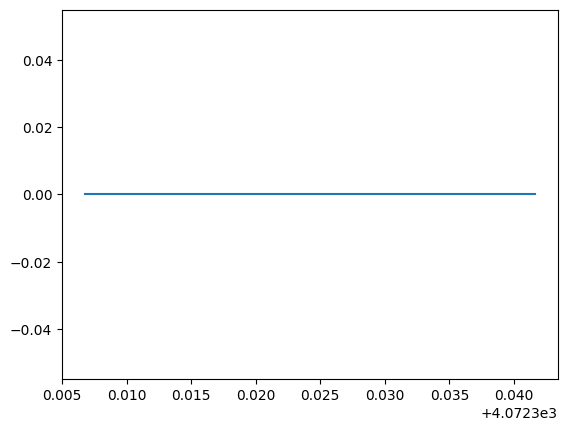

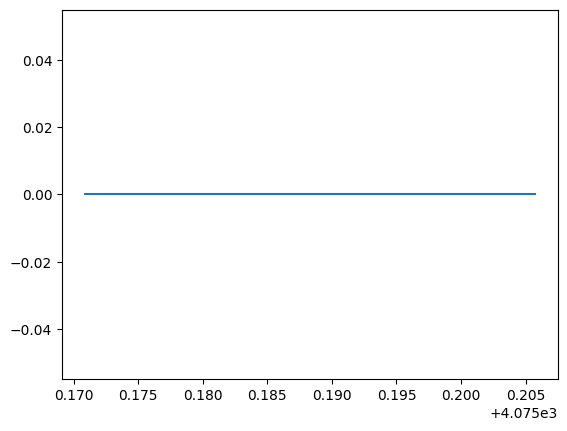

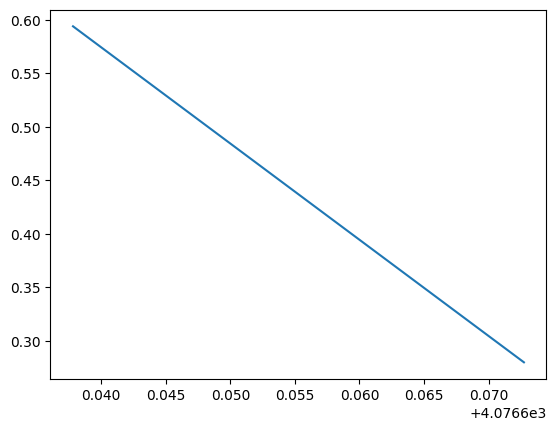

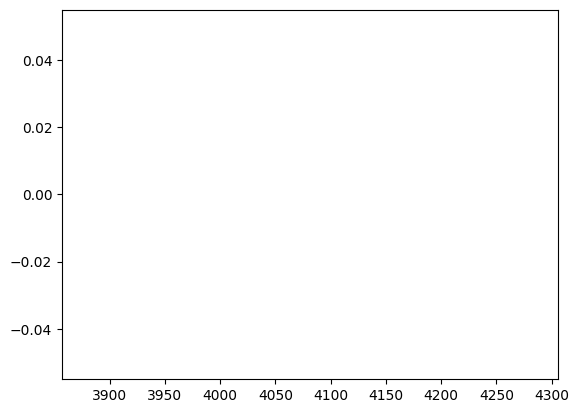

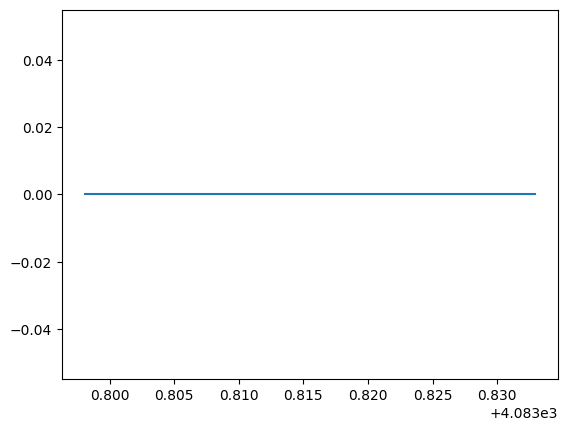

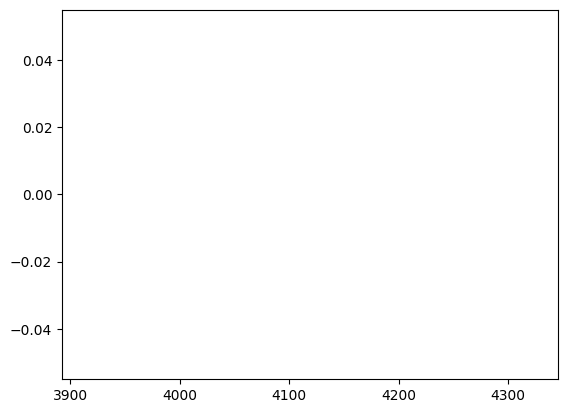

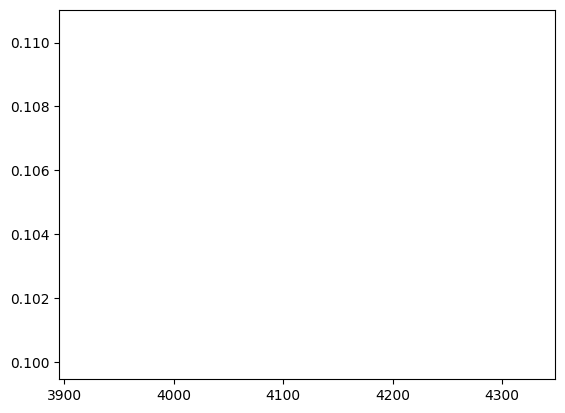

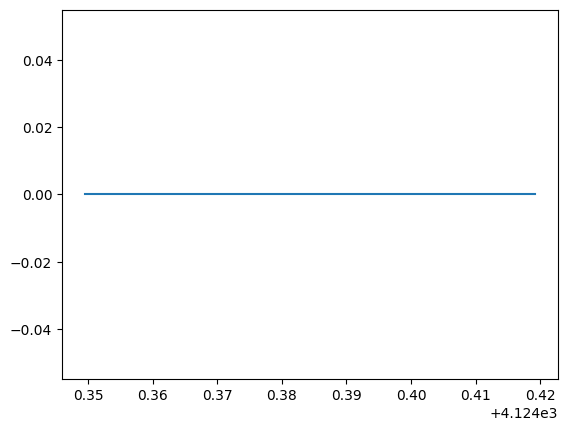

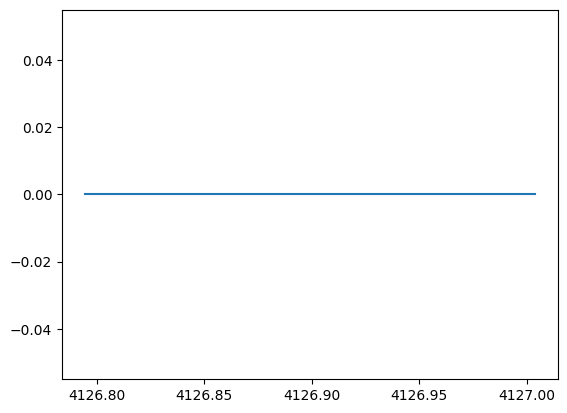

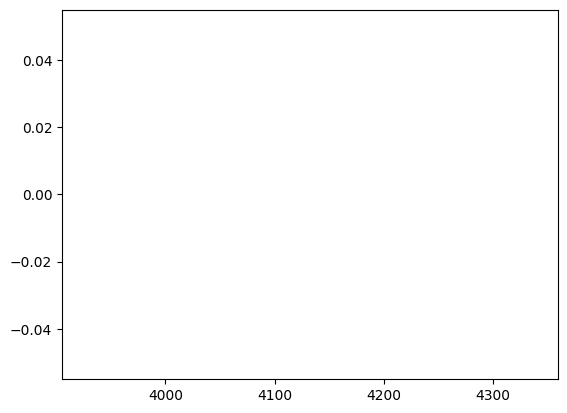

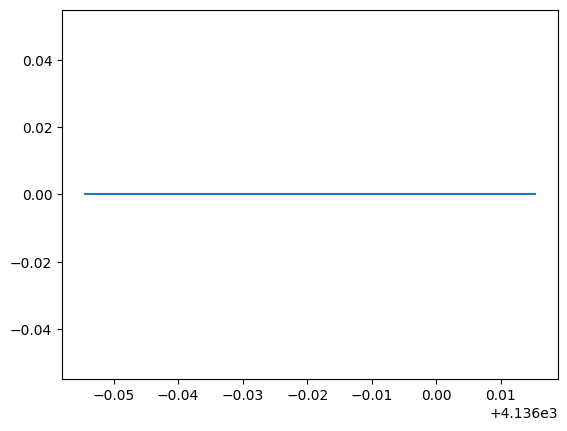

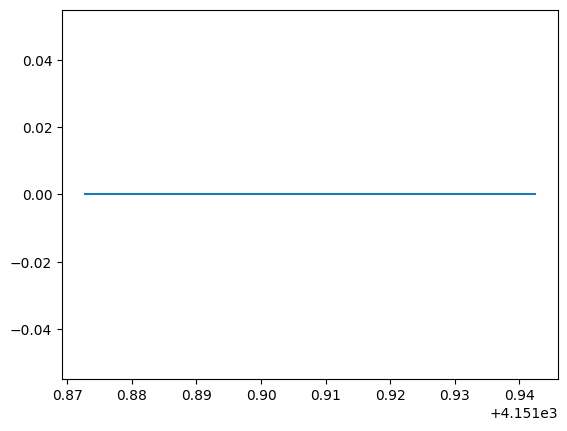

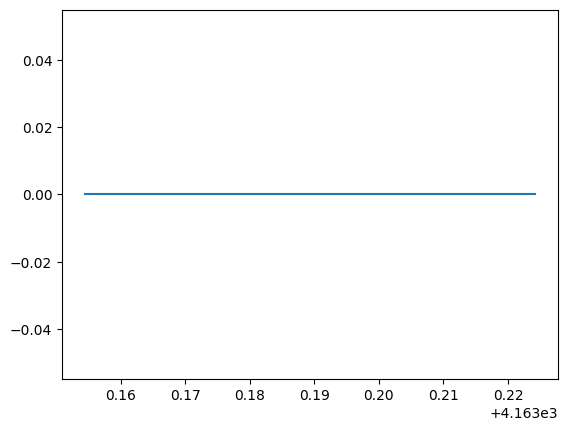

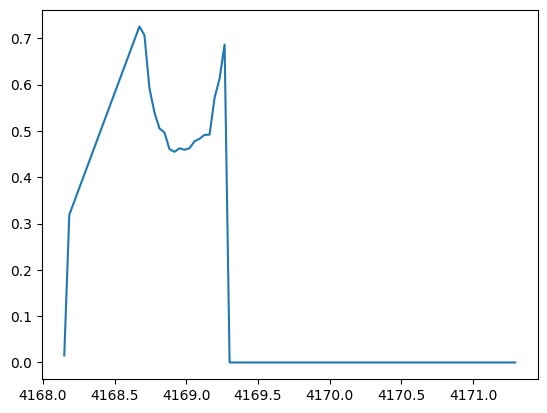

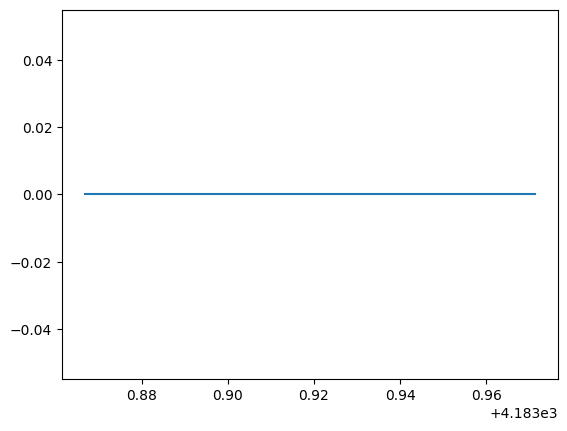

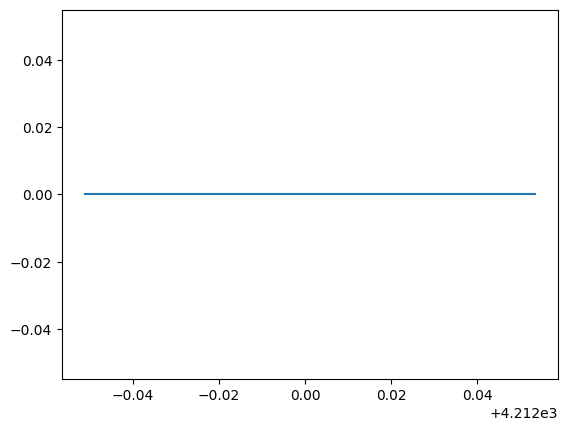

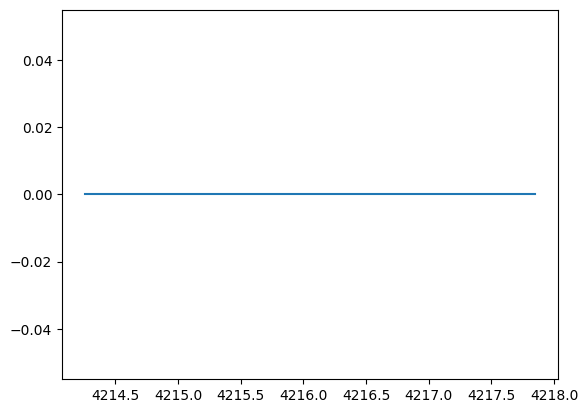

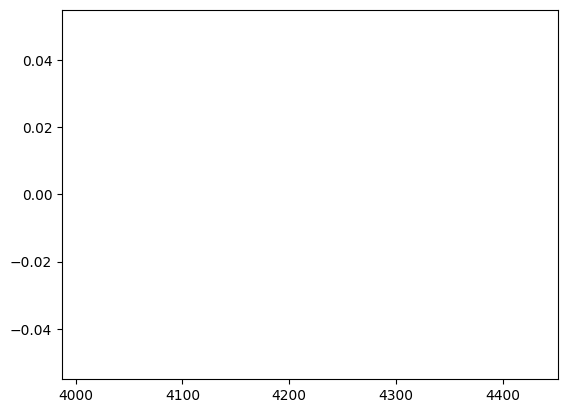

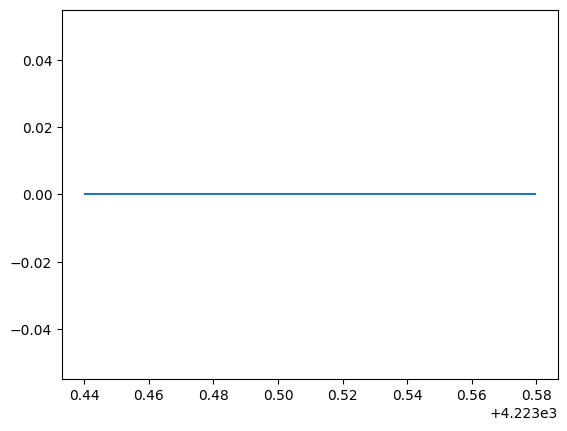

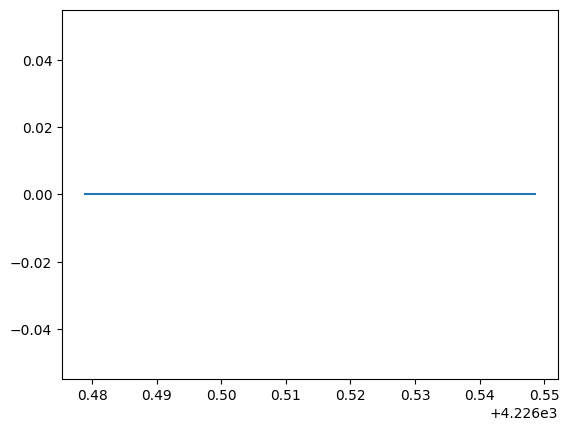

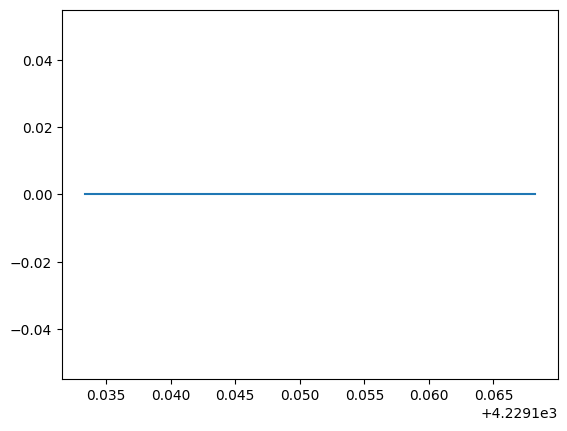

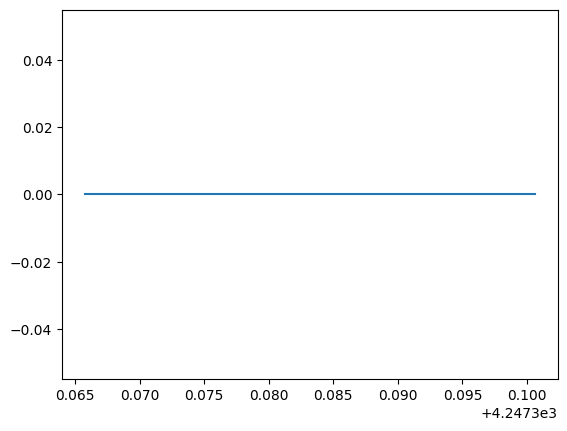

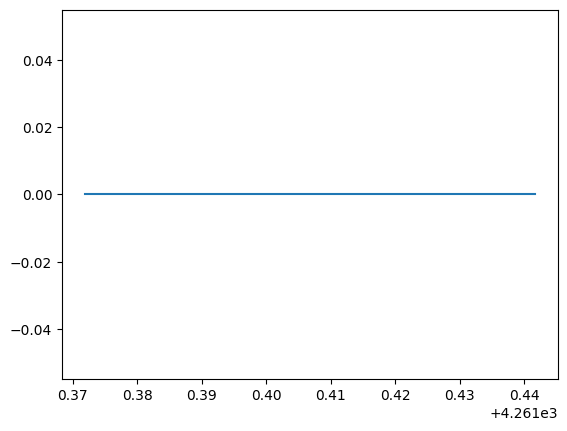

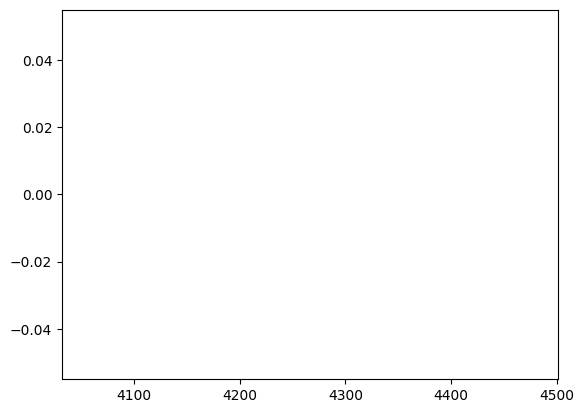

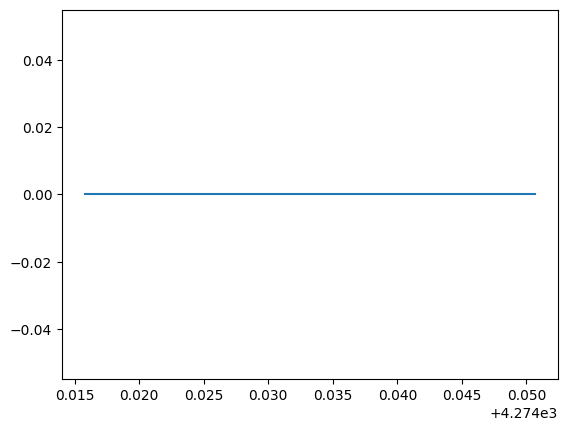

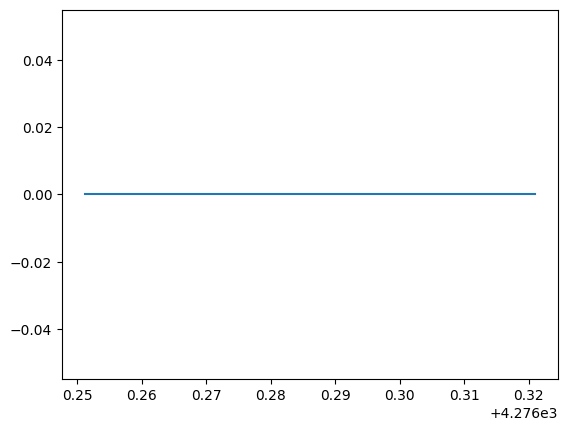

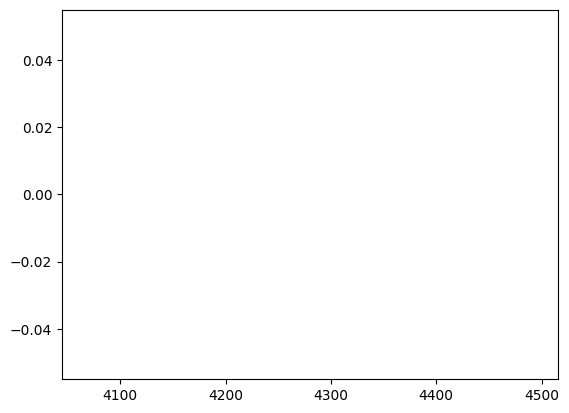

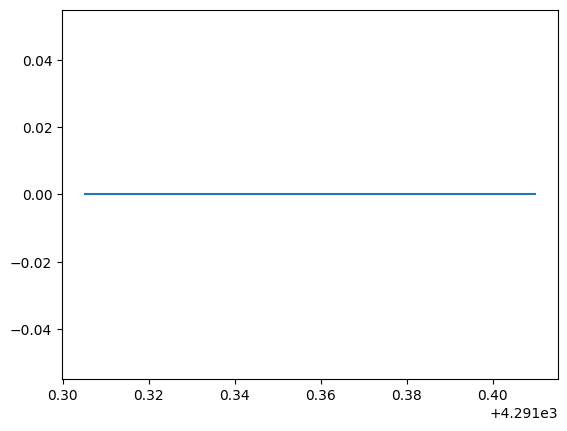

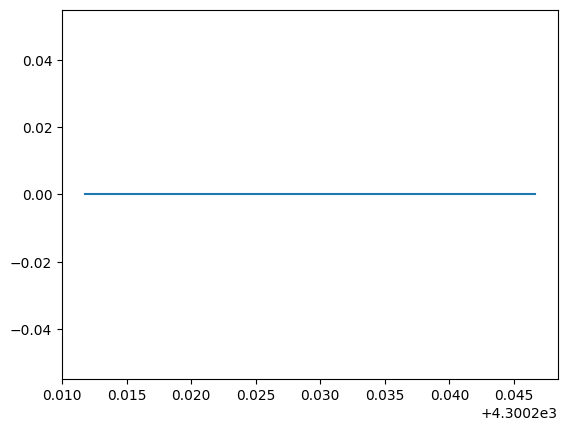

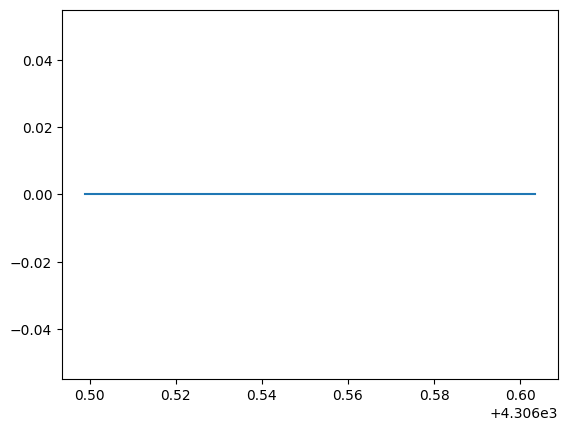

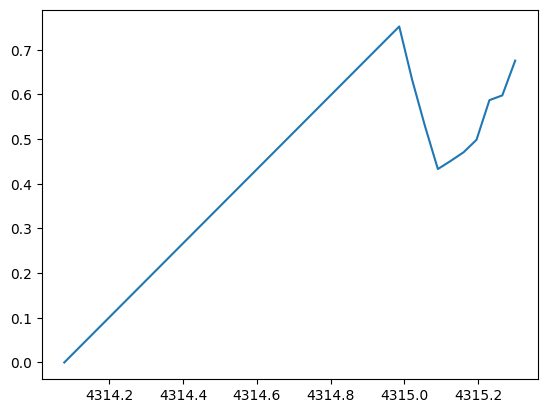

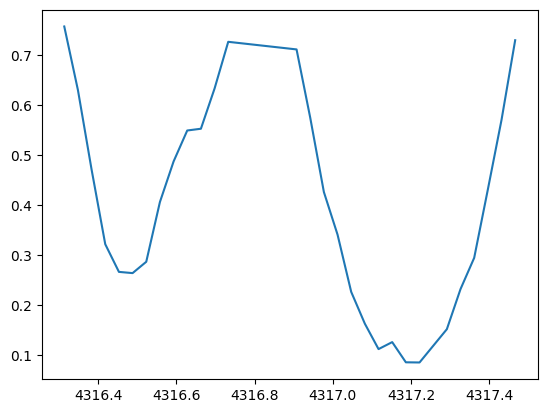

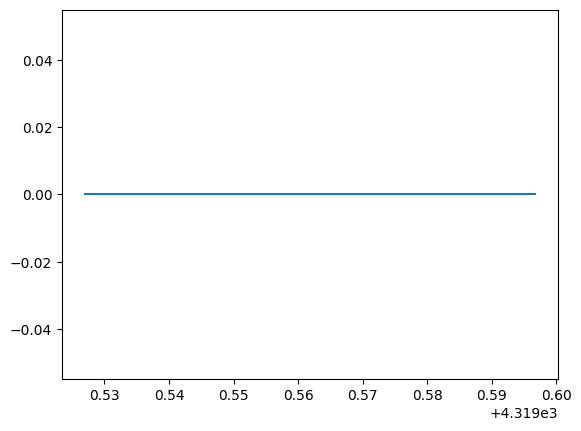

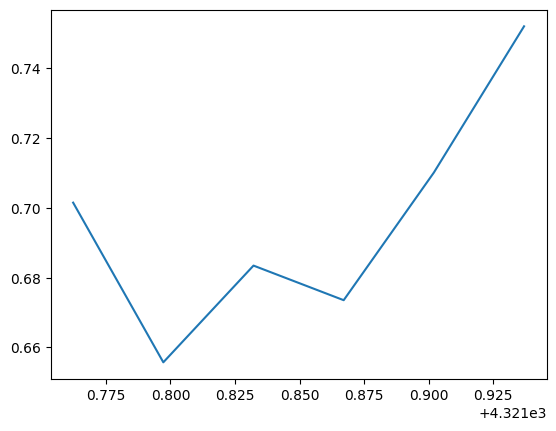

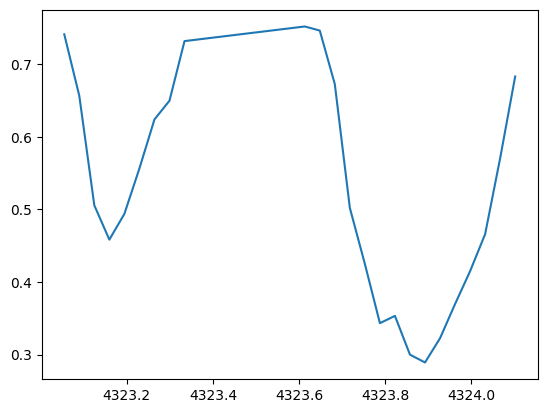

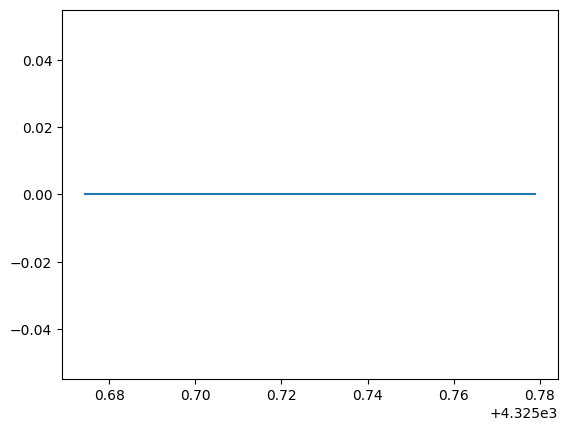

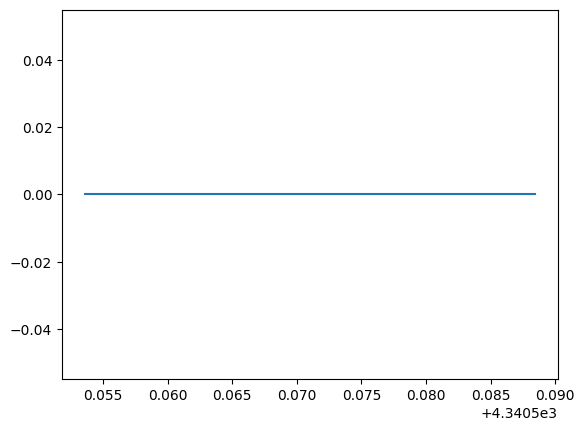

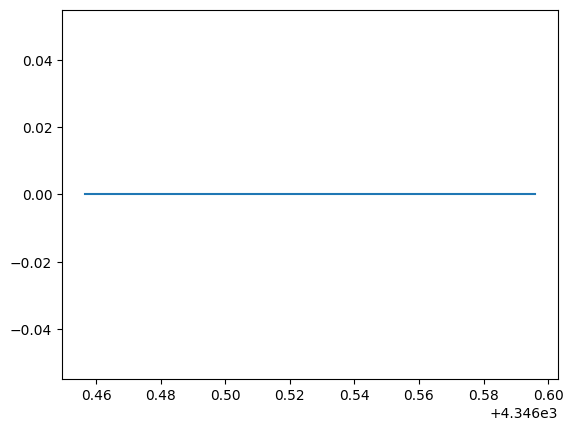

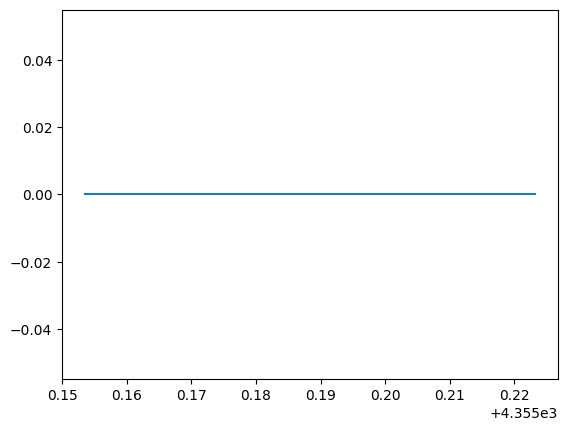

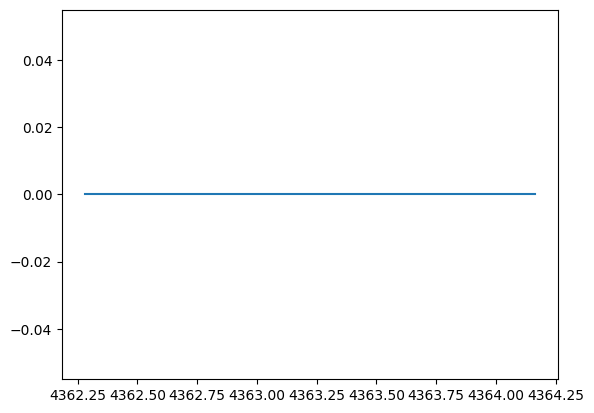

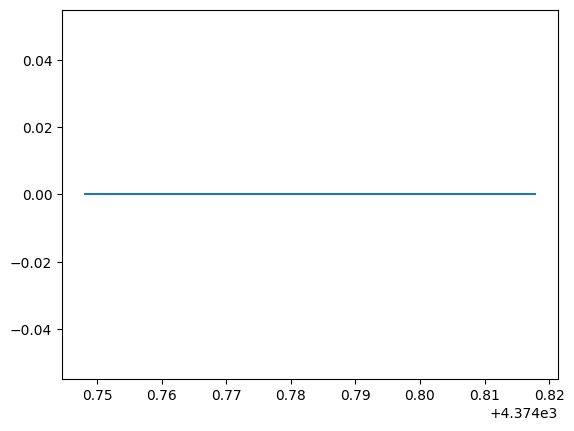

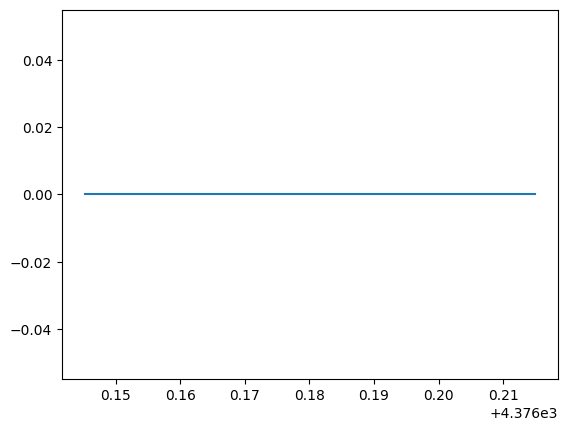

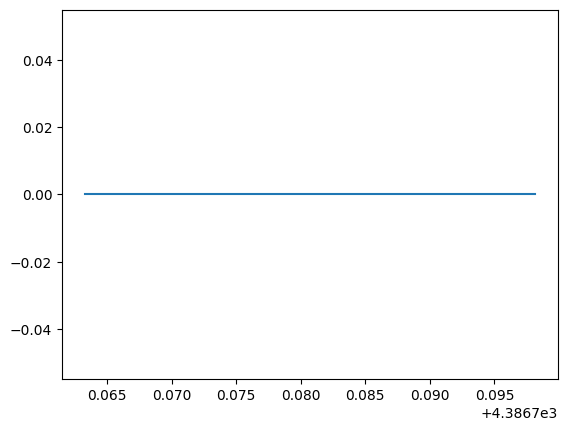

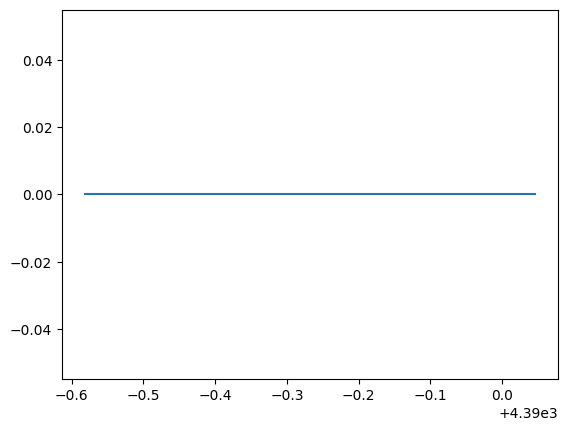

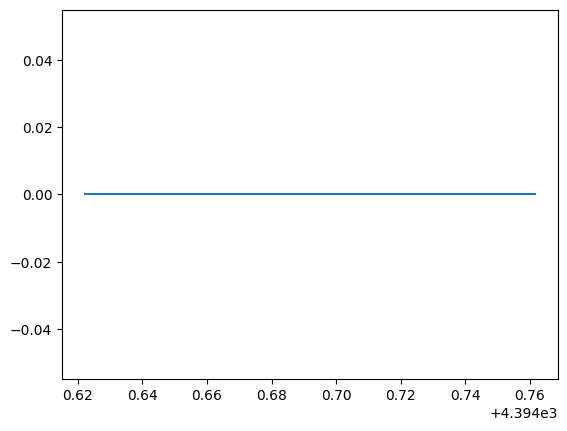

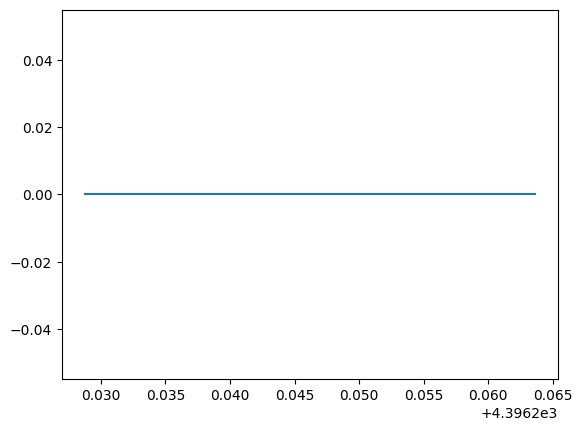

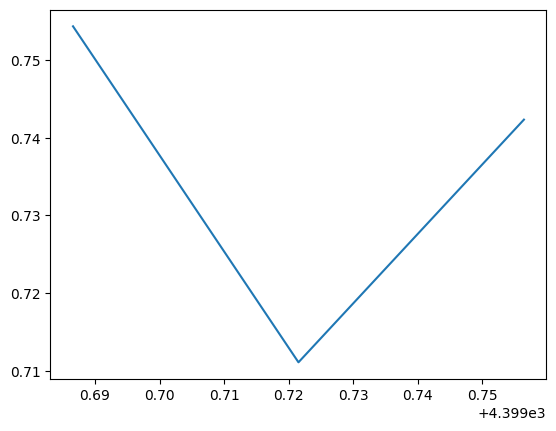

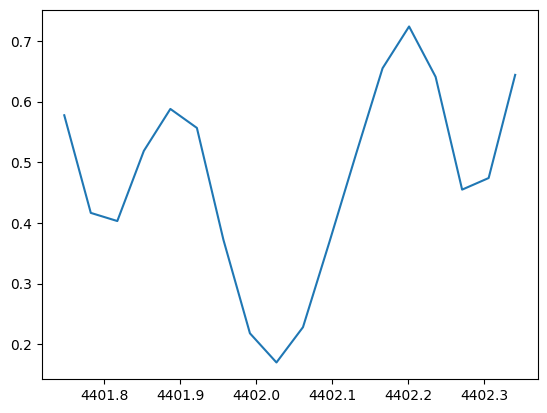

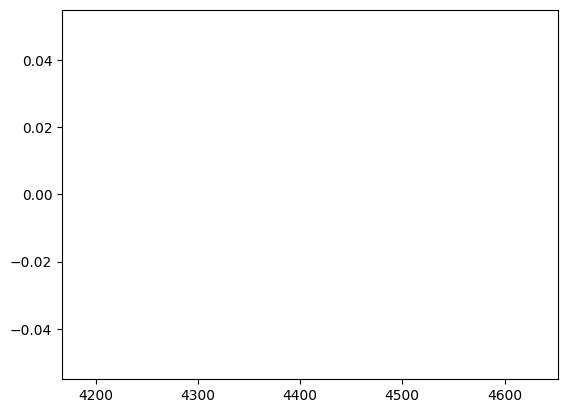

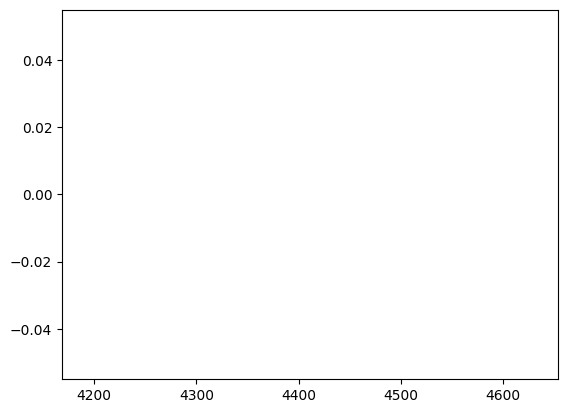

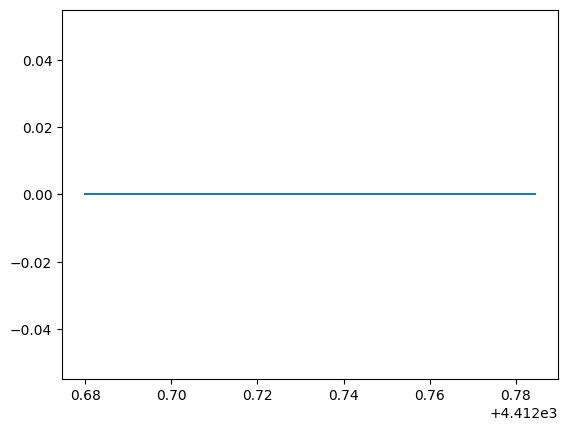

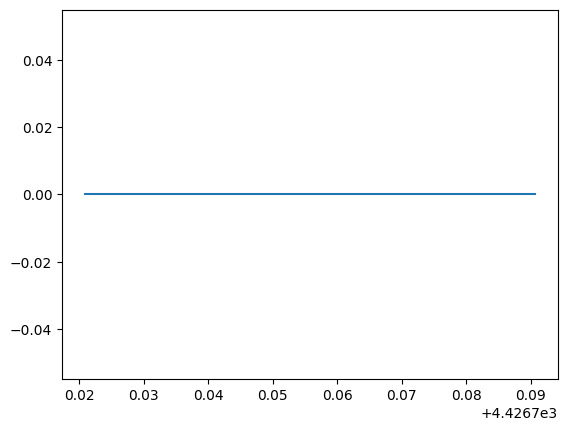

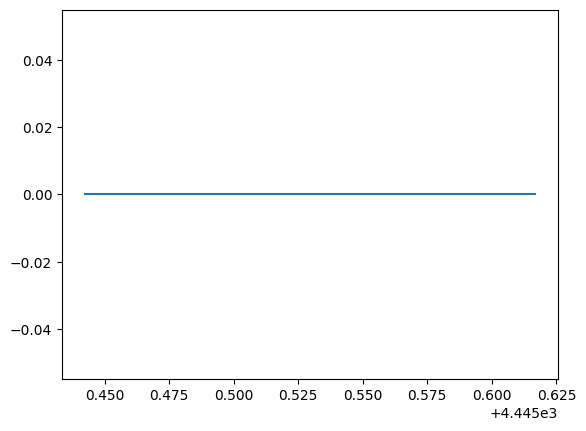

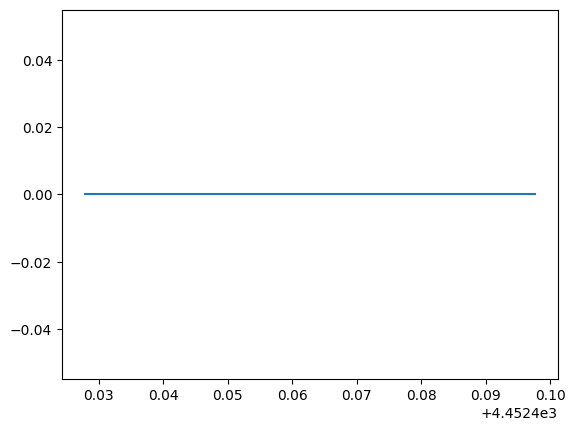

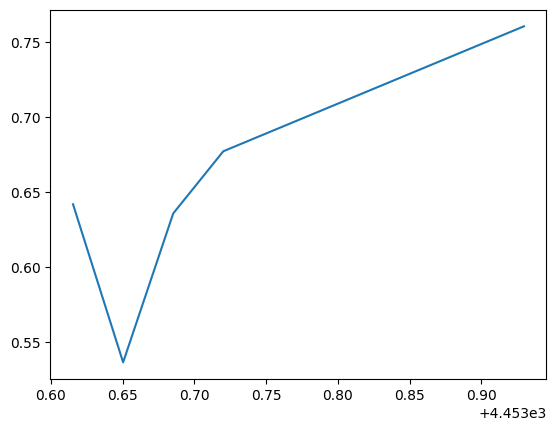

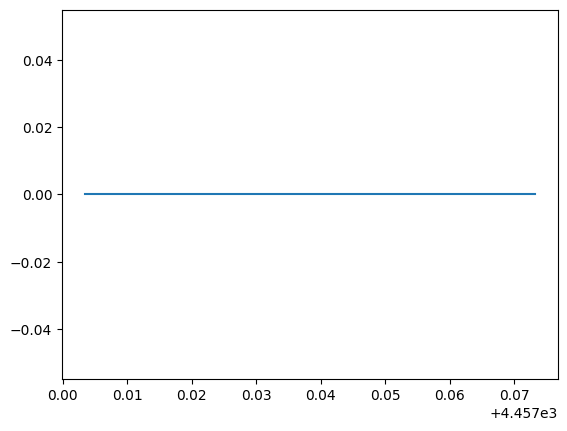

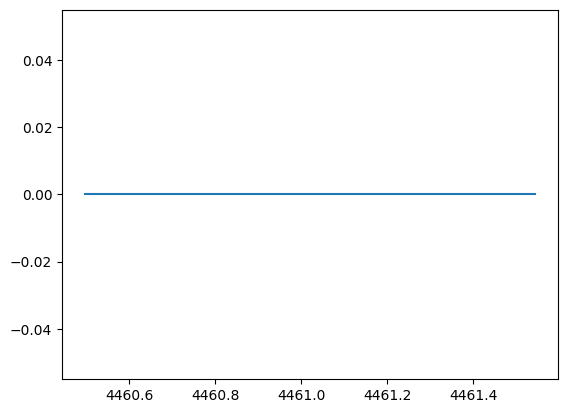

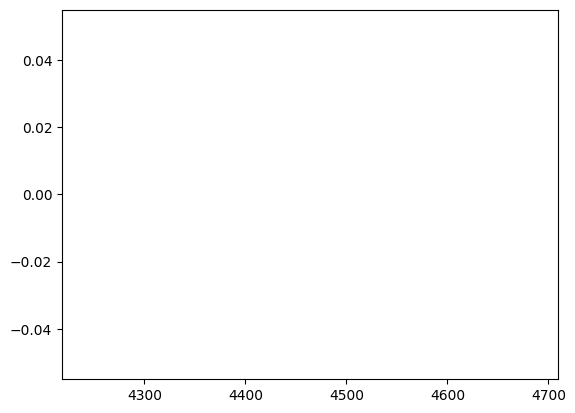

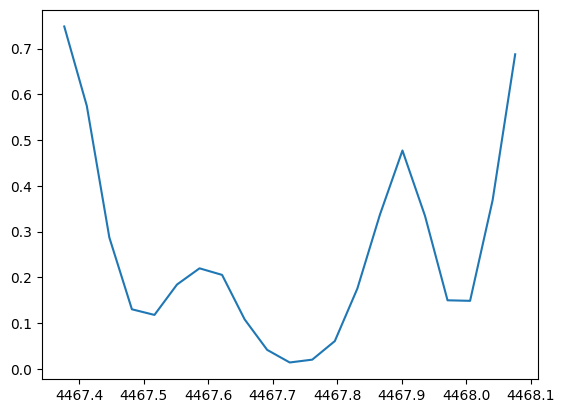

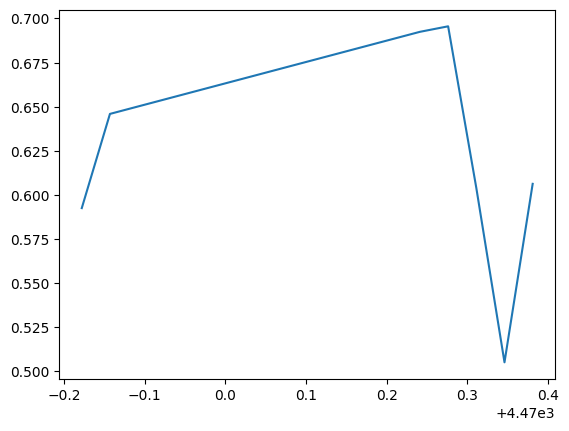

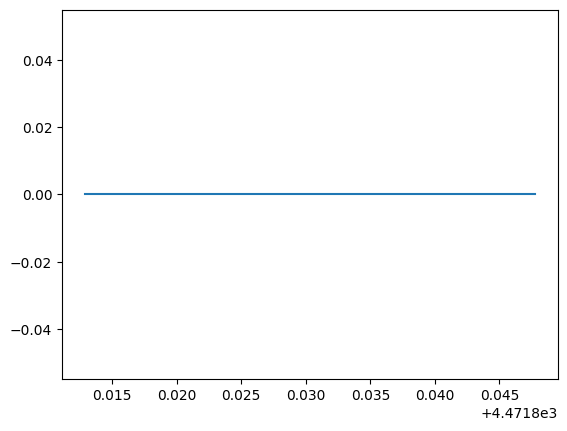

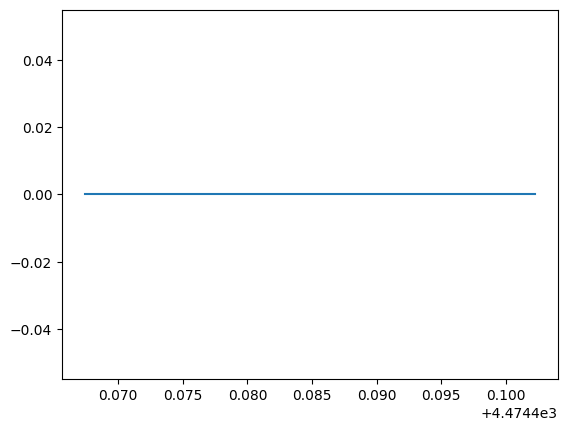

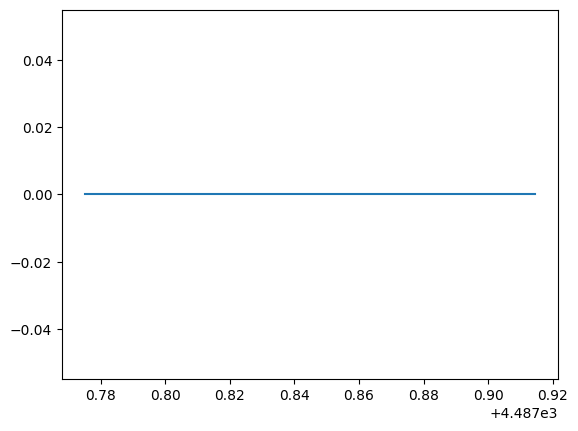

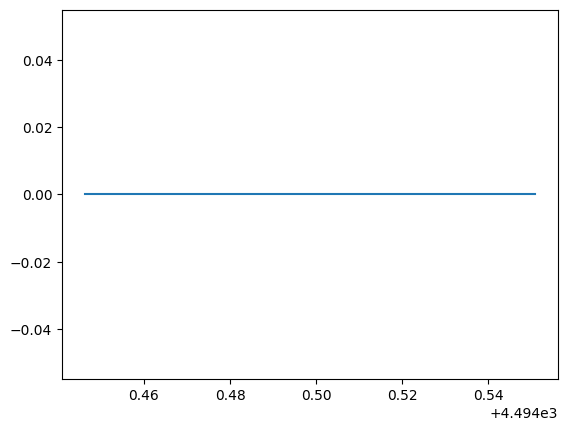

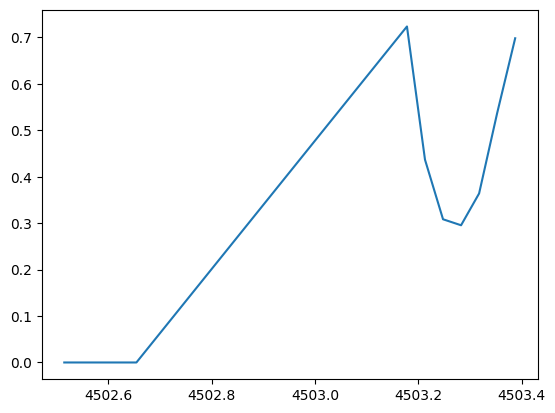

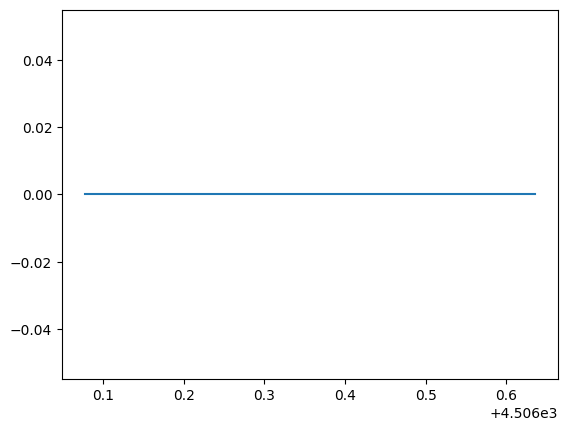

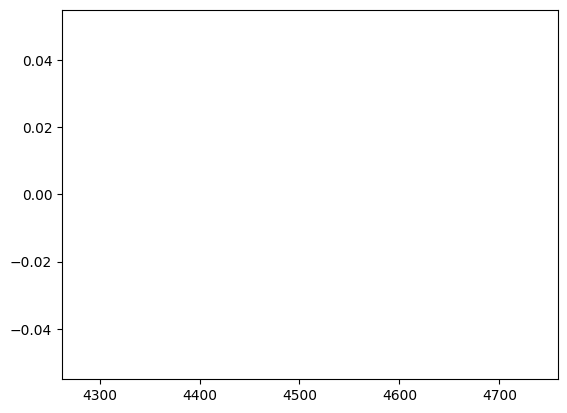

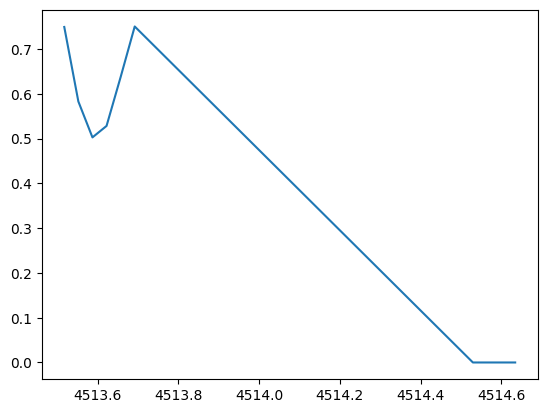

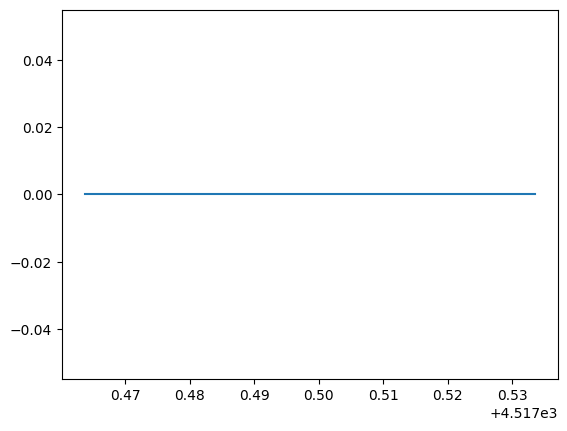

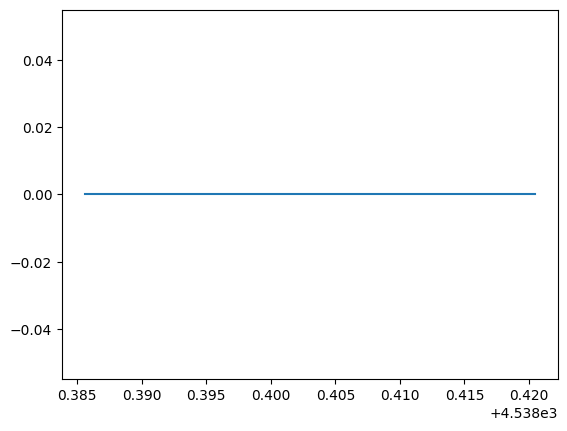

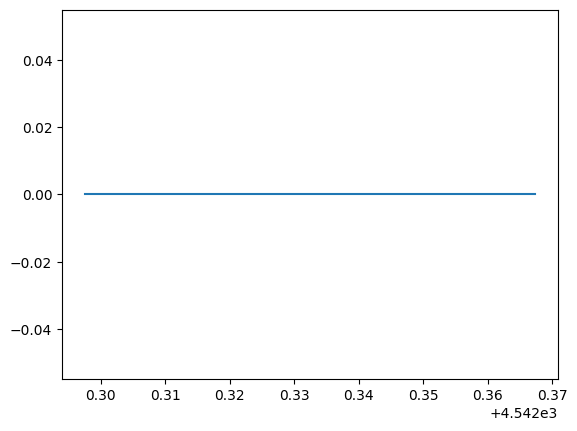

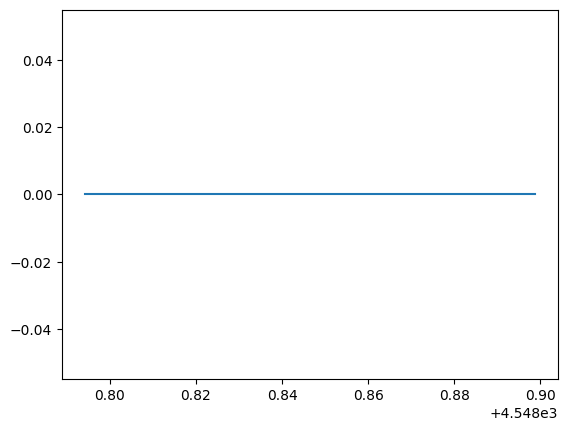

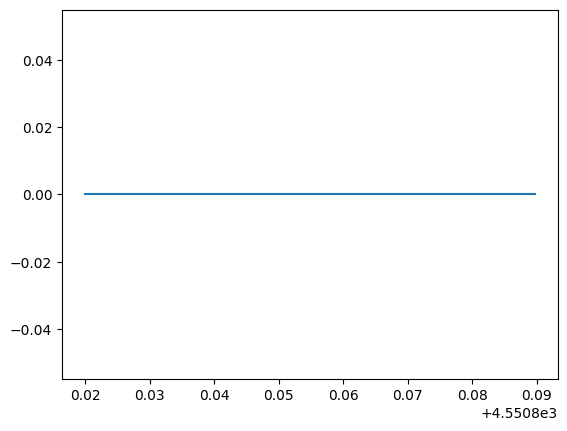

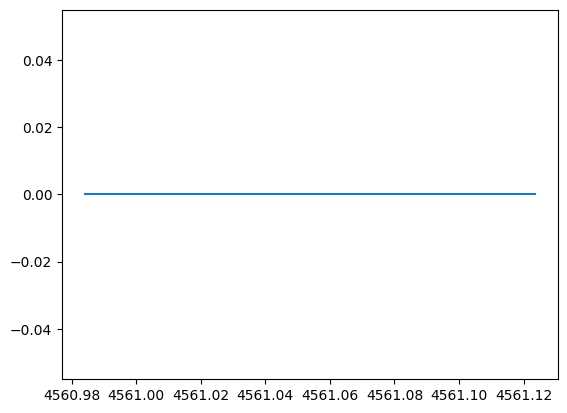

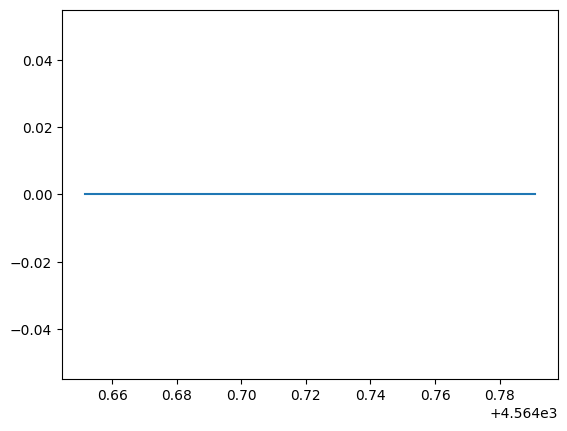

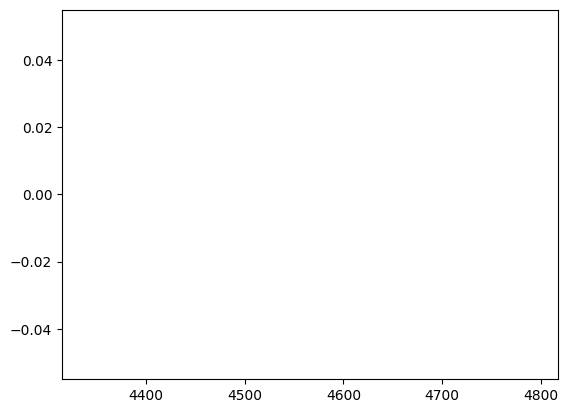

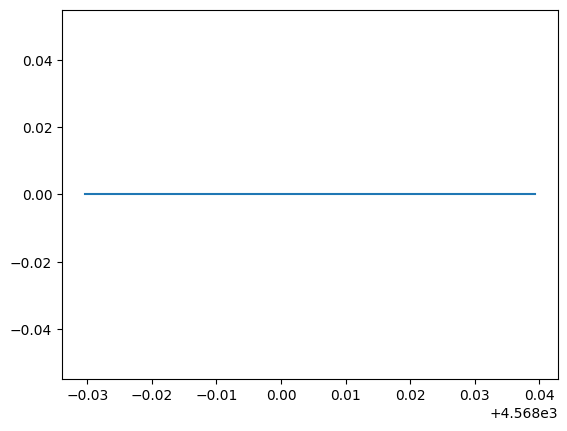

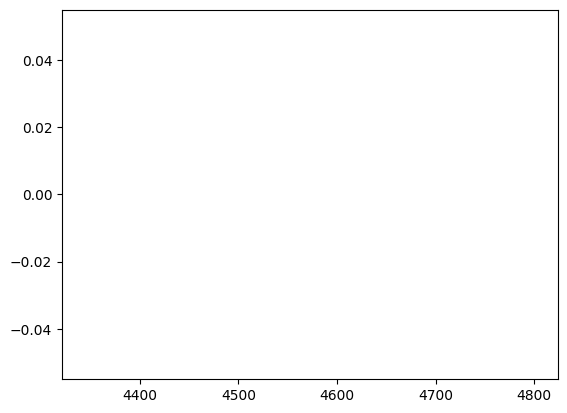

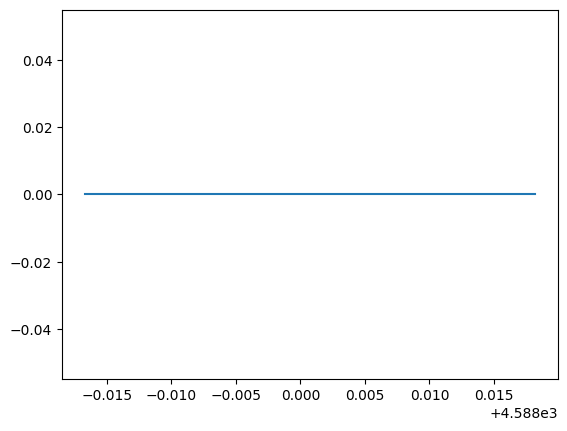

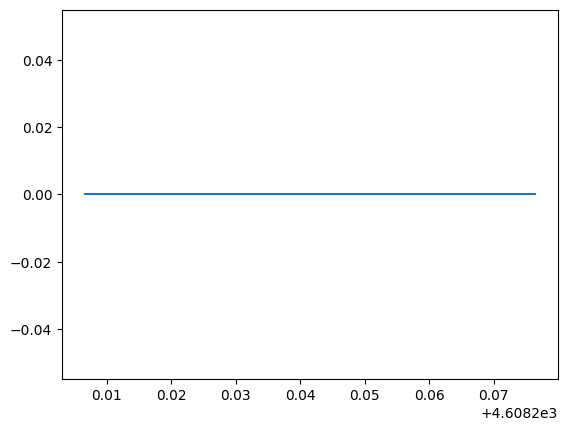

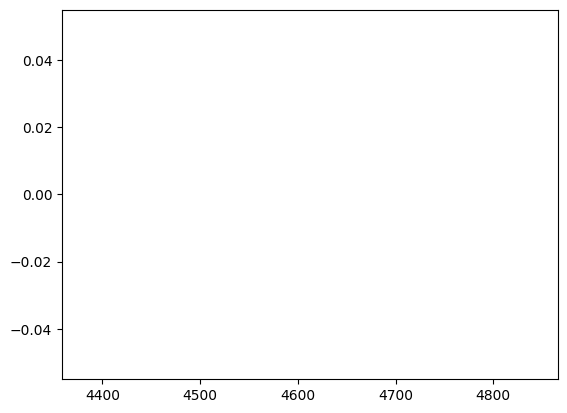

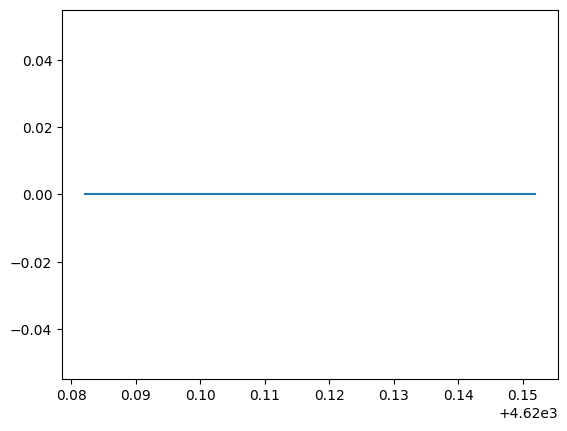

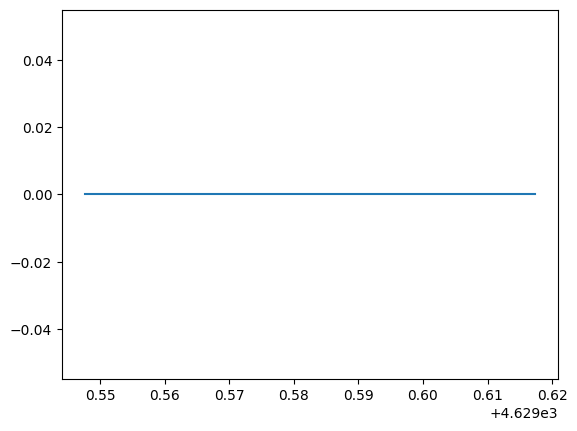

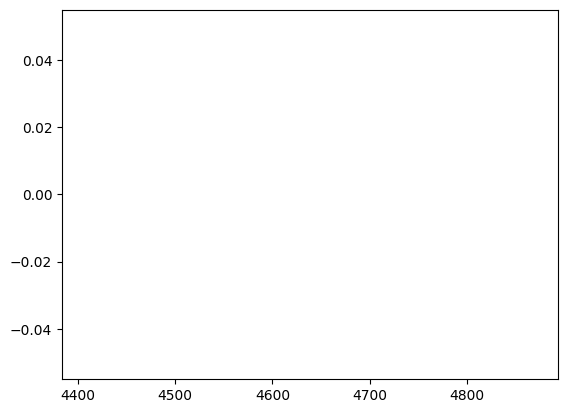

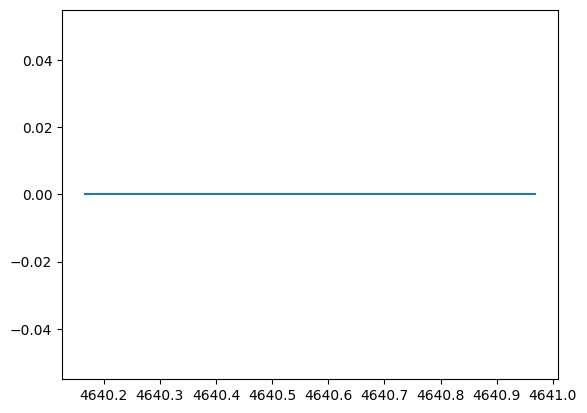

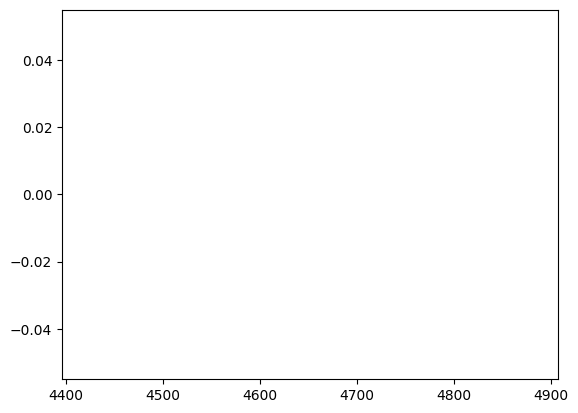

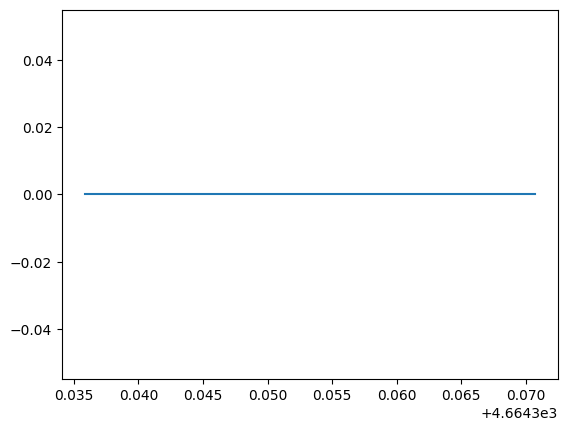

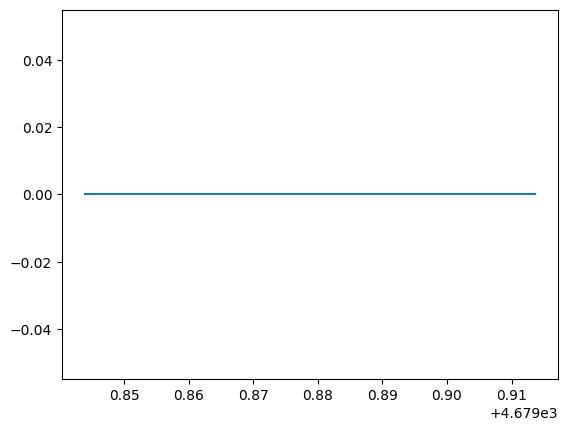

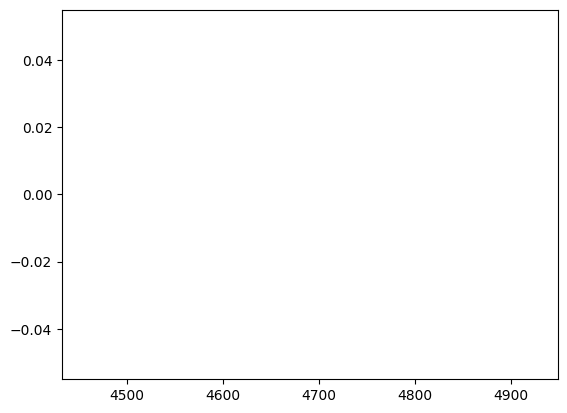

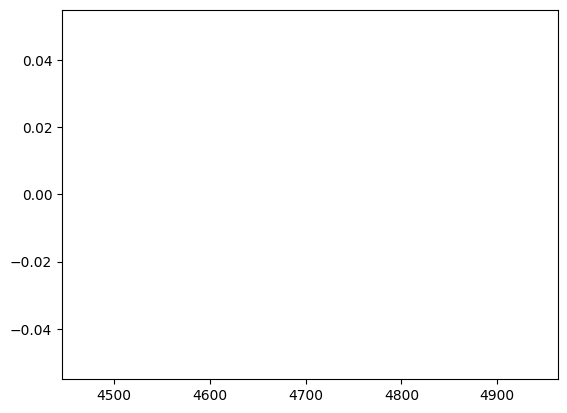

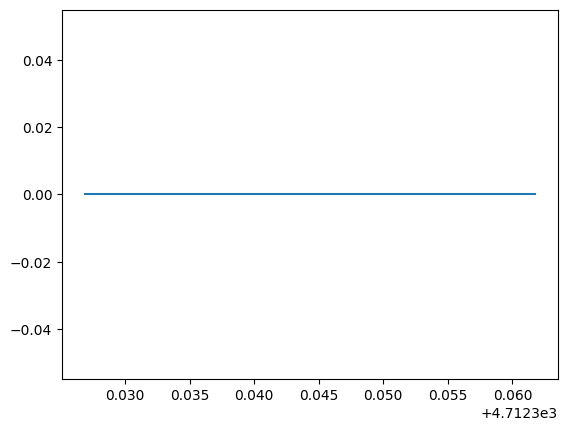

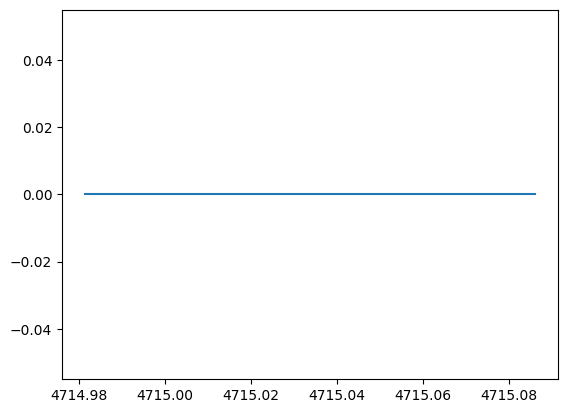

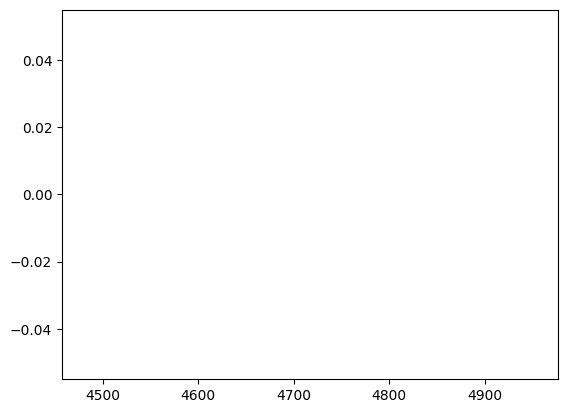

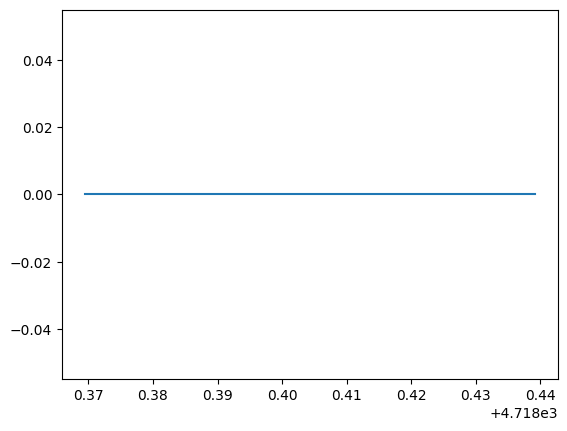

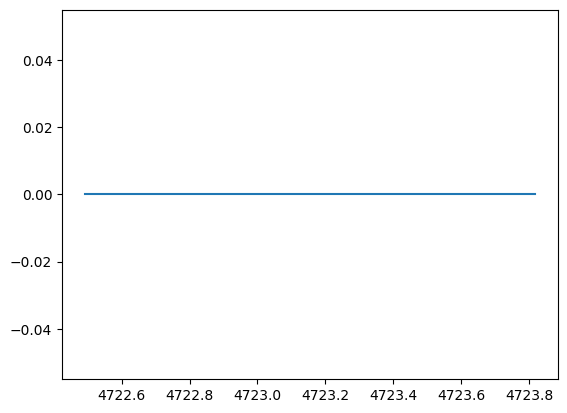

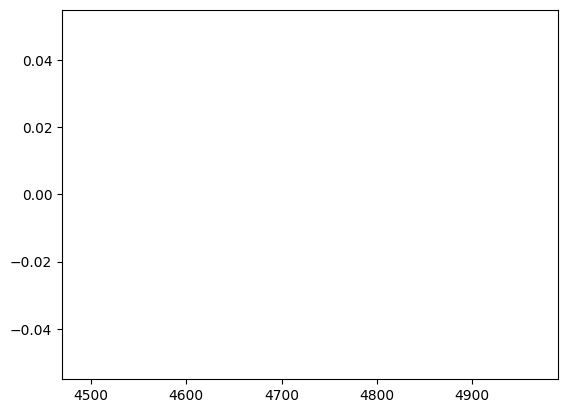

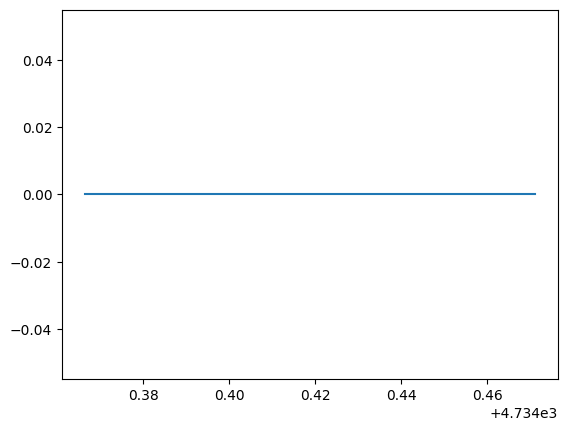

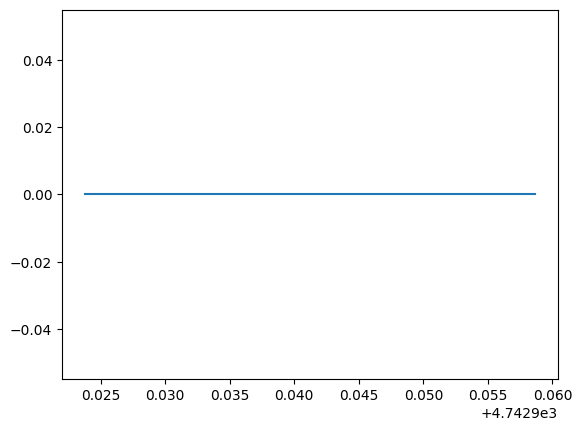

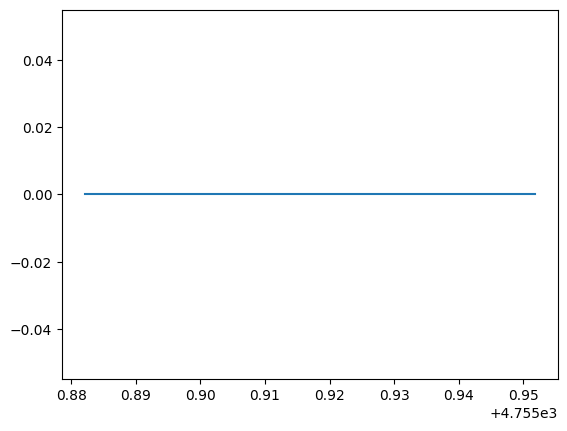

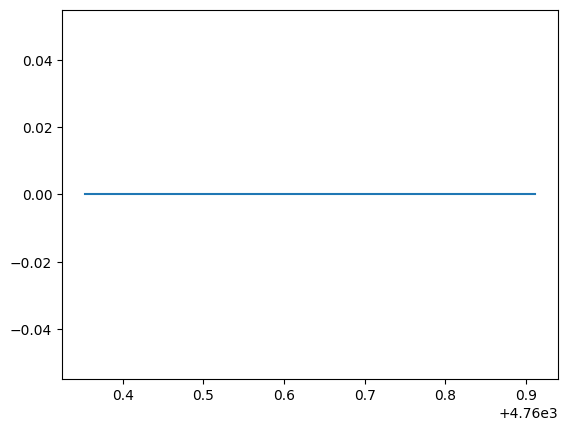

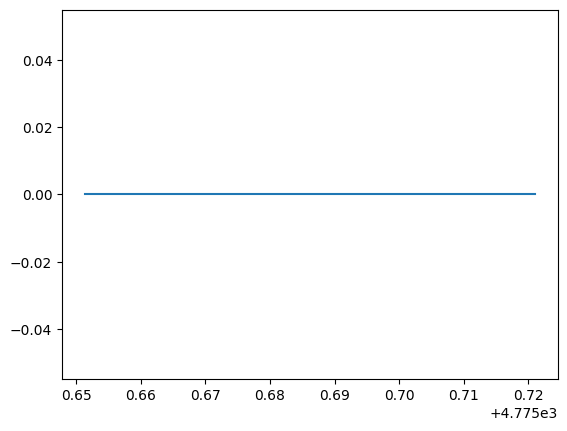

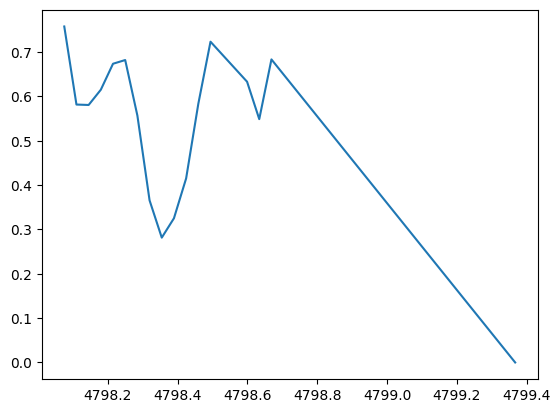

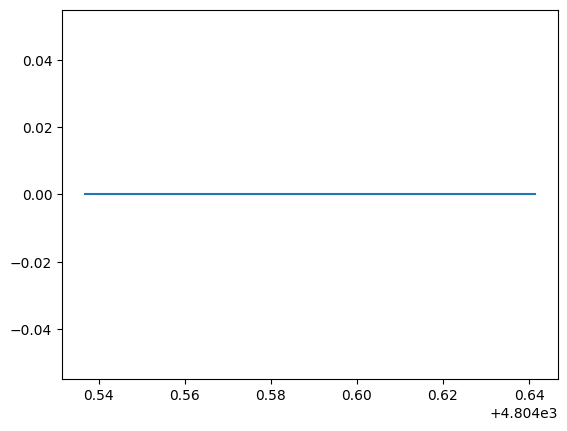

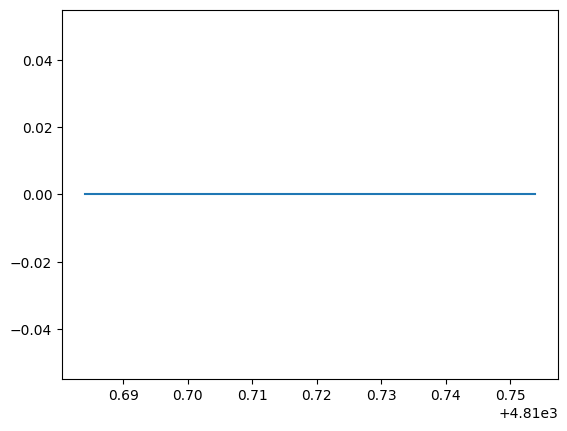

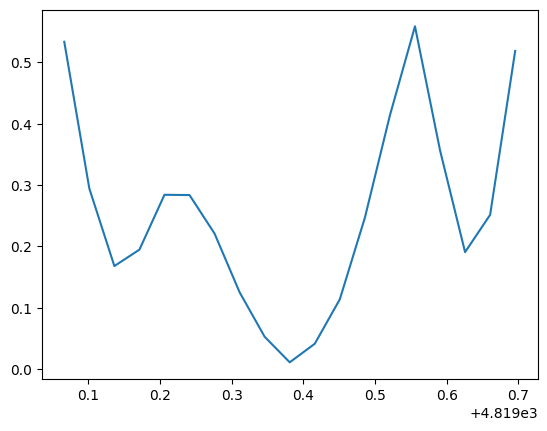

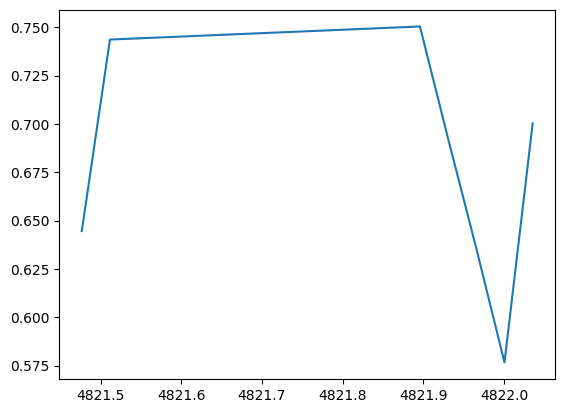

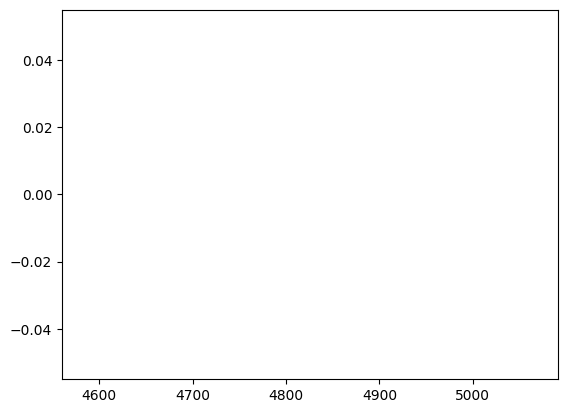

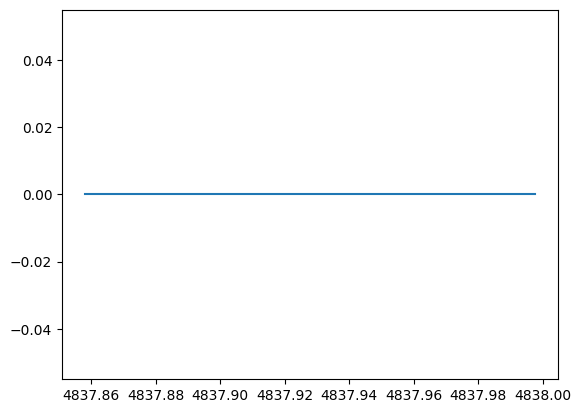

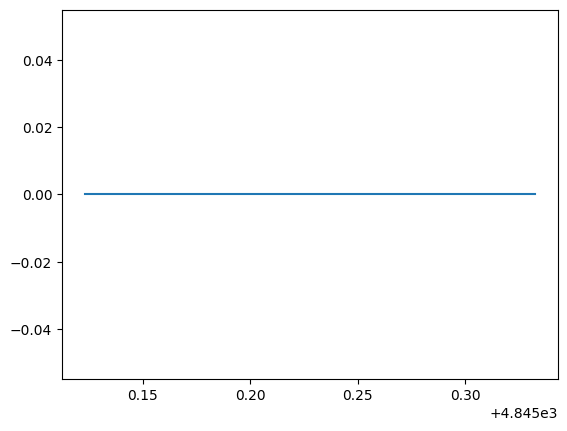

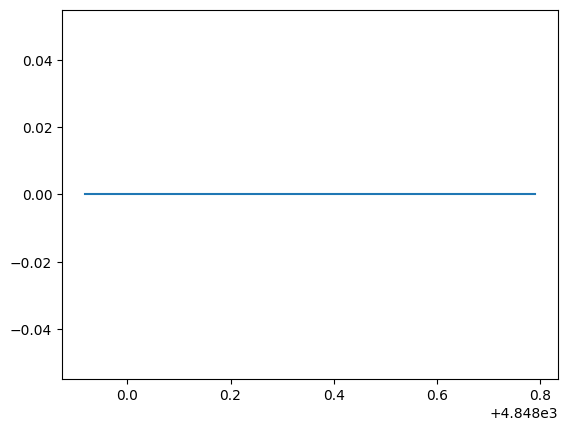

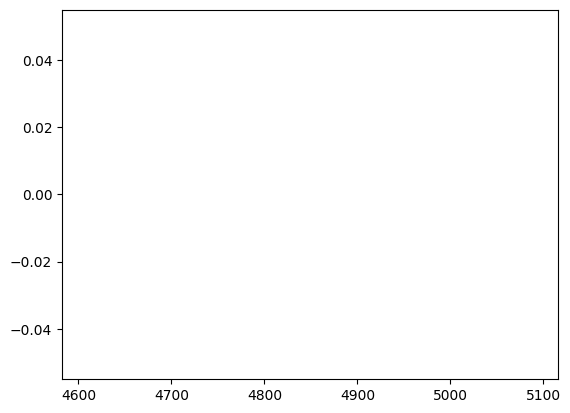

<Figure size 640x480 with 0 Axes>

In [87]:
for line in absorption_lines:
    line_wavelengths, line_fluxes = zip(*line.points_within)
    plt.plot(line_wavelengths, line_fluxes, label=f'Feature from {line.start} to {line.stop}')
    plt.show()
    plt.clf()

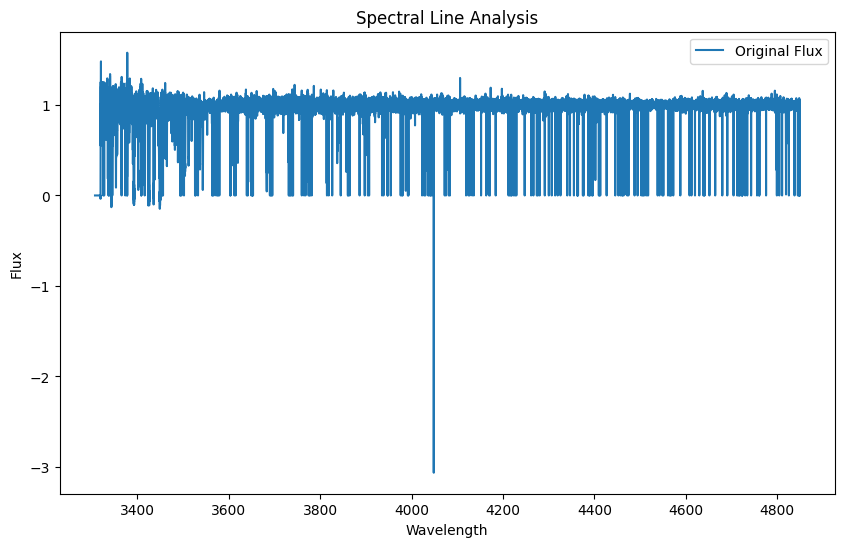

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian
from astropy.io import fits

class AbsorptionLine:
    def __init__(self, start, stop):
        self.start = start
        self.stop = stop
        self.points_within = []  # This will hold tuples of (wavelength, flux)

    def add_point(self, wl, fl):
        self.points_within.append((wl, fl))
        
#loat the actual data
test_file='/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J000520+052410/Sargent_Oct_12_13_14_1999/'
lower_lim=3307
upper_lim=4849

flux=get_data(test_file+'J000520+052410_f.fits')
wavelength = np.linspace(lower_lim,upper_lim,len(data))
error=get_data(test_file+'J000520+052410_e.fits')

std=np.std(flux)
mean=np.mean(flux)

def calculate_weighted_equivalent_width(flux, wavelength, resolution):
    # Constants
    R = resolution  # Resolution of the spectrograph
    sigma_ISF = wavelength / (2 * np.sqrt(2 * np.log(2)) * R)  # Gaussian sigma per pixel
    
    # Calculate the Gaussian weights for the ISF
    window_size = int(4 * sigma_ISF.max())  # Cover +/- 4 sigma
    gaussian_weights = gaussian(window_size, std=sigma_ISF.mean())
    gaussian_weights /= gaussian_weights.sum()  # Normalize
    
    # Compute weighted flux decrements
    weighted_flux = np.convolve(flux, gaussian_weights, mode='same')
    
    # Calculate equivalent width (simple integration over the line)
    dw = np.diff(wavelength)
    dw = np.concatenate([dw, [dw[-1]]])  # Extend the last element
    equivalent_width = np.sum(weighted_flux * dw)
    
    return equivalent_width


resolution = 5000  # Example resolution
eq_width = calculate_weighted_equivalent_width(flux, wavelength, resolution)

# Plotting the result
plt.figure(figsize=(10, 6))
plt.plot(wavelength, flux, label='Original Flux')
plt.title('Spectral Line Analysis')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.show()

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from astropy.io import fits

class AbsorptionLine:
    def __init__(self, start, stop, values):
        self.start = start
        self.stop = stop
        self.points_within = values  # This will hold tuples of (wavelength, flux)
        
        self.center = (start[0] + stop[0]) / 2
        
        self.peak = min(self.points_within, key=lambda x: x[1])
        
#load the actual data
test_file='/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J000520+052410/Sargent_Oct_12_13_14_1999/'
lower_lim=3307
upper_lim=4849

flux=get_data(test_file+'J000520+052410_f.fits')
wavelength = np.linspace(lower_lim,upper_lim,len(data))
error=get_data(test_file+'J000520+052410_e.fits')

std=np.std(flux)
mean=np.mean(flux)

# Detection threshold
N = 2
threshold = mean - (N * std)

values=[]
absorption_lines=[]
started=False

for i, point in enumerate(flux):
    if point <= threshold:
        if not started:
            started = True
            start = (wavelength[i], point)
            values = [start]  # Initialize with the start point
        else:
            values.append((wavelength[i], point))
    else:
        if started:
            started = False
            stop = (wavelength[i-1], flux[i-1])
            values.append(stop)
            absorption_lines.append(AbsorptionLine(start, stop, values))
            values = []
            
            
# Analyzing redshift
mgii_lines = [2796, 2803]
tolerance = .01  # Tolerance in wavelength to consider a match

good_redshifts = []
for red in np.linspace(0, 2, 2001):
    for mgii in mgii_lines:
        test_loc = mgii * (1 + red)
        if any(abs(test_loc - line.center) < tolerance for line in absorption_lines):
            good_redshifts.append(red)

# Reduce duplicates in good_redshifts with a tolerance
good_redshifts = np.unique(np.round(good_redshifts, decimals=3))

print(good_redshifts)
        
        
def plot_spectrum(width,start,redshift):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, label='Original Flux')
    plt.axvline(mgii_lines[0] * (1 + redshift),color="black")
    plt.axvline(mgii_lines[1] * (1 + redshift),color="black")
    for line in absorption_lines:
        plt.axvline(line.center, color='red')
    plt.title('Spectral Line Analysis')
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.xlim(start,start+width)
    print(f"line1:{mgii_lines[0] * (1 + redshift)}")
    print(f"line1:{mgii_lines[1] * (1 + redshift)}")
    #plt.legend()
    plt.show()

# Create sliders and interact function
width_slider = FloatSlider(value=20, min=1, max=upper_lim-lower_lim, step=0.00001, description='Width', readout_format='.4f')
start_slider = FloatSlider(value=lower_lim, min=lower_lim, max=upper_lim-10, step=0.00001, description='Left Edge', readout_format='.4f')
redshift_slider = FloatSlider(value=0, min=0, max=2, step=0.0000001, description='redshift', readout_format='.4f')
interact(plot_spectrum, width=width_slider,start=start_slider,redshift=redshift_slider)


[0.381 0.659]


interactive(children=(FloatSlider(value=20.0, description='Width', max=1542.0, min=1.0, readout_format='.4f', …

<function __main__.plot_spectrum(width, start, redshift)>

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from astropy.io import fits

        
with open('/Users/jakereinheimer/Desktop/Fakhri/atom_db.dat','r') as f:
    content=f.readlines()

    content=content[9:]

    for row in content:

        if row[0]=="!":
            break

        atom=row[:row.find(";")]

        atoms.append(atom)

        new_line=row[row.find(";")+1:]

        while new_line[0]==" ":
            new_line=new_line[1:]

        transisition=new_line[:new_line.find(" "):]

        transisitions.append(float(transisition))

df=pd.DataFrame({
    "Atomic Transisitions":atoms,
    "Emission Line":transisitions
})

redshift=0

mgii_line1=2796
mgii_line2=2803


    
#load the actual data
test_file='/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J000520+052410/Sargent_Oct_12_13_14_1999/'
lower_lim=3307
upper_lim=4849

flux=get_data(test_file+'J000520+052410_f.fits')
wavelength = np.linspace(lower_lim,upper_lim,len(data))
error=get_data(test_file+'J000520+052410_e.fits')

def plot_spectrum(width,start,redshift):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, label='Original Flux')
    plt.axvline(mgii_line1 * (1 + redshift),color="red")
    plt.axvline(mgii_line2 * (1 + redshift),color="red")
    plt.title('Spectral Line Analysis')
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.xlim(start,start+width)
    print(f"line1:{mgii_line1 * (1 + redshift)}")
    print(f"line1:{mgii_line2 * (1 + redshift)}")
    #plt.legend()
    plt.show()

# Create sliders and interact function
width_slider = FloatSlider(value=20, min=1, max=upper_lim-lower_lim, step=0.00001, description='Width', readout_format='.4f')
start_slider = FloatSlider(value=lower_lim, min=lower_lim, max=upper_lim-10, step=0.00001, description='Left Edge', readout_format='.4f')
redshift_slider = FloatSlider(value=0, min=0, max=2, step=0.0000001, description='redshift', readout_format='.4f')
interact(plot_spectrum, width=width_slider,start=start_slider,redshift=redshift_slider)

interactive(children=(FloatSlider(value=20.0, description='Width', max=1542.0, min=1.0, readout_format='.4f', …

<function __main__.plot_spectrum(width, start, redshift)>

In [150]:
#load the actual data
test_file='/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J000520+052410/Sargent_Oct_12_13_14_1999/'
lower_lim=3307
upper_lim=4849

flux=get_data(test_file+'J000520+052410_f.fits')
wavelength = np.linspace(lower_lim,upper_lim,len(data))
error=get_data(test_file+'J000520+052410_e.fits')

from scipy.signal import find_peaks

mgii_doublet = (2796, 2803)

# Assuming absorption lines appear as minima
inverted_flux = -flux
peaks, _ = find_peaks(inverted_flux, prominence=1)  # Adjust prominence according to your data
observed_wavelengths = wavelength[peaks]



# Finding potential redshift matches
z_matches = []
for w in observed_wavelengths:
    for line in mgii_doublet:
        z = w / line - 1
        if z > 0:
            z_matches.append((line, w, z))

# Filter for good redshifts where both lines match
good_redshifts = {}
for line1, w1, z1 in z_matches:
    for line2, w2, z2 in z_matches:
        if line1 != line2 and np.abs(z1 - z2) < 0.00001:  # small tolerance for redshift agreement
            z_avg = (z1 + z2) / 2
            key = f'z ≈ {z_avg:.3f}'
            if key not in good_redshifts:
                good_redshifts[key] = []
            good_redshifts[key].append((line1, w1))
            good_redshifts[key].append((line2, w2))

# Display good redshifts
for z, matches in good_redshifts.items():
    print(f'{z}: Matches at {set(matches)}')
    
def plot_spectrum(width,start,redshift):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, label='Original Flux')
    plt.axvline(mgii_line1 * (1 + redshift),color="red")
    plt.axvline(mgii_line2 * (1 + redshift),color="red")
    for p in observed_wavelengths:
        plt.axvline(p,color="black")
    plt.title('Spectral Line Analysis')
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.xlim(start,start+width)
    print(f"line1:{mgii_line1 * (1 + redshift)}")
    print(f"line1:{mgii_line2 * (1 + redshift)}")
    #plt.legend()
    plt.show()

# Create sliders and interact function
width_slider = FloatSlider(value=20, min=1, max=upper_lim-lower_lim, step=0.00001, description='Width', readout_format='.4f')
start_slider = FloatSlider(value=lower_lim, min=lower_lim, max=upper_lim-10, step=0.00001, description='Left Edge', readout_format='.4f')
redshift_slider = FloatSlider(value=0, min=0, max=2, step=0.0000001, description='redshift', readout_format='.4f')
interact(plot_spectrum, width=width_slider,start=start_slider,redshift=redshift_slider)


z ≈ 0.631: Matches at {(2803, 4572.545120956782), (2796, 4561.123674911661)}


interactive(children=(FloatSlider(value=20.0, description='Width', max=1542.0, min=1.0, readout_format='.4f', …

<function __main__.plot_spectrum(width, start, redshift)>

Good canidates:122
Best canidates: 4401.17 and 4408.17
[(4401.169035886221, 0.33323935), (4401.169035886221, 0.33323935)]
That Makes Z=0.5740947910894924


interactive(children=(FloatSlider(value=20.0, description='Width', max=2833.0, min=1.0, readout_format='.4f', …

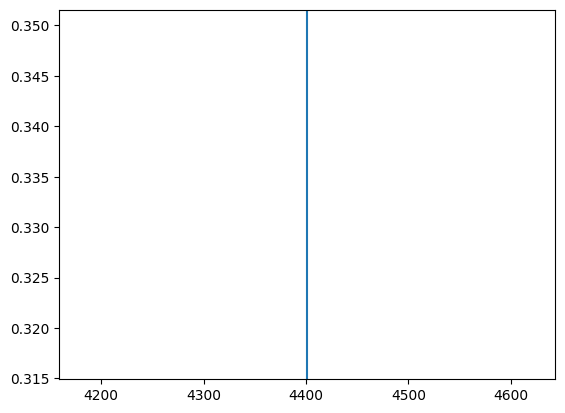

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.widgets import Slider
import os
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from ipywidgets import interact, FloatSlider
    
def normalize(data):

    # Min-Max scaling
    min_val = np.min(data)
    max_val = np.max(data)

    scaled_data = (data - min_val) / (max_val - min_val)

    return scaled_data

class AbsorptionLine:
    def __init__(self, start, stop, values):
        self.start = start
        self.stop = stop
        self.values = values  # This will hold tuples of (wavelength, flux)
        
        self.wave,self.fluxs = zip(*self.values)
        
        self.center = (start[0] + stop[0]) / 2
        
        self.peak = min(self.values, key=lambda x: x[1])
        
    def plot(self):
        
        wavelengths, fluxes = zip(*self.values)
        
        plt.plot(wavelengths,fluxes)
        plt.axvline(self.center)
        
    def fit(self):

        def voigt(x, center, amplitude, sigma, gamma):
            """
            Voigt profile function suitable for curve fitting.
            x : array_like - Independent variable (wavelengths).
            center : float - Center of the line.
            amplitude : float - Amplitude of the Voigt profile.
            sigma : float - Gaussian sigma.
            gamma : float - Lorentzian gamma.
            """
            return amplitude * voigt_profile(x - center, sigma, gamma)


        wavelengths, fluxes = zip(*self.values)
        wavelengths = np.array(wavelengths)
        fluxes = np.array(fluxes)

        # Initial guesses for center, amplitude, sigma, and gamma
        # These should be reasonable based on your data's expected values
        initial_guess = [self.center, 1., .1, .1]

        # Perform the curve fitting
        params, param_conv = curve_fit(voigt, wavelengths, fluxes, p0=initial_guess, maxfev=1000000000)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.scatter(wavelengths, fluxes, color='red', label='Data')
        plt.plot(wavelengths, voigt(self.wave, *params), label='Fitted Voigt Profile', color='blue')
        plt.title('Voigt Profile Fit to Spectral Data')
        plt.xlabel('Wavelength (Å)')
        plt.ylabel('Flux')
        plt.legend()
        plt.show()

        print("Best-fit parameters:", params)


        
def get_data(file):
    with fits.open(file) as hdul:

        spectral_data = hdul[0].data  # Change the index if your data is in a different extension

        return spectral_data

class VPFit:
    
    def __init__(self,flux_loc,error_loc,wavelegnth_start,wavelegnth_end,atom_loc):
        
        self.flux=get_data(flux_loc)
        self.wavelength = np.linspace(wavelegnth_start,wavelegnth_end,len(self.flux))
        self.wavelength_start=wavelegnth_start
        self.wavelength_end=wavelegnth_end
        self.error=get_data(error_loc)
        
        for i,f in enumerate(self.flux):
            if f<0:
                self.flux[i]=0
                
        
        #get vpfit atomic transisitions
        atoms=[]
        transisitions=[]
        #get atom database
        with open(atom_loc,'r') as f:
            
            content=f.readlines()

            content=content[9:]

            for row in content:

                if row[0]=="!":
                    break

                atom=row[:row.find(";")]

                atoms.append(atom)

                new_line=row[row.find(";")+1:]

                while new_line[0]==" ":
                    new_line=new_line[1:]

                transisition=new_line[:new_line.find(" "):]

                transisitions.append(float(transisition))

        self.AtomDB=pd.DataFrame({
            "Atomic Transisitions":atoms,
            "Emission Line":transisitions
        })
        
        
    def PlotFlux(self):
        
        def plot_spectrum(width,start):
            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(self.wavelength, self.flux, label='Original Flux')
            plt.title('Spectral Line Analysis')
            plt.xlabel('Wavelength')
            plt.ylabel('Flux')
            plt.xlim(start,start+width)
            plt.show()

        # Create sliders and interact function
        width_slider = FloatSlider(value=20, min=1, max=self.wavelength_end-self.wavelength_start, step=0.00001, description='Width', readout_format='.4f')
        start_slider = FloatSlider(value=self.wavelength_start, min=self.wavelength_start, max=self.wavelength_end-10, step=0.00001, description='Left Edge', readout_format='.4f')
        interact(plot_spectrum, width=width_slider,start=start_slider)
        
        
    def FindAbsorptions(self,find_peak=False,N=2,plot=False):
        
        if find_peak==True:
            
            from scipy.signal import find_peaks

            inverted_flux = -self.flux
            peaks, _ = find_peaks(inverted_flux, prominence=1)  # Adjust prominence according to your data
            self.absorptions = self.wavelength[peaks]
            
        else:
            
            std=np.std(self.flux)
            mean=np.mean(self.flux)

            # Detection threshold
            threshold = mean - (N * std)

            values=[]
            self.absorptions=[]
            started=False

            for i, point in enumerate(self.flux):
                if point <= threshold:
                    if not started:
                        started = True
                        start = (self.wavelength[i], point)
                        values = [start]
                        #for j in range(1,5):
                        #    values.append((self.wavelength[i-j], self.flux[i-j]))# Initialize with the start point
                    else:
                        values.append((self.wavelength[i], point))
                else:
                    if started:
                        started = False
                        stop = (self.wavelength[i-1], self.flux[i-1])
                        values.append(stop)
                        #for j in range(5):
                        #    values.append((self.wavelength[i+j], self.flux[i+j]))

                        self.absorptions.append(AbsorptionLine(start, stop, values))
                        values = []
                        
        if plot==True:
            
            if find_peak==True:
                
                def plot_spectrum(width,start):
                    # Plotting
                    plt.figure(figsize=(10, 6))
                    plt.plot(self.wavelength, self.flux, label='Original Flux')
                    for line in self.absorptions:
                        plt.axvline(line,color="red",linestyle="dashed")
                    plt.title('Spectral Line Analysis')
                    plt.xlabel('Wavelength')
                    plt.ylabel('Flux')
                    plt.xlim(start,start+width)
                    plt.ylim(-1,2)
                    #plt.legend()
                    plt.show()

                # Create sliders and interact function
                width_slider = FloatSlider(value=20, min=1, max=self.wavelength_end-self.wavelength_start, step=0.00001, description='Width', readout_format='.4f')
                start_slider = FloatSlider(value=self.wavelength_start, min=self.wavelength_start, max=self.wavelength_end-10, step=0.00001, description='Left Edge', readout_format='.4f')
                interact(plot_spectrum, width=width_slider,start=start_slider)
                
                
            else:
            
                def plot_spectrum(width,start):
                    # Plotting
                    plt.figure(figsize=(10, 6))
                    plt.plot(self.wavelength, self.flux, label='Original Flux')
                    for line in self.absorptions:
                        plt.axvline(line.center,color="red",linestyle="dashed")
                    plt.title('Spectral Line Analysis')
                    plt.xlabel('Wavelength')
                    plt.ylabel('Flux')
                    plt.xlim(start,start+width)
                    plt.ylim(-1,2)
                    #plt.legend()
                    plt.show()

                # Create sliders and interact function
                width_slider = FloatSlider(value=20, min=1, max=self.wavelength_end-self.wavelength_start, step=0.00001, description='Width', readout_format='.4f')
                start_slider = FloatSlider(value=self.wavelength_start, min=self.wavelength_start, max=self.wavelength_end-10, step=0.00001, description='Left Edge', readout_format='.4f')
                interact(plot_spectrum, width=width_slider,start=start_slider)
            
                        
    
    def MatchMGII(self):
        
        self.FindAbsorptions()
        
        mgii_doublet = (2796, 2803)
        mgii_dist=abs(mgii_doublet[0]-mgii_doublet[1])
        redshifts = []
        
        tolerance=1
        good_lines=[]
        
        for i,absorption in enumerate(self.absorptions):
            
            for j in range(1,6):
                
                try:
                
                    other_absorption=self.absorptions[i+j]

                    dist=abs(absorption.center-other_absorption.center)

                    if abs(dist-mgii_dist)<tolerance:
                        good_lines.append((absorption,other_absorption))
                        
                except:
                    break

        print(f"Good canidates:{len(good_lines)}")
        
        
        better_lines=[]
        while True:
            
            tolerance /= 2
            
            if len(better_lines)==1:
                break
            
            better_lines=[]
            
            for pair in good_lines:
                
                dist=abs(pair[0].center-pair[1].center)
                
                if abs(dist-mgii_dist)<tolerance:
                    
                    better_lines.append(pair)
                    
        print(f"Best canidates: {better_lines[0][0].center:.2f} and {better_lines[0][1].center:.2f}")
        print(better_lines[0][0].values)
                    
        
        z= abs(mgii_doublet[0]-better_lines[0][0].center)/mgii_doublet[0]
        
        print(f"That Makes Z={z}")

                
        def plot_spectrum(width,start,redshift):
            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(self.wavelength, self.flux, label='Original Flux')
            plt.axvline(better_lines[0][0].center,color="red")
            plt.axvline(better_lines[0][1].center,color="red")
            plt.title('Spectral Line Analysis')
            plt.xlabel('Wavelength')
            plt.ylabel('Flux')
            plt.xlim(start,start+width)
            #plt.legend()
            plt.show()

        # Create sliders and interact function
        width_slider = FloatSlider(value=20, min=1, max=self.wavelength_end-self.wavelength_start, step=0.00001, description='Width', readout_format='.4f')
        start_slider = FloatSlider(value=better_lines[0][0].center-10, min=self.wavelength_start, max=self.wavelength_end-10, step=0.00001, description='Left Edge', readout_format='.4f')
        redshift_slider = FloatSlider(value=z, min=0, max=2, step=0.0000001, description='redshift', readout_format='.4f')
        interact(plot_spectrum, width=width_slider,start=start_slider,redshift=redshift_slider)
                    
                    
        return better_lines[0][0]
            

        
        
file='/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/'
test_file="/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J004358-255115/Tytler_Dec_10_12_13_14_2009/"
vp=VPFit(test_file+'J004358-255115_f.fits',test_file+'J004358-255115_e.fits',3365,6198,'/Users/jakereinheimer/Desktop/Fakhri/atom_db.dat')
#vp.FindAbsorptions(plot=True,N=3)
line=vp.MatchMGII()
line.plot()
#line.fit()


        

In [81]:
#another try

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.widgets import Slider
import os
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from ipywidgets import interact, FloatSlider
from scipy.ndimage import gaussian_filter
    
def normalize(data):

    # Min-Max scaling
    min_val = np.min(data)
    max_val = np.max(data)

    scaled_data = (data - min_val) / (max_val - min_val)

    return scaled_data

class AbsorptionLine:
    def __init__(self, start, stop, values):
        self.start = start
        self.stop = stop
        self.values = values  # This will hold tuples of (wavelength, flux)
        
        self.wave,self.fluxs = zip(*self.values)
        
        self.center = (start[0] + stop[0]) / 2
        
        self.peak = min(self.values, key=lambda x: x[1])
        
    def plot(self):
        
        wavelengths, fluxes = zip(*self.values)
        
        plt.plot(wavelengths,fluxes)
        plt.axvline(self.center)
        plt.show()
        plt.clf()
        
    def fit(self):

        def voigt(x, center, amplitude, sigma, gamma):
            """
            Voigt profile function suitable for curve fitting.
            x : array_like - Independent variable (wavelengths).
            center : float - Center of the line.
            amplitude : float - Amplitude of the Voigt profile.
            sigma : float - Gaussian sigma.
            gamma : float - Lorentzian gamma.
            """
            return amplitude * voigt_profile(x - center, sigma, gamma)


        wavelengths, fluxes = zip(*self.values)
        wavelengths = np.array(wavelengths)
        fluxes = np.array(fluxes)

        # Initial guesses for center, amplitude, sigma, and gamma
        # These should be reasonable based on your data's expected values
        initial_guess = [self.center, 1., .1, .1]

        # Perform the curve fitting
        params, param_conv = curve_fit(voigt, wavelengths, fluxes, p0=initial_guess, maxfev=1000000000)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.scatter(wavelengths, fluxes, color='red', label='Data')
        plt.plot(wavelengths, voigt(self.wave, *params), label='Fitted Voigt Profile', color='blue')
        plt.title('Voigt Profile Fit to Spectral Data')
        plt.xlabel('Wavelength (Å)')
        plt.ylabel('Flux')
        plt.legend()
        plt.show()

        print("Best-fit parameters:", params)


        
def get_data(file):
    with fits.open(file) as hdul:

        spectral_data = hdul[0].data  # Change the index if your data is in a different extension

        return spectral_data

class VPFit:
    
    def __init__(self,flux_loc,error_loc,wavelegnth_start,wavelegnth_end,atom_loc):
        
        self.flux=get_data(flux_loc)
        self.wavelength = np.linspace(wavelegnth_start,wavelegnth_end,len(self.flux))
        self.wavelength_start=wavelegnth_start
        self.wavelength_end=wavelegnth_end
        self.error=get_data(error_loc)
        
        for i,f in enumerate(self.flux):
            if f<0:
                self.flux[i]=0
                
        self.flux=normalize(self.flux)
        
        #self.flux= gaussian_filter(self.flux, sigma=5)
                
        
        #get vpfit atomic transisitions
        atoms=[]
        transisitions=[]
        #get atom database
        with open(atom_loc,'r') as f:
            
            content=f.readlines()

            content=content[9:]

            for row in content:

                if row[0]=="!":
                    break

                atom=row[:row.find(";")]

                atoms.append(atom)

                new_line=row[row.find(";")+1:]

                while new_line[0]==" ":
                    new_line=new_line[1:]

                transisition=new_line[:new_line.find(" "):]

                transisitions.append(float(transisition))

        self.AtomDB=pd.DataFrame({
            "Atomic Transisitions":atoms,
            "Emission Line":transisitions
        })
        
        
    def PlotFlux(self):
        
        def plot_spectrum(width,start):
            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(self.wavelength, self.flux, label='Original Flux')
            plt.title('Spectral Line Analysis')
            plt.xlabel('Wavelength')
            plt.ylabel('Flux')
            plt.xlim(start,start+width)
            plt.show()

        # Create sliders and interact function
        width_slider = FloatSlider(value=20, min=1, max=self.wavelength_end-self.wavelength_start, step=0.00001, description='Width', readout_format='.4f')
        start_slider = FloatSlider(value=self.wavelength_start, min=self.wavelength_start, max=self.wavelength_end-10, step=0.00001, description='Left Edge', readout_format='.4f')
        interact(plot_spectrum, width=width_slider,start=start_slider)
        
        
    def FindAbsorptions(self,find_peak=False,N=3,plot=False):
        
        self.absorptions=[]
        
        #find peaks method from scipy
        if find_peak==True:
            
            from scipy.signal import find_peaks

            inverted_flux = -self.flux
            #plt.plot(self.wavelength,inverted_flux)
            #plt.show()
            peaks, _ = find_peaks(inverted_flux, height=-.2,prominence=.1)  # Adjust prominence according to your data
            #self.absorptions = self.wavelength[peaks]
            
            absorption_lines = []

            for peak in peaks:
                # Initialize the indices for the left and right boundaries of the peak
                left_idx = peak
                right_idx = peak

                # Move left from the peak until the flux is no longer decreasing
                while left_idx > 0 and inverted_flux[left_idx - 1] < inverted_flux[left_idx]:
                    left_idx -= 1

                # Move right from the peak until the flux is no longer decreasing
                while right_idx < len(inverted_flux) - 1 and inverted_flux[right_idx + 1] < inverted_flux[right_idx]:
                    right_idx += 1

                # Extract the range for the absorption line
                absorption_line_wavelengths = self.wavelength[left_idx:right_idx + 1]
                absorption_line_flux = self.flux[left_idx:right_idx + 1]

                # Create tuples of (wavelength, flux) for the absorption line
                absorption_values = list(zip(absorption_line_wavelengths, absorption_line_flux))

                # Create an AbsorptionLine object
                new_line = AbsorptionLine((absorption_line_wavelengths[0], absorption_line_flux[0]),
                                          (absorption_line_wavelengths[-1], absorption_line_flux[-1]),
                                          absorption_values)

                # Store the absorption line object
                self.absorptions.append(new_line)

            
            if plot==True:
                def plot_spectrum(width,start):
                    # Plotting
                    plt.figure(figsize=(10, 6))
                    plt.plot(self.wavelength, self.flux, label='Original Flux')
                    for line in self.absorptions:
                        
                        plt.axvline(line.center,color="red",linestyle="dashed")
                    plt.title('Spectral Line Analysis')
                    plt.xlabel('Wavelength')
                    plt.ylabel('Flux')
                    plt.xlim(start,start+width)
                    plt.ylim(-1,2)
                    #plt.legend()
                    plt.show()

                # Create sliders and interact function
                width_slider = FloatSlider(value=20, min=1, max=self.wavelength_end-self.wavelength_start, step=0.00001, description='Width', readout_format='.4f')
                start_slider = FloatSlider(value=self.wavelength_start, min=self.wavelength_start, max=self.wavelength_end-10, step=0.00001, description='Left Edge', readout_format='.4f')
                interact(plot_spectrum, width=width_slider,start=start_slider)
            
        #my method
        else:
            
            std=np.std(self.flux)
            mean=np.mean(self.flux)
            median=np.median(self.flux)

            # Detection threshold
            #threshold = mean - (N * std)
            threshold = median - (1 * std)
            #threshold = .15

            values=[]
            self.absorptions=[]
            started=False

            for i, point in enumerate(self.flux):
                if point <= threshold:
                    if not started:
                        started = True
                        start = (self.wavelength[i], point)
                        #values = [start]
                        #for j in [5,4,3,2,1,0]:
                        #    values.append((self.wavelength[i-j], self.flux[i-j]))# Initialize with the start point
                    else:
                        values.append((self.wavelength[i], point))
                else:
                    if started:
                        started = False
                        stop = (self.wavelength[i-1], self.flux[i-1])
                        values.append(stop)
                        #for j in range(5):
                        #    values.append((self.wavelength[i+j], self.flux[i+j]))

                        self.absorptions.append(AbsorptionLine(start, stop, values))
                        values = []
                        
            if plot==True:
            
                def plot_spectrum(width,start):
                    # Plotting
                    plt.figure(figsize=(10, 6))
                    plt.plot(self.wavelength, self.flux, label='Original Flux')
                    for line in self.absorptions:
                        plt.axvline(line.center,color="red",linestyle="dashed")
                    plt.title('Spectral Line Analysis')
                    plt.xlabel('Wavelength')
                    plt.ylabel('Flux')
                    plt.xlim(start,start+width)
                    plt.ylim(-1,2)
                    #plt.legend()
                    plt.show()

                # Create sliders and interact function
                width_slider = FloatSlider(value=20, min=1, max=self.wavelength_end-self.wavelength_start, step=0.00001, description='Width', readout_format='.4f')
                start_slider = FloatSlider(value=self.wavelength_start, min=self.wavelength_start, max=self.wavelength_end-10, step=0.00001, description='Left Edge', readout_format='.4f')
                interact(plot_spectrum, width=width_slider,start=start_slider)
            
                        
    
    def MatchMGII(self,jake=True):
        
        self.FindAbsorptions(find_peak=True)
        
        
        if jake==False:
            
            mgii_doublet=np.array([2796,2803])
            z_values=np.arange(0,2,.001)
            
            for z in z_values:
                
                expected_wave=mgii_doublet * (1+z)
                
                for line in self.absorptions:
                    for mgii in mgii_doublet:
                        if np.any(np.isclose(line, expected_wavelen, atol=2)):  # 2 Angstrom tolerance, adjust as needed
                            pass
                            #if np.isclose():
                            #matched_lines.append((detected, z))
        
        
        if jake==True:
            
            mgii_doublet = (2796, 2803)
            mgii_dist=abs(mgii_doublet[0]-mgii_doublet[1])
            redshifts = []
        
            tolerance=1
            good_lines=[]

            for i,absorption in enumerate(self.absorptions):

                for j in range(1,6):

                    try:

                        other_absorption=self.absorptions[i+j]

                        dist=abs(absorption.center-other_absorption.center)

                        if abs(dist-mgii_dist)<tolerance:
                            good_lines.append((absorption,other_absorption))

                    except:
                        break

            print(f"Good canidates:{len(good_lines)}")


            better_lines=[]
            while True:

                tolerance /= 2

                if (len(better_lines)<3) and (len(better_lines)>0):
                    break

                better_lines=[]

                for pair in good_lines:

                    dist=abs(pair[0].center-pair[1].center)

                    if abs(dist-mgii_dist)<tolerance:

                        better_lines.append(pair)

            print(f"Best canidates: {better_lines[0][0].center:.2f} and {better_lines[0][1].center:.2f}")
            print(f"2nd Best canidates: {better_lines[1][0].center:.2f} and {better_lines[1][1].center:.2f}")


            z= abs(mgii_doublet[0]-better_lines[0][0].center)/mgii_doublet[0]

            print(f"That Makes Z={z}")


            def plot_spectrum(width,start,redshift):
                # Plotting
                plt.figure(figsize=(10, 6))
                plt.plot(self.wavelength, self.flux, label='Original Flux')
                plt.axvline(better_lines[0][0].center,color="red")
                plt.axvline(better_lines[0][1].center,color="red")
                plt.title('Spectral Line Analysis')
                plt.xlabel('Wavelength')
                plt.ylabel('Flux')
                plt.xlim(start,start+width)
                #plt.legend()
                plt.show()

            # Create sliders and interact function
            width_slider = FloatSlider(value=20, min=1, max=self.wavelength_end-self.wavelength_start, step=0.00001, description='Width', readout_format='.4f')
            start_slider = FloatSlider(value=better_lines[0][0].center-10, min=self.wavelength_start, max=self.wavelength_end-10, step=0.00001, description='Left Edge', readout_format='.4f')
            redshift_slider = FloatSlider(value=z, min=0, max=2, step=0.0000001, description='redshift', readout_format='.8f')
            interact(plot_spectrum, width=width_slider,start=start_slider,redshift=redshift_slider)


            return better_lines[0][0]
            

        
        
file='/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/'
test_file="/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J004358-255115/Tytler_Dec_10_12_13_14_2009/"
vp=VPFit('/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J010806+163550/Tytler_Oct_9_10_11_1999/J010806+163550_f.fits','/Users/jakereinheimer/Desktop/Fakhri/test_data/KODIAQ/J010806+163550/Tytler_Oct_9_10_11_1999/J010806+163550_e.fits',3189,4723,'/Users/jakereinheimer/Desktop/Fakhri/atom_db.dat')
vp.PlotFlux()
#vp.FindAbsorptions(find_peak=True,plot=True)
#vp.FindAbsorptions(plot=True)
#for i,line in enumerate(vp.absorptions):
#    print(line.values)
#    line.plot()
#    
#    if i>10:
#        break
#line=vp.MatchMGII()
#line.plot()
#line.fit()

#vp.absorptions[10].plot()
#vp.absorptions[10].fit()


        

interactive(children=(FloatSlider(value=20.0, description='Width', max=1534.0, min=1.0, readout_format='.4f', …

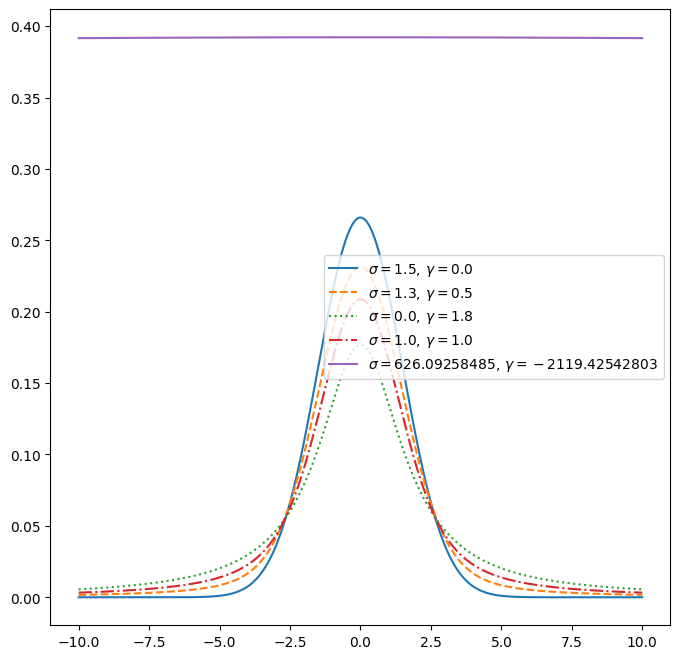

In [294]:
fig, ax = plt.subplots(figsize=(8, 8))
x = np.linspace(-10, 10, 500)
parameters_list = [(1.5, 0., "solid"), (1.3, 0.5, "dashed"),
                   (0., 1.8, "dotted"), (1., 1., "dashdot"),
                  (626.09258485, -2119.42542803,"solid")]
for params in parameters_list:
    sigma, gamma, linestyle = params
    voigt = voigt_profile(x, sigma, gamma)
    ax.plot(x, voigt, label=rf"$\sigma={sigma},\, \gamma={gamma}$",
            ls=linestyle)
ax.legend()
plt.show()